# Searching

When the correct action to take is not immediately obvious, an agent may need to to **plan ahead**: to consider a sequence of actions that form a path to a goal state. Such an agent is called a **problem-solving agent**, and the computational process it undertakes is called **search**. As a running example, imagine an agent on a trip in Romania. The agent must reach Bucharest and it is currently in Arad, with three possible roads leading to Sibiu, Timisoara, and Zerind. Without knowledge of Romania geography, choosing the right path is unclear. If no additional information is available, the agent can only act randomly. This sad situation has to be addressed with more advanced method. 

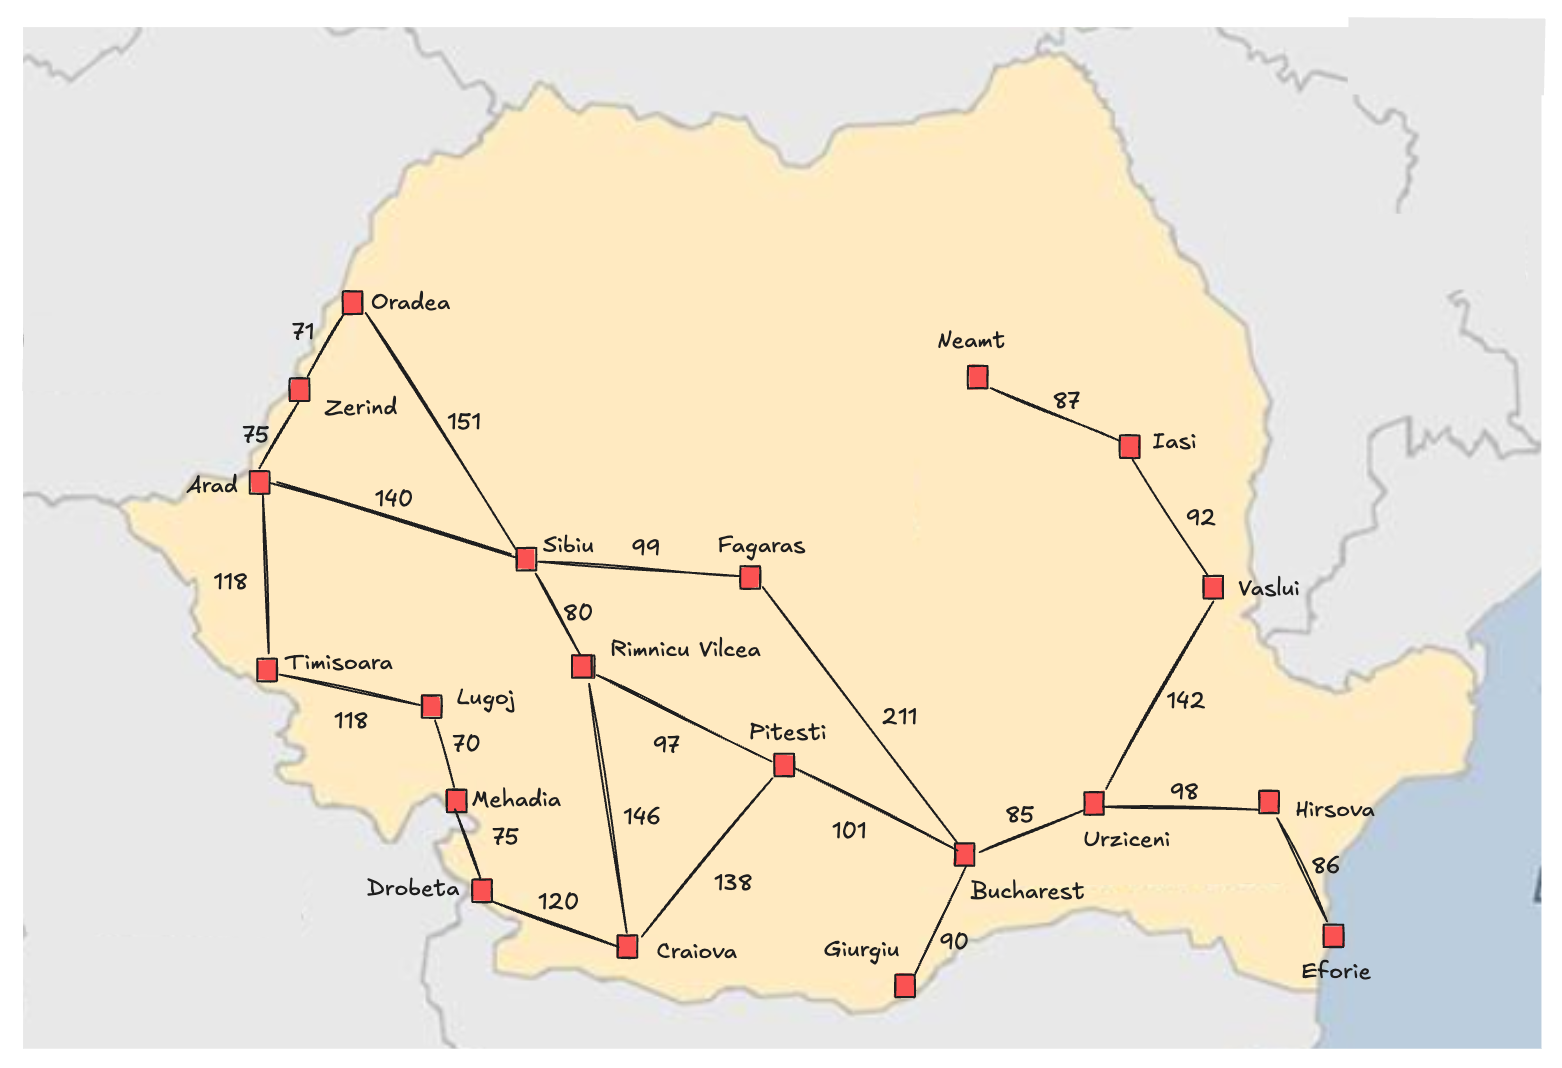

However, with access to a map, the agent can approach the task systematically using a four-phase problem-solving process:

- **Goal formulation**: defines objectives and limits actions. Here, the goal is to reach Bucharest.  
- **Problem formulation**: creates an abstract model of states and actions needed to achieve the goal. In this case, actions involve traveling between cities, with the current city being the only changing factor.  
- **Search**: simulates possible action sequences in its model to find a **solution**, a path leading to the goal (e.g., Arad -> Sibiu -> Fagaras -> Bucharest). It may explore unsuccessful paths before finding a valid one or determining no solution exists.  
- **Execution**: follows the solution, executing actions step by step.

In a fully observable, deterministic, and known environment, the solution is a fixed sequence of actions (e.g., drive to Sibiu, then Fagaras, then Bucharest). If the model is accurate, the agent can ignore percepts during execution since success is guaranteed. This is an **open-loop system**, where the agent does not adjust to new inputs. However, if the model is uncertain or the environment is non-deterministic, a **closed-loop approach** is safer, continuously monitoring percepts. In partially observable or unpredictable settings, solutions take the form of **branching strategies**, adapting actions based on new information. For instance, if the agent plans to drive to Sibiu but encounters a "Road Closed" sign, a **contingency plan** is needed.

## Graph structure

The information about the problem can be represented as a **graph**, where **nodes are states** and **edges are actions**, like the map of Romania. We can implement this idea in Python:

In [92]:
class Graph:
    def __init__(self, graph_dict=None):
        self.graph_dict = graph_dict or {}
        
    def connect_one(self, A, B, distance):
        """Add a link from A to B of given distance"""
        self.graph_dict.setdefault(A, {})[B] = distance
        self.graph_dict.setdefault(B, {})[A] = distance

    def get(self, a, b=None):
        """Return a link distance or a dict of {node: distance} entries.
        .get(a,b) returns the distance or None;
        .get(a) returns a dict of {node: distance} entries, possibly {}."""
        links = self.graph_dict.setdefault(a, {})
        if b is None:
            return links
        else:
            return links.get(b)

    def nodes(self):
        """Return a list of nodes in the graph."""
        s1 = set([k for k in self.graph_dict.keys()])
        s2 = set([k2 for v in self.graph_dict.values() for k2, v2 in v.items()])
        nodes = s1.union(s2)
        return list(nodes)

The constructor call is something like:

In [93]:
g = Graph({'A': {'B': 1, 'C': 2}})

This makes an undirected graph, so inverse links are also added. As an exmaple, the map of Romania problem can be represented as:

In [94]:
romania_map = Graph()

romania_map.connect_one('Arad', 'Zerind', 75)
romania_map.connect_one('Arad', 'Timisoara', 118)
romania_map.connect_one('Arad', 'Sibiu', 140)
romania_map.connect_one('Zerind', 'Oradea', 71)
romania_map.connect_one('Oradea', 'Sibiu', 151)
romania_map.connect_one('Timisoara', 'Lugoj', 111)
romania_map.connect_one('Lugoj', 'Mehadia', 70)
romania_map.connect_one('Mehadia', 'Drobeta', 75)
romania_map.connect_one('Drobeta', 'Craiova', 120)
romania_map.connect_one('Craiova', 'Rimnicu Vilcea', 146)
romania_map.connect_one('Craiova', 'Pitesti', 138)
romania_map.connect_one('Sibiu', 'Rimnicu Vilcea', 80)
romania_map.connect_one('Sibiu', 'Fagaras', 99)
romania_map.connect_one('Rimnicu Vilcea', 'Pitesti', 97)
romania_map.connect_one('Fagaras', 'Bucharest', 211)
romania_map.connect_one('Pitesti', 'Bucharest', 101)
romania_map.connect_one('Bucharest', 'Giurgiu', 90)
romania_map.connect_one('Bucharest', 'Urziceni', 85)
romania_map.connect_one('Urziceni', 'Hirsova', 98)
romania_map.connect_one('Hirsova', 'Eforie', 86)
romania_map.connect_one('Urziceni', 'Vaslui', 142)
romania_map.connect_one('Vaslui', 'Iasi', 92)
romania_map.connect_one('Iasi', 'Neamt', 87)

We can get the successors of a node with:

In [95]:
romania_map.get('Sibiu')

{'Arad': 140, 'Oradea': 151, 'Rimnicu Vilcea': 80, 'Fagaras': 99}

## Problem formulation

In general, the search problem can be defined as a tuple **(S, A, T, I, G)**, where: 

- **S** is the **state space**, representing all possible states the environment can be in (e.g. "Sibiu", "Arad", "Bucharest", etc.).
- **A** is the set of **available actions** in a state (e.g., "go to Sibiu" when in "Arad").
- **T** is the **transition model**, which defines the result of applying an action in a state (e.g., "go to Sibiu" in "Arad" leads to "Sibiu").
- **I** is the **initial state**, where the agent starts (e.g., "Arad").
- **G** is the set of **goal states**, which can be a single state (e.g., "Bucharest"), a set of alternative states, or defined by a property (e.g., no dirt in the vacuum-cleaner world).
- **C** if the **cost function**, which assigns a numeric cost to applying an action (e.g., travel time or distance).

The information about the problem can be given using an **explicit graph**, such as the map of Romania. But in many problems, the graph is represented **only implicitly** by the initial state, actions, and transition model. For the explicit case, we can implement the problem in Python exploiting the graph structure:

In [96]:
class Problem:
    """The abstract class for a formal problem."""

    def __init__(self, initial, goal=None):
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Return the actions that can be executed in the given state. """
        raise NotImplementedError

    def result(self, state, action):
        """Return the state that results from executing the given
        action in the given state."""
        raise NotImplementedError

    def goal_test(self, state):
        """Return True if the state is a goal."""
        raise NotImplementedError

    def path_cost(self, c, state1, action, state2):
        """Return the cost of a path that arrives at state2 from
        state1 via action"""
        raise NotImplementedError

    def value(self, state):
        """For optimization problems, each state can have a value."""
        raise NotImplementedError

A **path** is a sequence of actions, and a **solution** is a path from the initial state to a goal state. Action costs are assumed to be additive, meaning the total cost is the sum of individual action costs. An **optimal solution** has the **lowest path cost** among all solutions. All action costs are positive to avoid complications. The state space can be represented as a **graph**, where **vertices are states** and **directed edges are actions**, like the map of Romania:

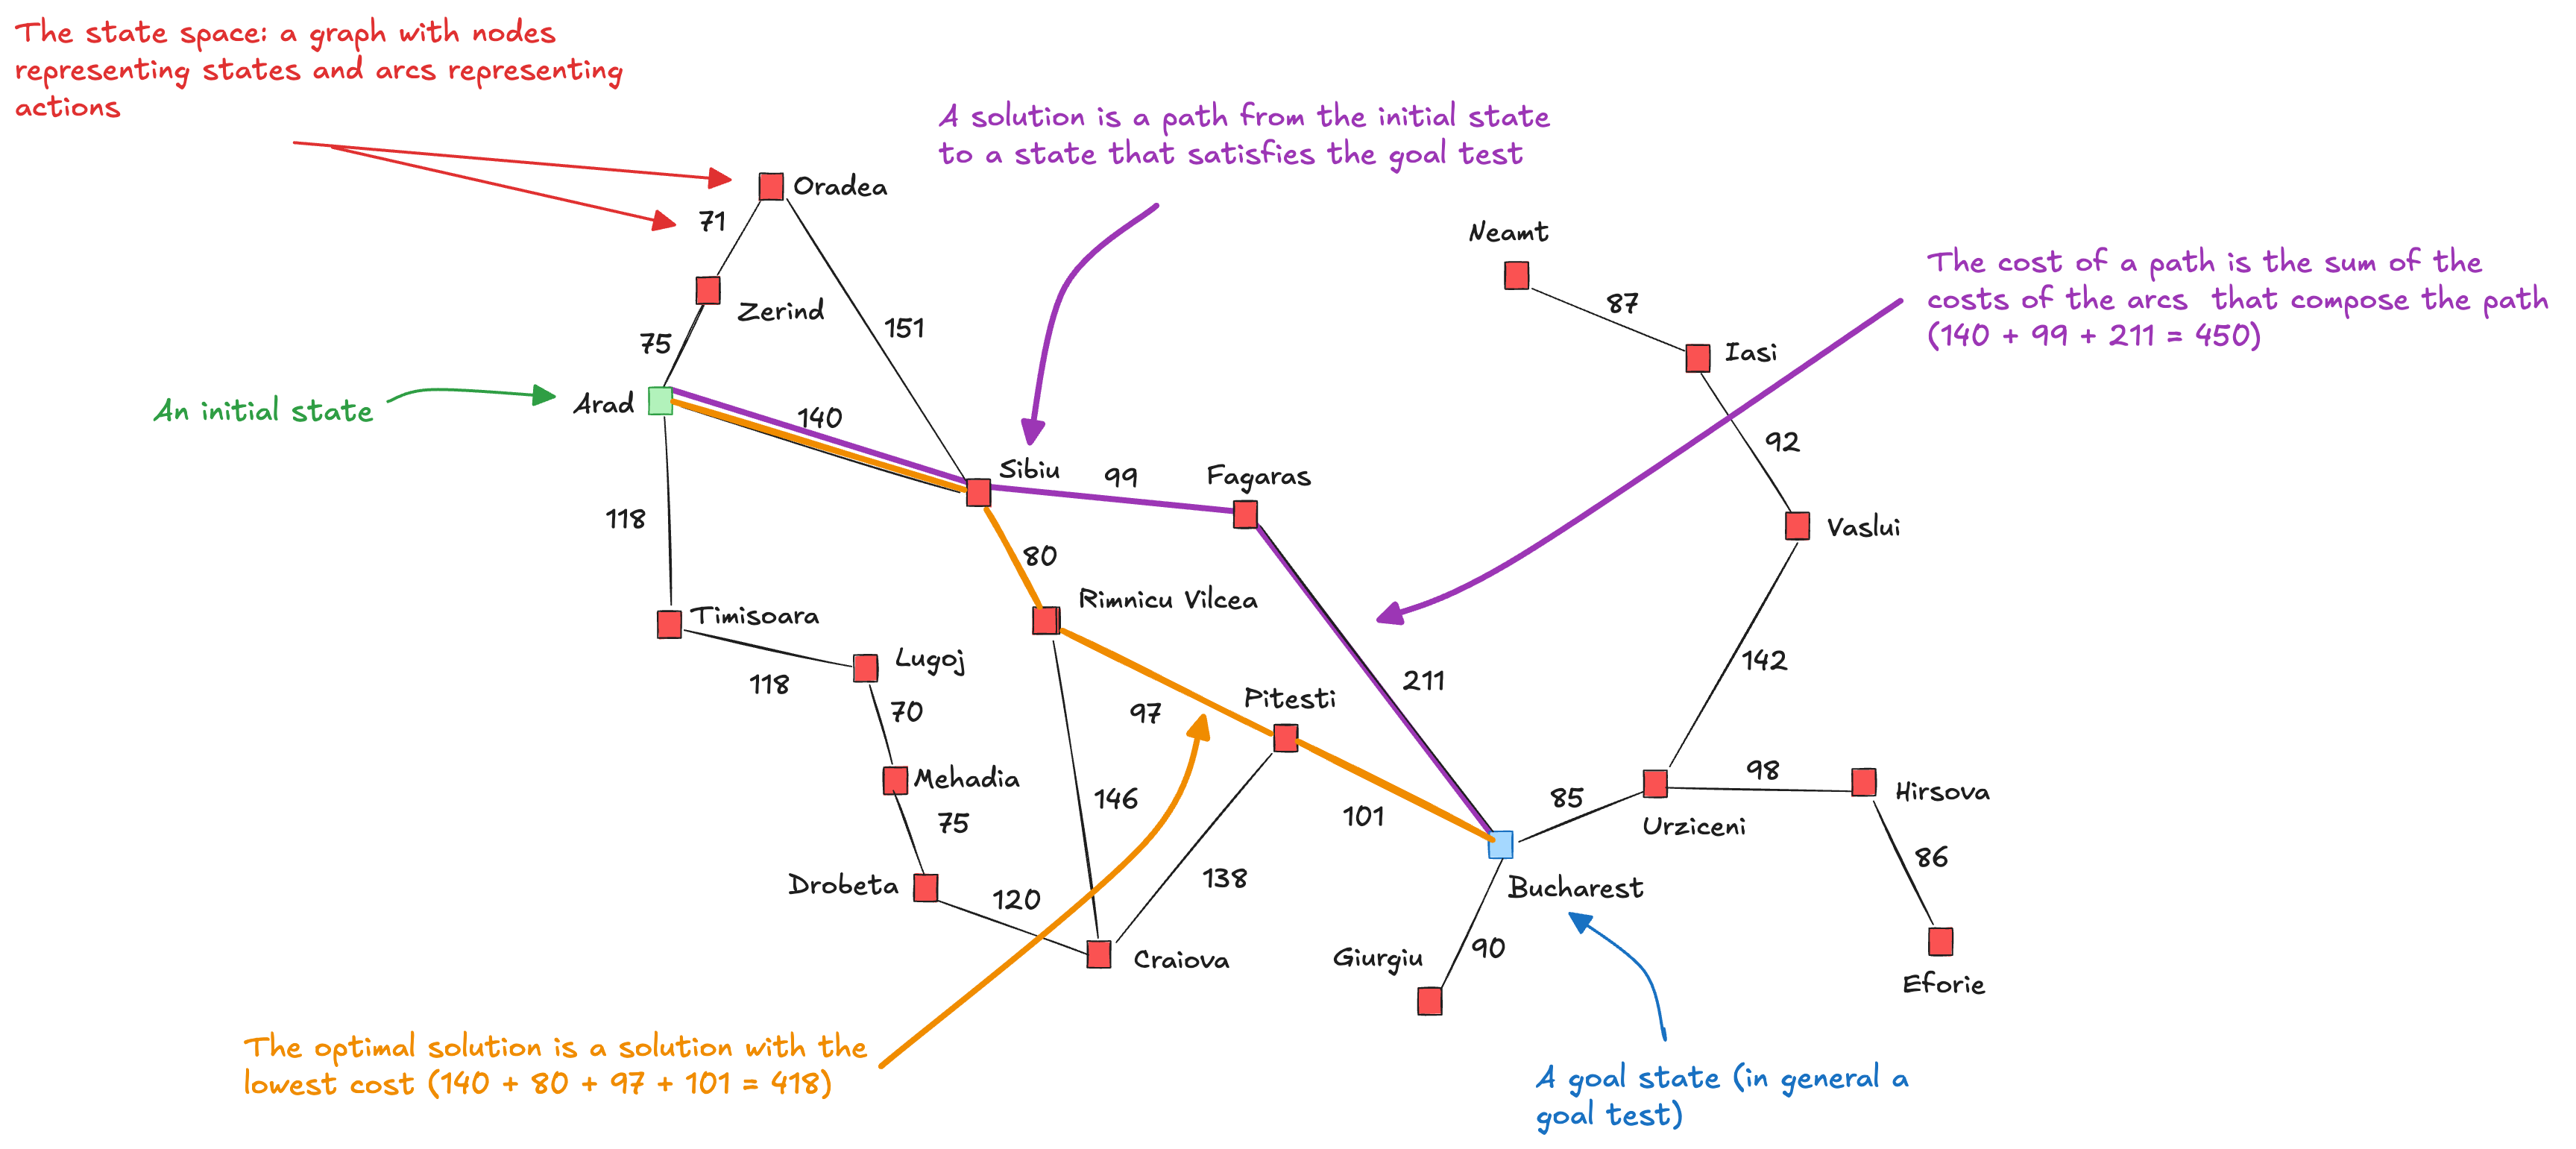

This problem formulation is an **abstract model**, not a reflection of reality. For example, the simple state "Arad" omits many real-world factors, such as traveling companions, weather, and traffic, which are deemed **irrelevant** for finding a route to Bucharest. The process of simplifying a representation is called **abstraction**, and a good problem formulation strikes the right **level of abstraction**. If actions were overly detailed, like "move the right foot forward a centimeter", the agent would struggle to solve the problem. The abstraction is valid if any abstract solution can be mapped to a feasible detailed solution. For example, driving from "Arad" to "Sibiu" don't require any additional planning. A good abstraction **removes unnecessary detail while ensuring actions remain simple and valid**. Without useful abstractions, intelligent agents would be overwhelmed by complexity We can implment the search problem where the information are given as a graph:

In [97]:
class GraphProblem(Problem):
    """The problem of searching a graph from one node to another."""

    def __init__(self, graph, initial, goal):
        super().__init__(initial, goal)
        self.graph = graph

    def actions(self, action):
        """The actions at a graph node are just its neighbors."""
        return list(self.graph.get(action).keys())

    def result(self, state, action):
        """The result of going to a neighbor is just that neighbor."""
        return action
    
    def goal_test(self, state):
        """Return True if the state is a goal."""
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal

    def path_cost(self, cost_so_far, A, action, B):
        return cost_so_far + (self.graph.get(A, B) or np.inf)

So the problem of searching a path from Arad to Bucharest on the Romania map can be expresssed as:

In [98]:
romania_problem = GraphProblem(romania_map, "Arad", "Bucharest")

## Problem  examples

We can design some **standardized problem** to showcase or test different problem-solving methods. With a clear and precise description, it serves as a **benchmark** for researchers to compare the performance of algorithms in real-world scenarios. We can then have real-world problems.

### Grid world

A **grid world problem** is a two-dimensional array of cells where agents can move horizontally, vertically, or sometimes diagonally between adjacent cells. Cells may contain objects that the agent can interact with, while walls or obstacles block movement. The vacuum cleaning world is an example of a grid world problem:

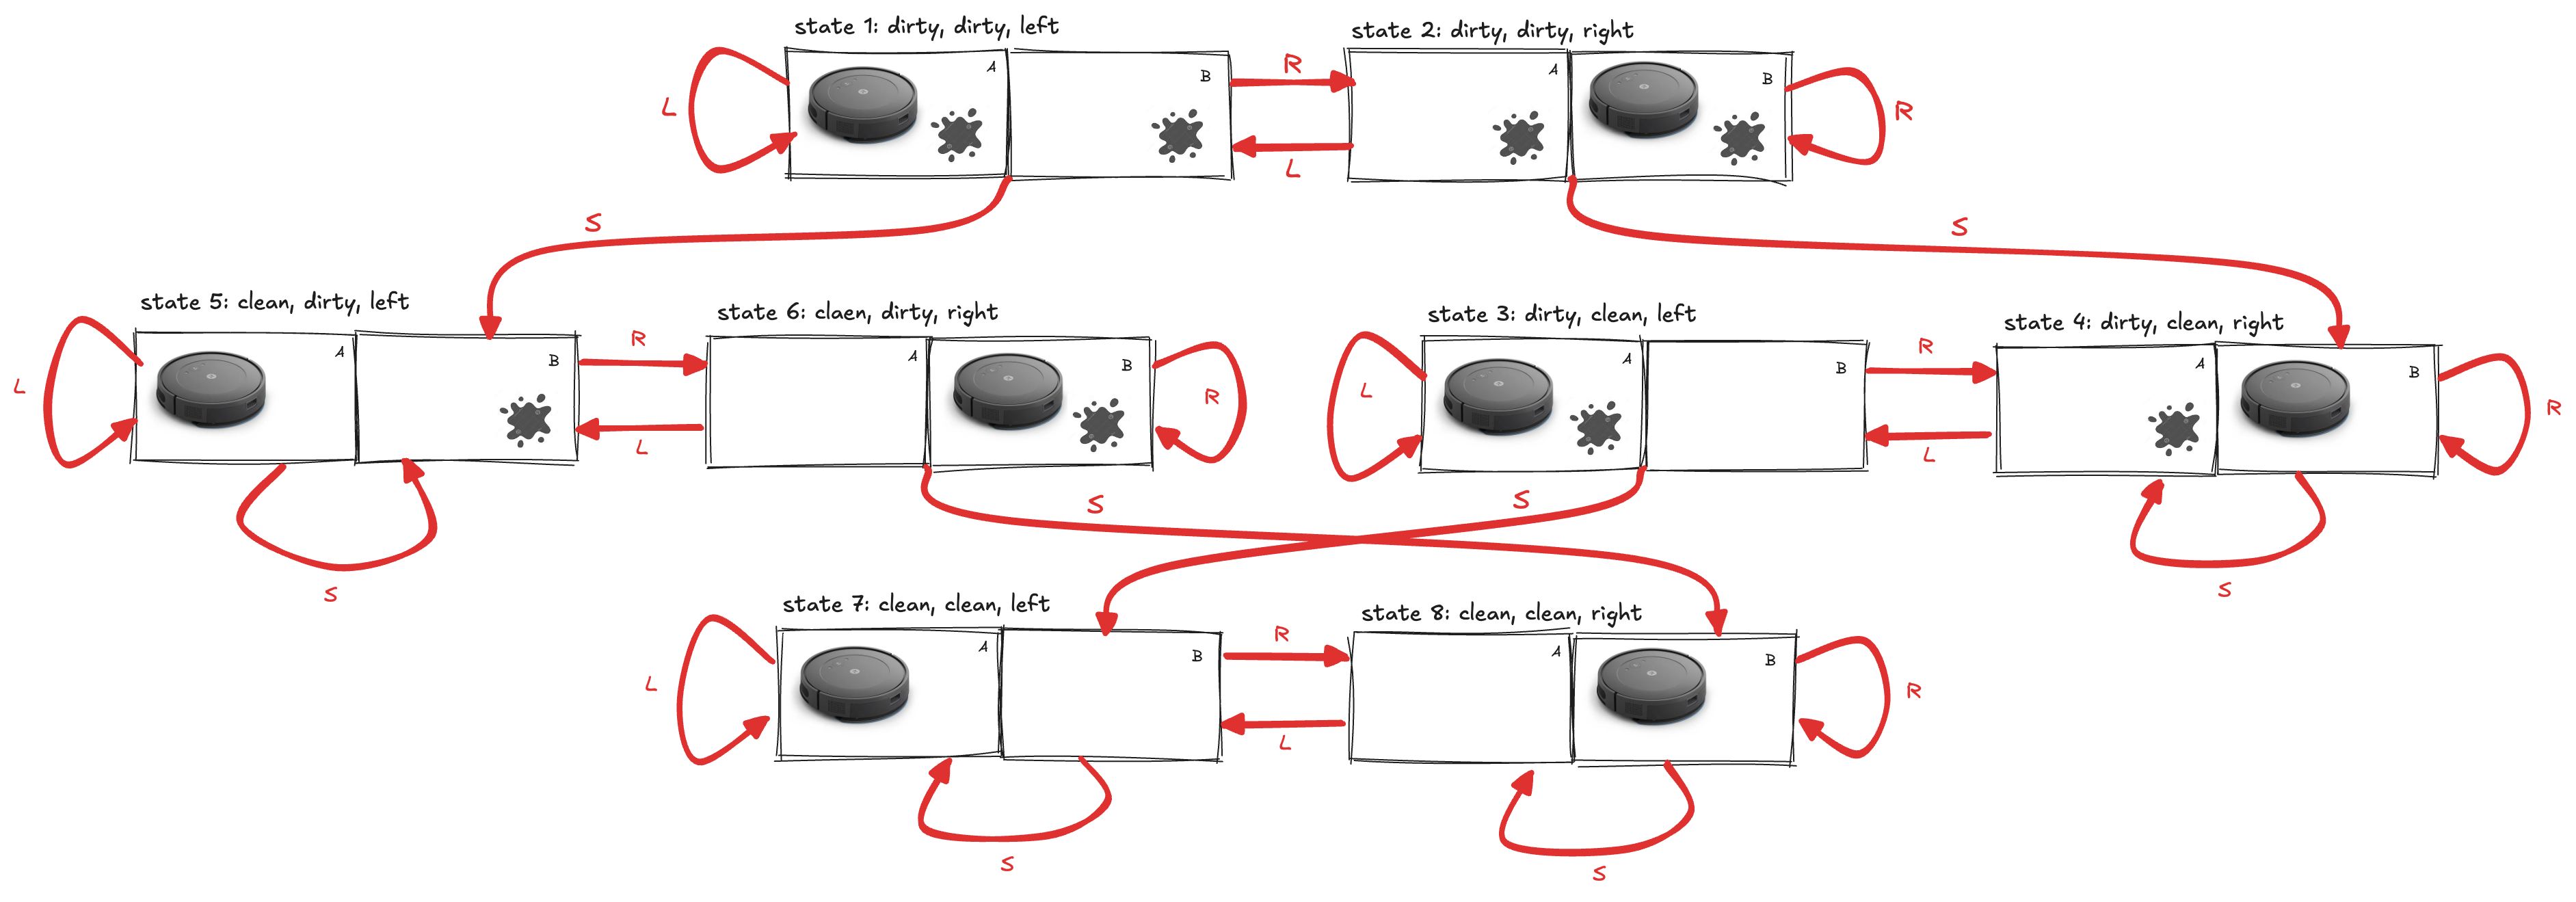

We can define the problem as follows:
- State space: a state specifies object locations, including the agent and dirt. In a two-cell world, the agent can be in either cell, and each cell may contain dirt, yielding 8 states. Generally, with \(N\) cells, there are \(N \times 2^N\) states.  
- Initial state: any state.  
- Actions: auck, move left, and move right. In a 2D grid, additional moves (up/down) are needed.  
- Transition model: sauck removes dirt; movement shifts the agent unless blocked by a wall.  
- Goal function: all cells are clean  
- Cost function: each action costs 1

The problem can be explicitly defined using a grpah structure:

In [99]:
vacuum_world = Graph(dict(
    State_1=dict(Suck=['State_5'], Left=['State_1'], Right=['State_2']),
    State_2=dict(Suck=['State_4'], Left=['State_1'], Right=['State_2']),
    State_3=dict(Suck=['State_7'], Left=['State_3'], Right=['State_4']),
    State_4=dict(Suck=['State_4'], Left=['State_3'], Right=['State_4']),
    State_5=dict(Suck=['State_5'], Left=['State_5'], Right=['State_6']),
    State_6=dict(Suck=['State_8'], Left=['State_5'], Right=['State_6']),
    State_7=dict(Suck=['State_7'], Left=['State_7'], Right=['State_8']),
    State_8=dict(Suck=['State_8'], Left=['State_7'], Right=['State_8'])
))

vacuum_problem = GraphProblem(vacuum_world, "State_1", "State_7")

### Sliding-tile puzzle

Another type of grid world is the **sliding-tile puzzle**, where a several numberd tiles (e.g. 8, 15) are arranged in a grid (e.g. 3x3, 4X4) with one blank space so that some of the tiles can slide into the blank space. The goal is to reach a ordered configuration of the tiles from a given initial configuration:

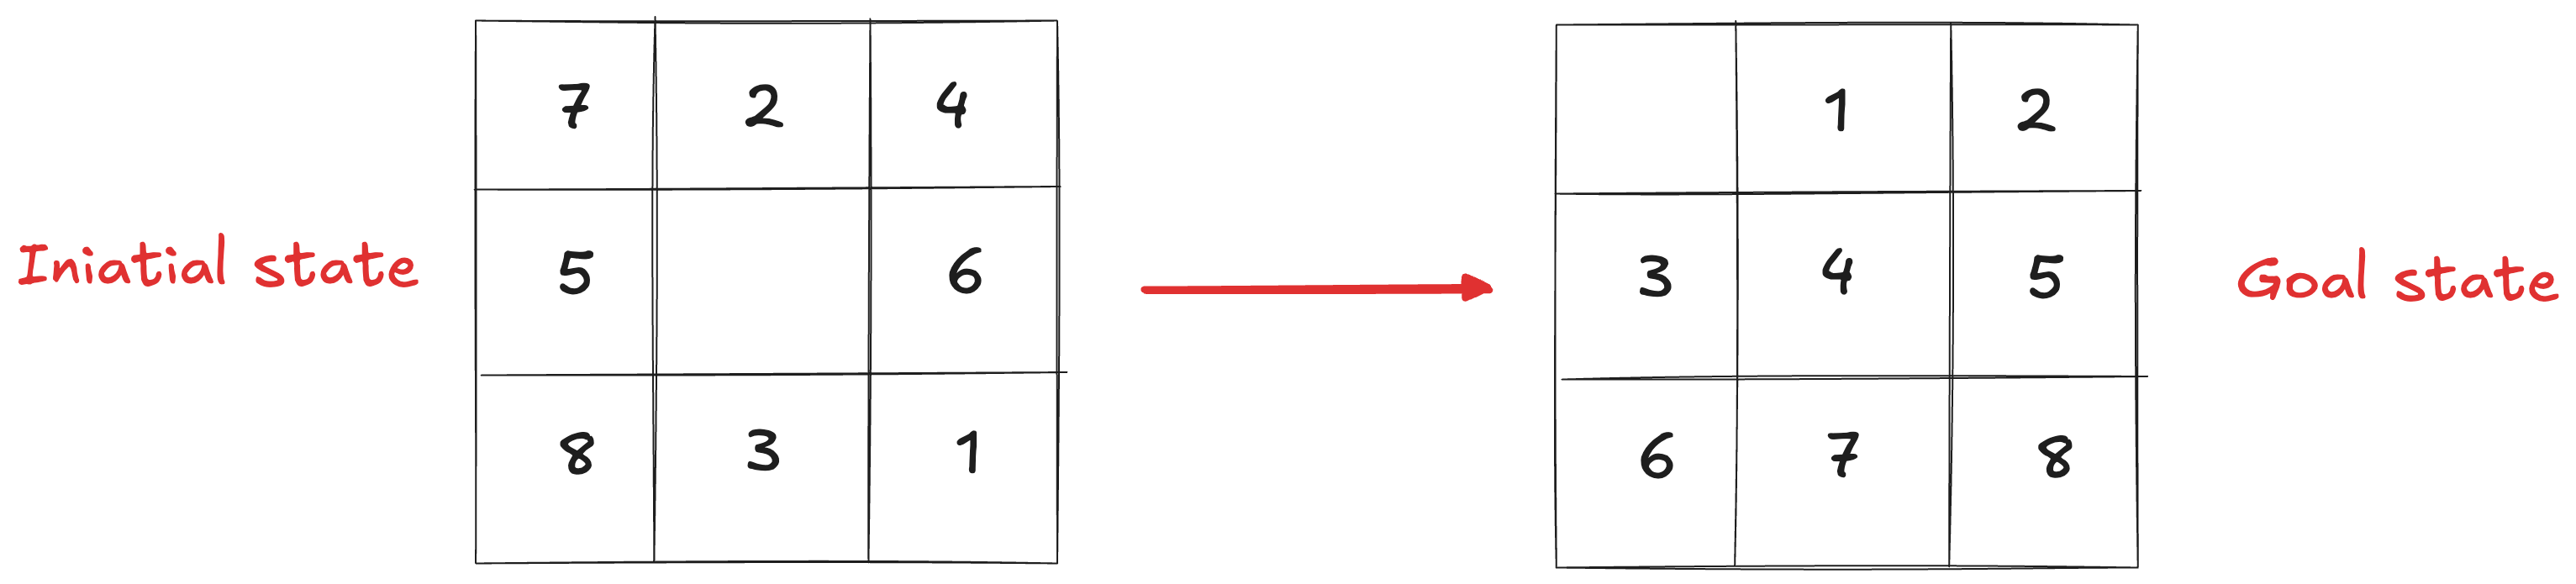

We can define the problem as follows:
- State space: defines the location of each tile.  
- Initial state: any state can be the starting point.  
- Actions: the blank space moves left, right, up, or down, unless blocked by an edge or corner.  
- Transition model: maps a state and action to a new state (e.g., moving left swaps the blank with the adjacent tile).  
- Goal test tiles arranged in numerical order.  
- Cost function: each action costs 1.

In that case, altought it is possible to represent the problem explicitly creating a graph, it is more convinient and efficient an implicit representation that consider the position of the blank space:

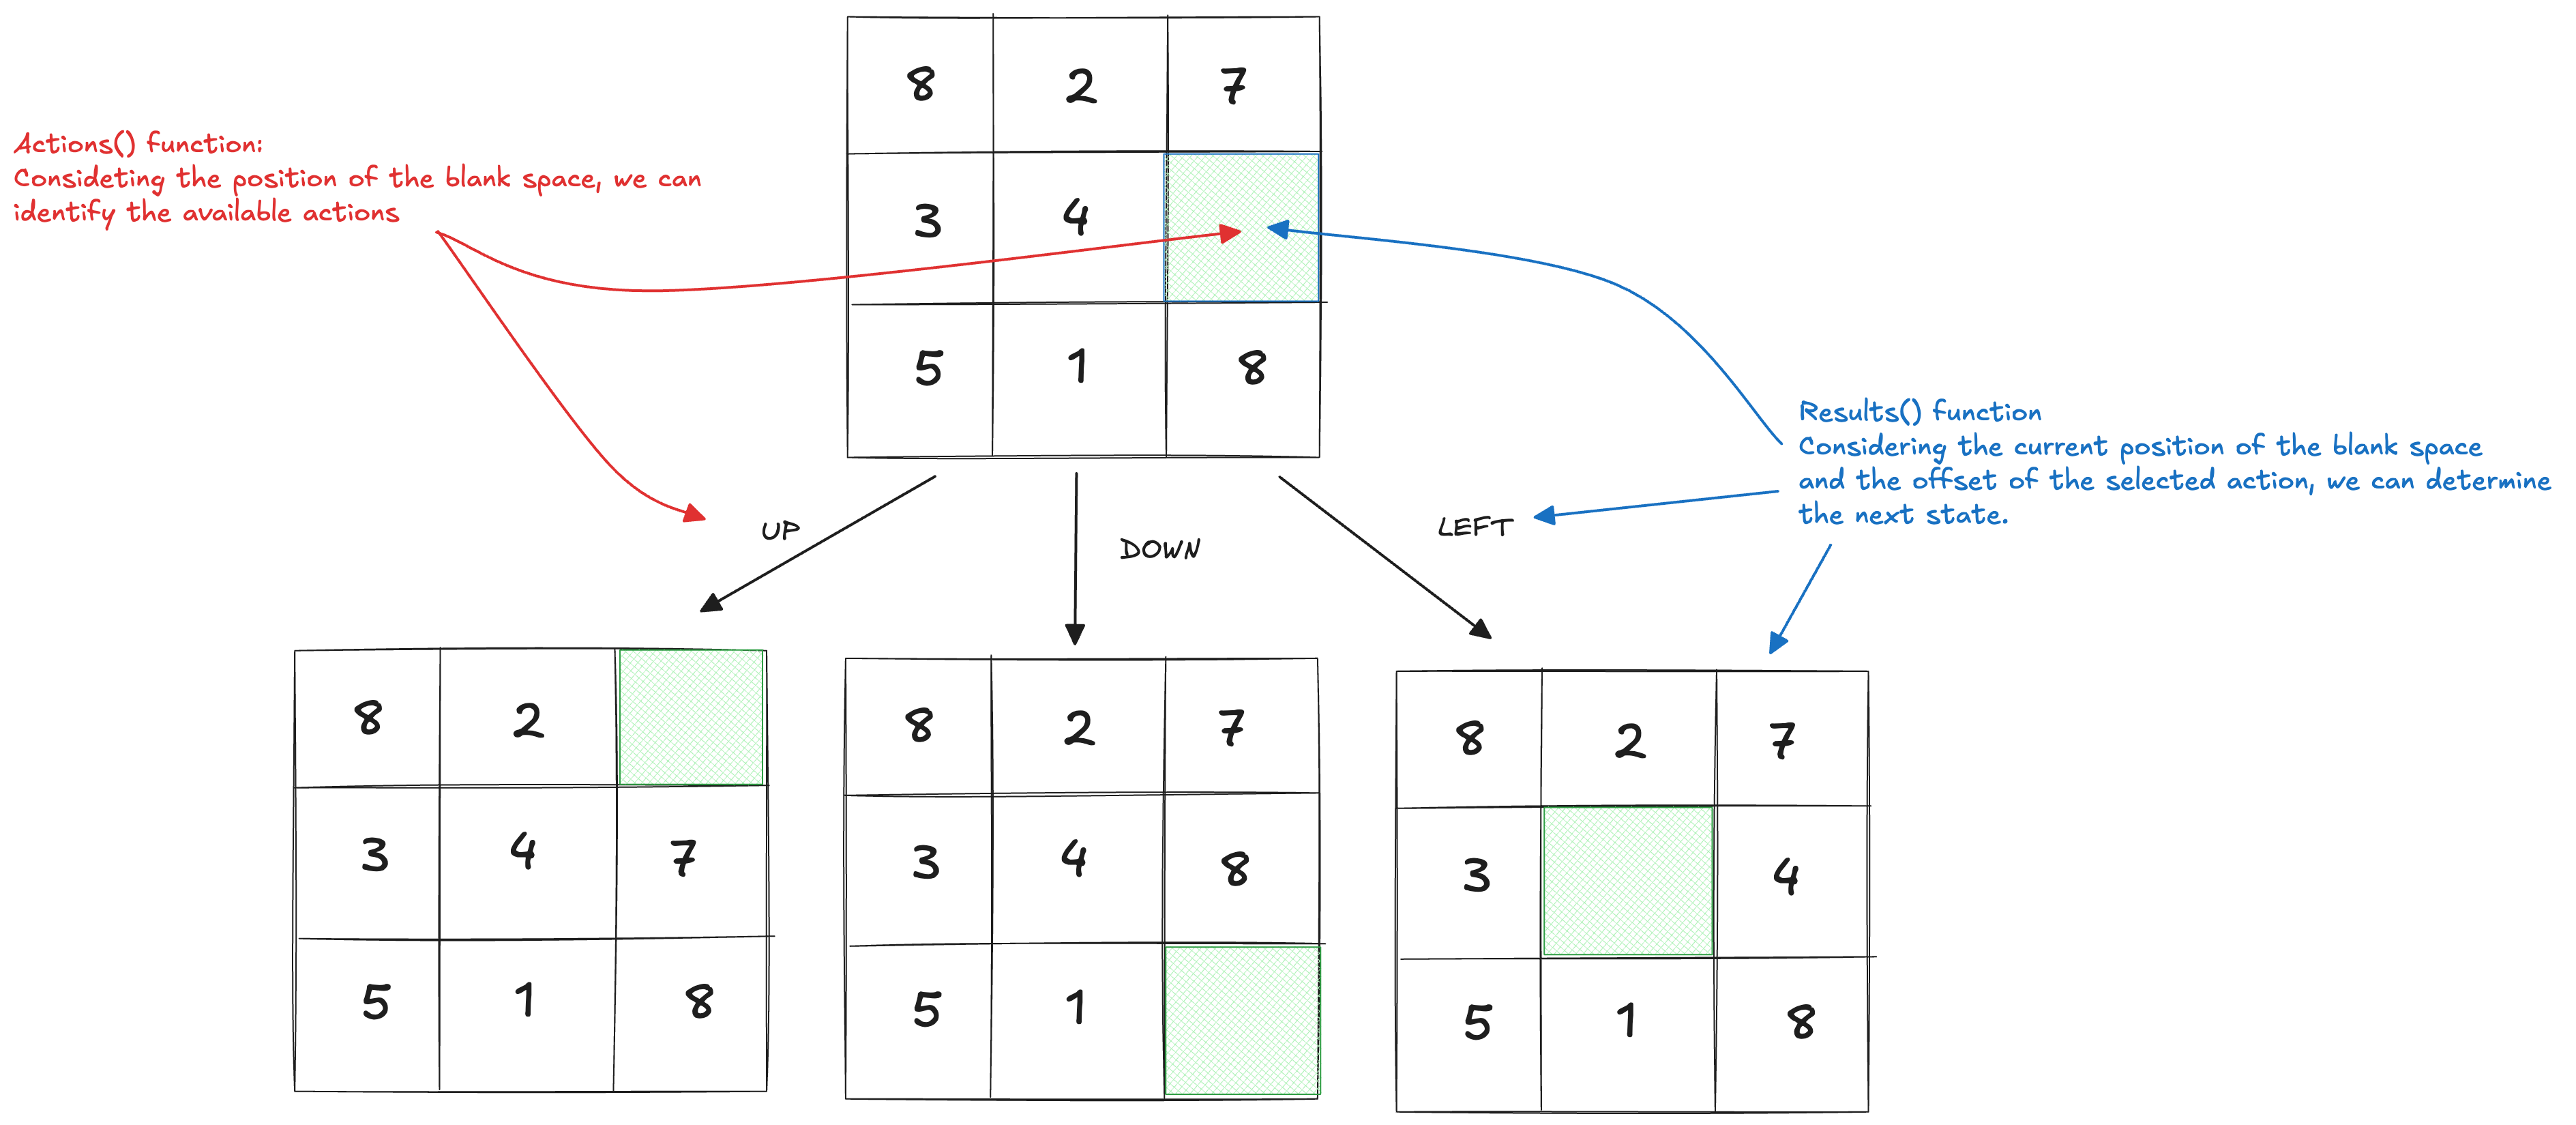

In [100]:
class EightPuzzle(Problem):

    def __init__(self, initial, goal=(1, 2, 3, 4, 5, 6, 7, 8, 0)):
        super().__init__(initial, goal)

    def find_blank_square(self, state):
        return state.index(0)

    def actions(self, state):
        # All possible actions
        possible_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']

        # Restrict actions based on blank tile position
        index_blank_square = self.find_blank_square(state)
        if index_blank_square % 3 == 0:
            possible_actions.remove('LEFT')
        if index_blank_square < 3:
            possible_actions.remove('UP')
        if index_blank_square % 3 == 2:
            possible_actions.remove('RIGHT')
        if index_blank_square > 5:
            possible_actions.remove('DOWN')
            
        return possible_actions

    def result(self, state, action):

        # Find the blank tile index
        blank = self.find_blank_square(state)

        # Convert to list for mutability
        new_state = list(state)

        # Define movement shifts based on action
        delta = {'UP': -3, 'DOWN': 3, 'LEFT': -1, 'RIGHT': 1}

        # Compute new blank position
        neighbor = blank + delta[action]

        # Swap blank tile with its neighbor
        new_state[blank], new_state[neighbor] = new_state[neighbor], new_state[blank]

        # Convert back to tuple (immutable state representation)
        return tuple(new_state)

    def goal_test(self, state):
        return state == self.goal

    def path_cost(self, c, state1, action, state2):
        return c + 1

Notice that every problem formulation includes abstractions. In the 8-puzzle, actions are defined by start and end positions, ignoring the tile's movement. We exclude actions like shaking the board or manually repositioning tiles, focusing only on rule-based moves.

### Eight-queens puzzle

The **eight-queens puzzle** is a combinatorial problem that requires placing **eight queens** on an **8×8 chessboard** so that no two queens attack each other, meaning no two queens share the same **row, column, or diagonal**:

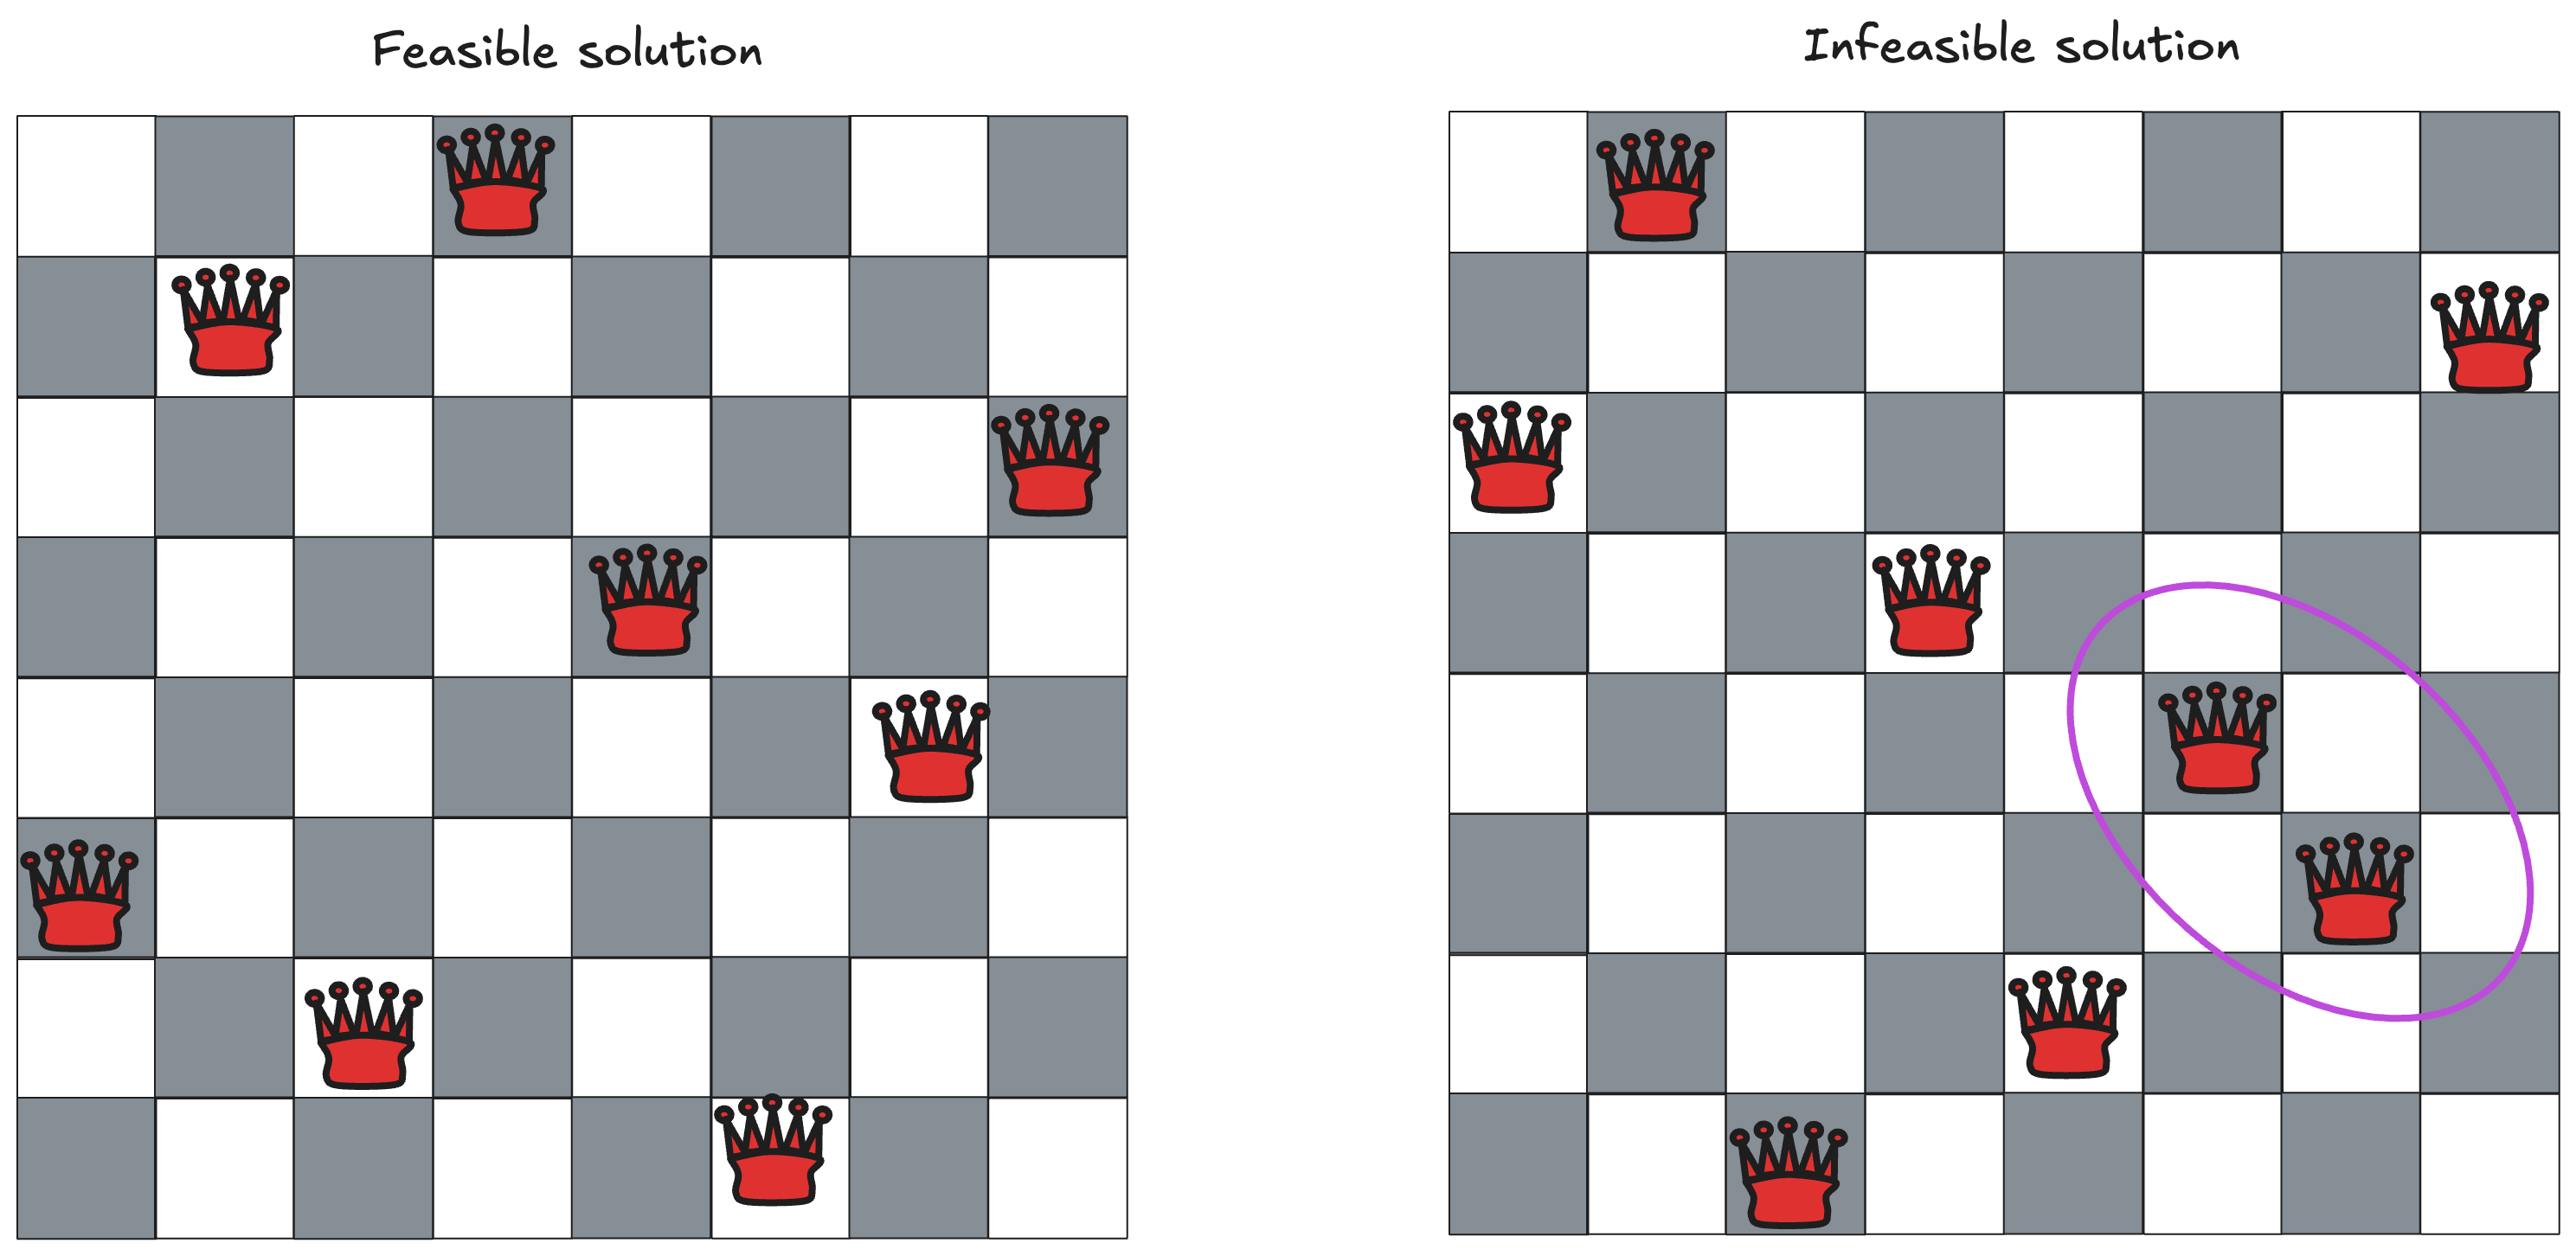

The problem can be defined as follows:  

- State space: all possible placements of 0 to 8 queens on the board, totaling approximately 1.8*10^14 states (64x63x...x57). A state is represented as an N-element array, where a value of r in the c entry means there is a queen at column c, row r, and a value of -1 means that the c column has not been filled in yet 
- Initial state: an empty chessboard. The initial state is an array with -1 in all entries. 
- Actions: placing a queen in a column that does not already have one . 
- Transition model: places a queen in the next available row of the column.  
- Goal test: checks that no two queens are in the same row, column, or diagonal.  
- Cost function: each action has a uniform cost of 1 (though this is irrelevant in this context).  

Let's implement the problem in Python:

In [101]:
class NQueensProblem(Problem):
    """The problem of placing N queens on an NxN board with none attacking each other."""

    def __init__(self, N):
        super().__init__(tuple([-1] * N))
        self.N = N

    def actions(self, state):
        """In the leftmost empty column, try all non-conflicting rows."""
        if state[-1] != -1:
            return []  # All columns filled; no successors
        else:
            col = state.index(-1)
            return [row for row in range(self.N)
                    if not self.conflicted(state, row, col)]

    def result(self, state, row):
        """Place the next queen at the given row."""
        col = state.index(-1)
        new = list(state[:])
        new[col] = row
        return tuple(new)
    
    def conflict(self, row1, col1, row2, col2):
        """Would putting two queens in (row1, col1) and (row2, col2) conflict?"""
        return (row1 == row2 or  # same row
                col1 == col2 or  # same column
                row1 - col1 == row2 - col2 or  # same \ diagonal
                row1 + col1 == row2 + col2)  # same / diagonal

    def conflicted(self, state, row, col):
        """Would placing a queen at (row, col) conflict with anything?"""
        return any(self.conflict(row, col, state[c], c)
                   for c in range(col))

    def goal_test(self, state):
        """Check if all columns filled, no conflicts."""
        if state[-1] == -1:
            return False
        return not any(self.conflicted(state, state[col], col)
                       for col in range(len(state)))
    
    def path_cost(self, c, state1, action, state2):
        return c + 1

### Real-world problems

Many real-world problems can be framed as search tasks. From navigation systems to robotics and circuit design, efficient algorithms help find optimal solutions while managing complexity and constraints. Here some examples: 

- **Route-finding** problems involve navigating between specified locations via defined paths. Applications range from simple GPS navigation to complex scenarios like traffic-aware routing, military logistics, and airline travel planning, where factors like delays, rerouting, and fare structures add complexity.  

- **Touring problems** require visiting multiple locations instead of reaching a single goal. The **Traveling Salesperson Problem (TSP)** seeks the shortest possible tour covering all cities. Optimized TSP algorithms are widely used in logistics, including vehicle routing and supply chain management.  

- **VLSI layout** optimization positions millions of components on a chip to minimize space, circuit delays, and interference. The process is divided into **cell layout**, which arranges functional blocks, and **channel routing**, which determines wire connections between them.  

- **Robot navigation** generalizes route-finding by allowing movement in continuous space rather than fixed paths. Controlling robotic limbs adds complexity, turning the problem into a high-dimensional search. Real-world robots must also handle sensor errors, partial observability, and dynamic environments.  

- **Automatic assembly** sequencing determines the optimal order for assembling complex objects, such as electric motors, reducing costs and production time. A key challenge is ensuring feasibility at each step while avoiding redundant searches. A specialized case is **protein design**, where algorithms search for amino acid sequences that fold into functional proteins, with potential applications in medicine.

## Search Trees

A **search algorithm** takes a problem as input and returns either a solution or failure. Solutions are found by building a **search tree over the space state graph**, and exploring paths from the initial state to a goal. In the treen, each **node represents a path from the initial state to another state**, with **edges corresponding to actions**. The **root node** represents the initial state. **Expanding** a node involves applying available actions, using the result function to determine the resulting states, and generating **child nodes** (or **successors**). The algorithm then selects the next node to explore. We can define the **frontier** as the set of nodes that have been reached but not yet expanded. We can define **depth** of a node as the number of edges from the root to the node. The figure illustrates the initial steps in finding a path from Arad to Bucharest.

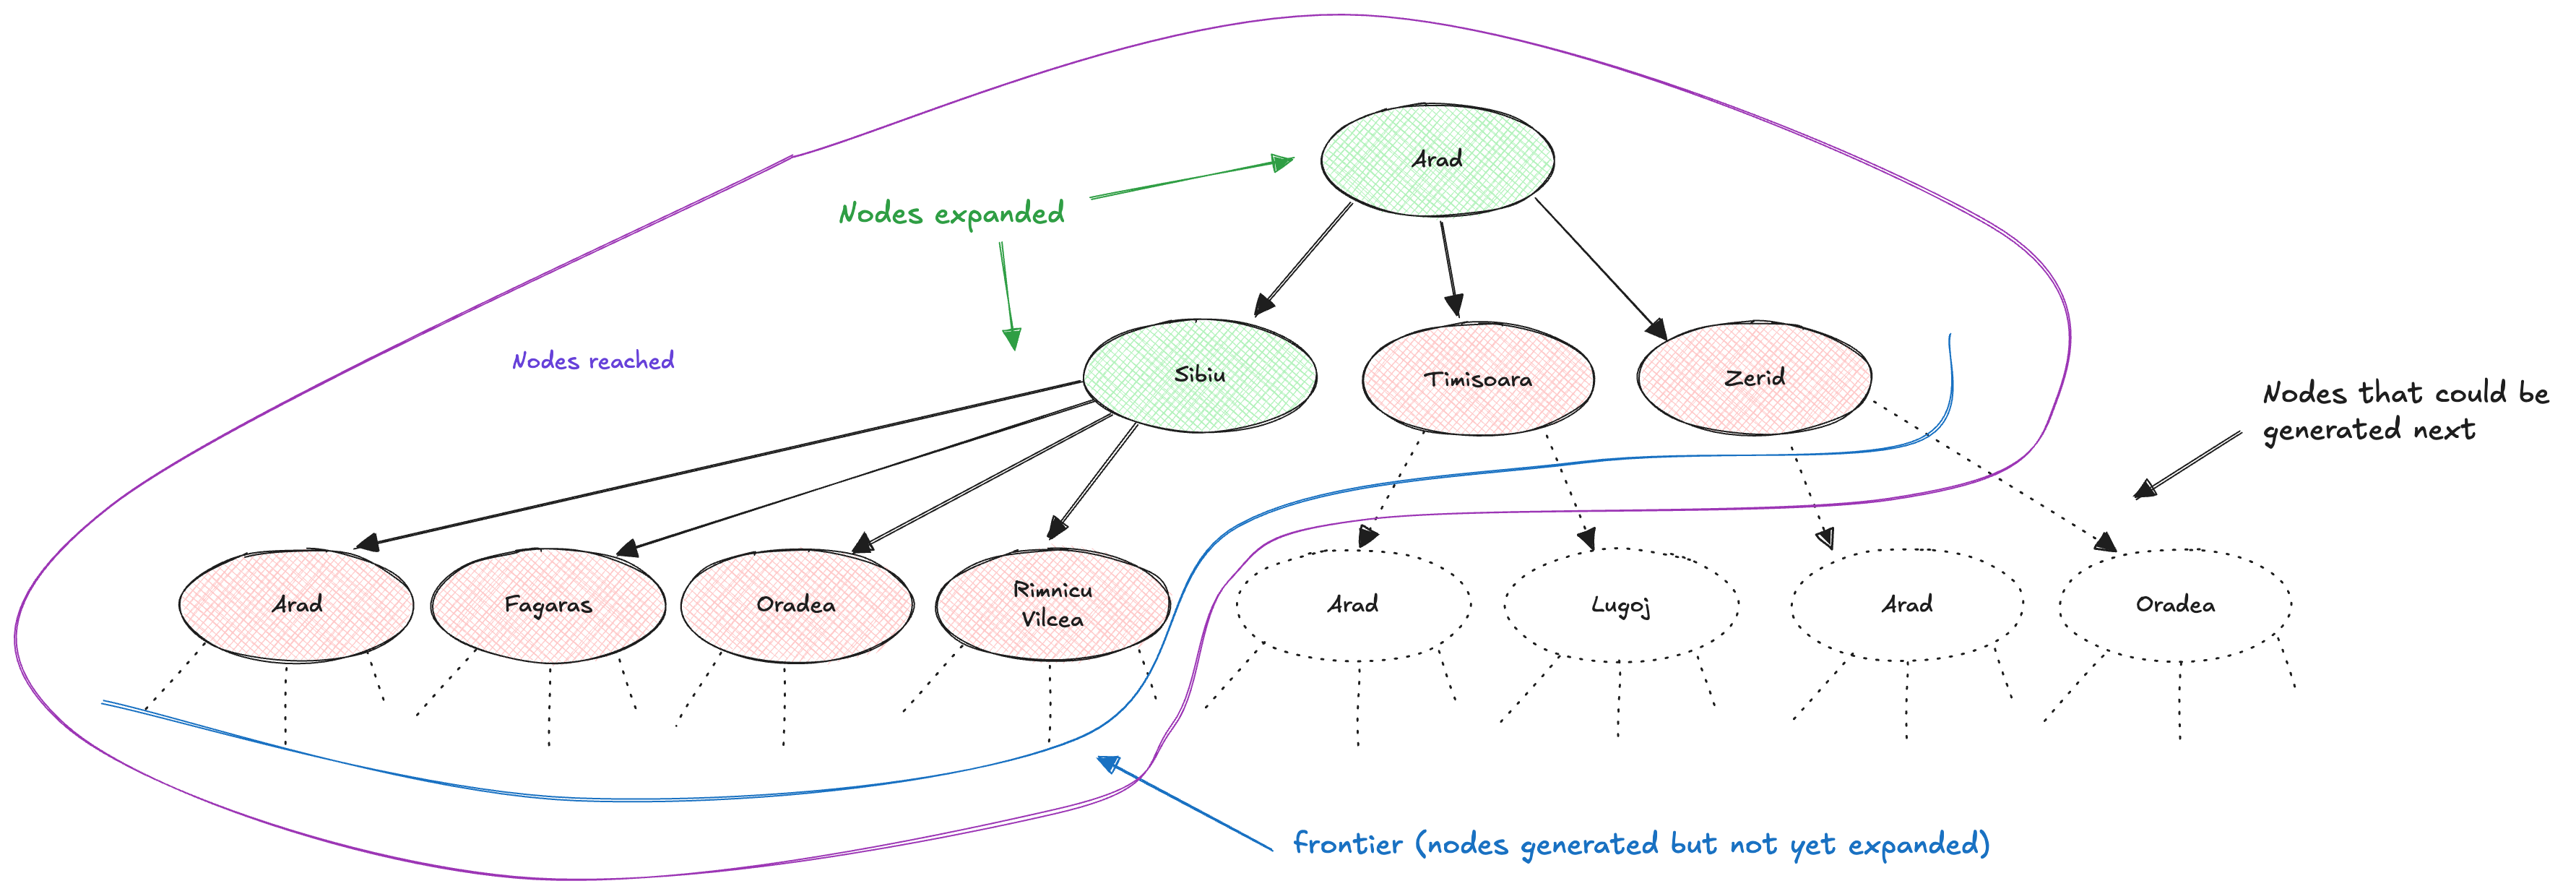

It is crucial to distinguish between the state space and the search tree. The **state space** encompasses all possible states and transitions within a given problem, while the **search tree** represents the exploration of different paths toward the goal. A single state in the state space may correspond to multiple nodes in the search tree if it can be reached via different paths from the initial state. If states can be revisited multiple times, the search tree may become infinite, even when the state space itself is finite.

We can consider the tree superimposed on the state-space graph:

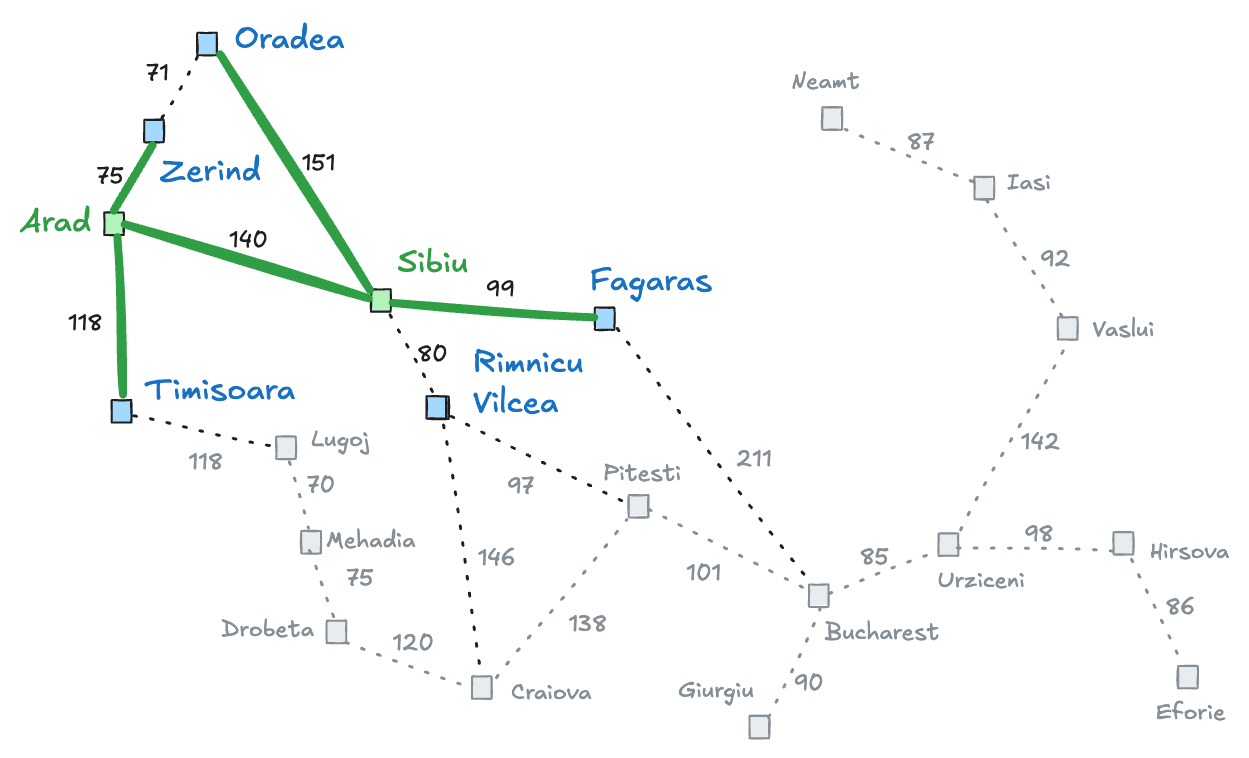

Notice that the frontier separates two regions of the state-space graph: an **interior region** where every state has been expanded, and an **exterior region** of states that have not yet been reached. We can show this property on a rectangular-grid problem:

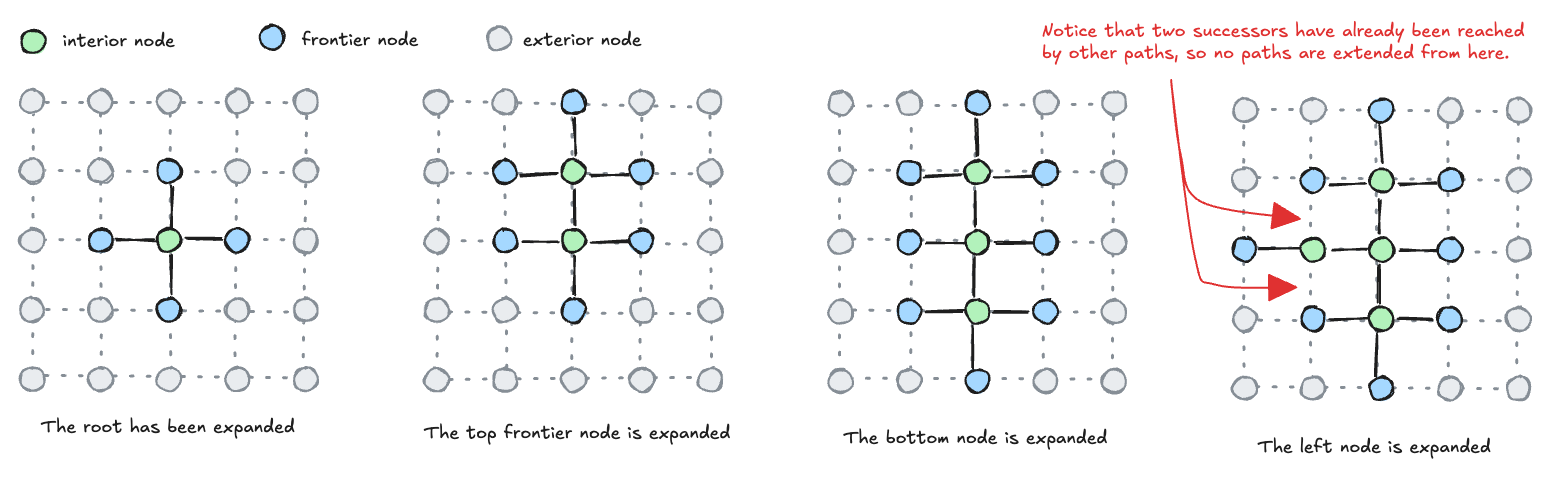

A **search algorithm** manages the frontier, expanding nodes and updating it until a goal state is found. It must also handle **repeated states**, which occur when the same state is reached via different paths. For instance, traveling from Arad to Sibiu and back to Arad forms a **cycle**, making the search tree **infinite** despite a limited state space. More generally, a **redundant path** is an inefficient way to reach the same state, such as taking Arad–Zerind–Oradea–Sibiu (297 miles) instead of Arad–Sibiu (140 miles). There are three ways to handle this:  

- **Track all reached states**, keeping only the best path to each. This is ideal for highly redundant state spaces when memory allows. In this case, the algorithm is called a **graph search**. 
- **Ignore repeats**, leading to a **tree-like search** that may explore redundant paths which avoids them. "Like" because the state space remains a graph, but we choose to treat it as a tree.  
- **Detect cycles only**, using parent pointers to check if a state reappears in its path, requiring no extra memory.

### Measuring performance
 
A search algorithm can be evaluated based on several key criteria.

- **Completeness**: does the algorithm always find a solution when one exists and correctly report failure when none exists? A complete algorithm must systematically explore all reachable states. In finite state spaces, this is straightforward by tracking paths and avoiding cycles. In infinite state spaces, an algorithm must ensure **systematic** exploration, such as using a spiral pattern in a grid. For example, in an infinite grid with no obstacles, moving straight creates an infinite path without revisiting states, but the search is incomplete as many areas remain unexplored. A systematic approach ensures completeness by covering all cells n steps from the origin before expanding to n+1 steps. However, if no solution exists in an infinite space, a complete algorithm must search indefinitely.  

- **Optimality**: does the algorithm find the solution with the lowest path cost among all possible solutions?  

- **Time and space Complexity**: how long does it take to find a solution? This can be measured in execution time or in the number of states and actions considered. How much memory does the algorithm require? Complexity is typically analyzed based on the size of the state-space graph, represented as |V| (states) and |E| (edges). In explicit graphs, like a road map, this is straightforward But in many problems, the graph is represented only implicitly by the initial state, actions, and transition model and the complexity depends on factors such as **maximum path length**, and **branching factor** (number of successors per node).

But how many states does a typical problem have? In a toy example like the **Romania map**, there are only **20 states**, but for the **8-puzzle**, the number grows to **9! (362,880) states**, and in the **15-puzzle**, it reaches **16! (≈1.3 × 10¹²) states**. Even in seemingly simple examples, the state space can be enormous, making it essential to carefully consider space and time complexity. Consequently, it is **generally impossible to explicitly represent the entire state space**. Instead, a problem-solving agent must find a solution by exploring only a small fraction of it.

### Node structure

We need a data structure to represent a node in a tree, defined as a tuple containing several components. It includes the state associated with the node, the parent node from which it was generated, the action applied to the parent state to produce this node, the total cost (denoted as *g*) of the path from the initial state to this node, and the depth of the node in the tree: 

In [102]:
class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        """Initialize a node with a given state, parent, action, path cost, and depth."""
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost  
        self.depth = parent.depth + 1 if parent else 0  

    def child_node(self, action, problem):
        """Generate a child node for a given action."""
        next_state = problem.result(self.state, action)
        return Node(next_state, self, action, problem.path_cost(self.path_cost, self.state, action, next_state))
    
    def expand(self, problem):
        """List the nodes reachable in one step from this node."""
        return [self.child_node(action, problem) for action in problem.actions(self.state)]

    def path(self):
        """Return a list of nodes forming the path from the root to this node."""
        path_back = []
        node = self
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    def solution(self):
        """Return the sequence of actions to go from the root to this node."""
        return [n.action for n in self.path()][1:]

    # We want to be able to compare nodes

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state

    def __lt__(self, node):
        return self.state < node.state
    

To generate a child node, we apply a given action to the current node’s state, determine the resulting state, and compute the new path cost before creating and returning the new node (child_node() method). This process relies on the problem-specific result() and path_cost() functions. Expanding a node (expand() method) involves generating all possible child nodes based on the set of valid actions for the current state, which depends on the problem-specific actions() function. By tracing a node’s parent chain back to the root, we can reconstruct the sequence of states and actions leading to that node (path() methos). When applied to a goal node, this process yields the solution—the sequence of actions taken along the path (solution() method).

### Frontier and  reached states

We need a data structure to store the **frontier states**, and the most suitable choice is a **queue**, as the operations on the frontier typically involve: checking if it is empty, removing the top node, returning the top node, and inserting a new node. A common types of queue used in search algorithms is the **priority queue** whic pops the node with the minimum/maximum cost based on an evaluation function:

In [103]:
import heapq

class PriorityQueue:
    """A Queue in which the minimum (or maximum) element (as determined by f and order) is returned first."""

    def __init__(self, order='min', f=lambda x: x):
        self.heap = []
        if order == 'min':
            self.f = f
        else:
            self.f = lambda x: -f(x)

    def append(self, item):
        """Insert item at its correct position."""
        heapq.heappush(self.heap, (self.f(item), item))

    def extend(self, items):
        """Insert each item in items at its correct position."""
        for item in items:
            self.append(item)

    def pop(self):
        """Pop and return the item (with min or max f(x) value)
        depending on the order."""
        if self.heap:
            return heapq.heappop(self.heap)[1]
        else:
            raise Exception('Trying to pop from empty PriorityQueue.')

    def __len__(self):
        """Return current capacity of PriorityQueue."""
        return len(self.heap)

    def __contains__(self, key):
        """Return True if the key is in PriorityQueue."""
        return any([item == key for _, item in self.heap])

    def __getitem__(self, key):
        """Returns the first value associated with key in PriorityQueue."""
        for value, item in self.heap:
            if item == key:
                return value
        return None

    def __delitem__(self, key):
        """Delete the first occurrence of key."""
        try:
            del self.heap[[item == key for _, item in self.heap].index(True)]
        except ValueError:
            raise KeyError(str(key) + " is not in the priority queue")
        heapq.heapify(self.heap)

The **reached states** can be stored as a lookup table where each key is a state and each value is the node for that state. For example, we can use a set, which is a simple unordered collection of unique elements.

### Best-first search

A general approach for exploring a graph and selecting the next node to expand from the frontier is called **best-first search**. In this method, the node with the minimum value of a given **evaluation function** is chosen for expansion. The evaluation function is problem-specific and may include the path cost, the depth of the node, and a heuristic estimate of the remaining cost to reach the goal. The algorithm is defined as follows:

In [104]:
def best_first_graph_search(f, problem):
    """Search the nodes with the lowest f scores first."""

    # Create the initial node
    node = Node(problem.initial)

    # Create the reached states
    explored = set()

    # Create the frontier and add the initial node  
    frontier = PriorityQueue('min', f)
    frontier.append(node)

    # While the frontier is not empty
    while frontier:

        # Get the node with the highest priority
        node = frontier.pop()

        # Check if we reach the goal, in case return the path
        # and the numeber of explored states
        if problem.goal_test(node.state): 
            return node.solution(), explored

        # Add the state to the explored states
        explored.add(node.state)

        # Expand the node and add the children to the frontier
        for child in node.expand(problem):
            # Append the child to the frontier if it is 
            # not in the explored states or in the frontier
            if child.state not in explored and child not in frontier:
                frontier.append(child)
            # otherwise, if the child is in the frontier and 
            # has a lower f score, update the frontier
            elif child in frontier:
                if f(child) < frontier[child]:
                    del frontier[child]
                    frontier.append(child)

    # If the frontier is empty and we did not reach the goal, return None
    # there is no solution
    return None, explored


At each iteration, the algorithm selects the frontier node with the lowest evaluation value. If it is a goal, the path is returned; otherwise, the node is expanded. New child are added to the frontier unless already reached, in which case they are re-added only if a better path is found. The algorithm either finds a solution or fails. This is a graph search, as it tracks reached states. Removing this tracking results in a tree-like search, which uses less memory but explores redundant paths, making it slower.

## Uninformed Search Strategies

An **uninformed search** lacks any knowledge of how close a state is to the goal. For example, an agent in Arad trying to reach Bucharest, without knowledge of Romanian geography, cannot judge whether Zerind or Sibiu is a better first step. In contrast, an **informed search** uses knowledge, such as city locations, to prioritize moves—favoring Sibiu as it is closer to Bucharest. Uninformed search strategies are simpler and more general, but may be less efficient. Here are we consider some common uninformed search strategies.

### Breadth-first search

When all actions have the same cost, **breadth-first search** is an effective strategy. It expands the root first, then its successors, followed by their successors, one by one. This systematic approach ensures completeness, even in infinite state spaces. For example, in a binary tree, the search progresses level by level:

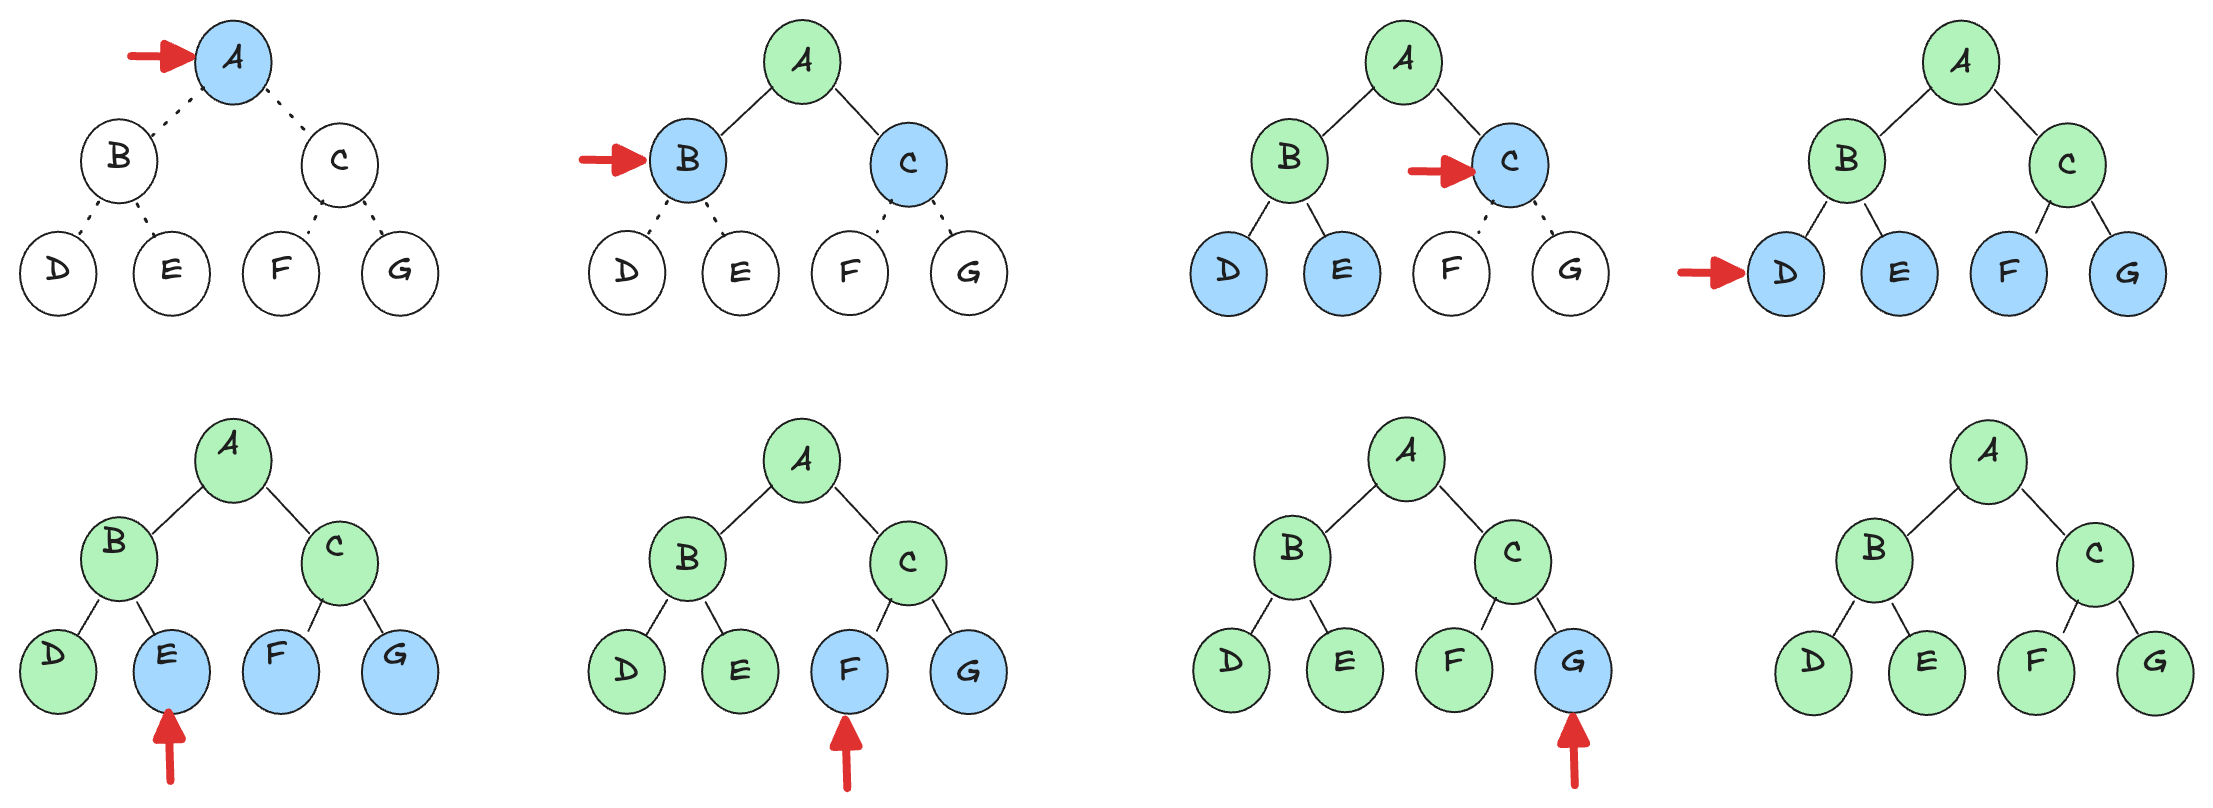

Breadth-first search can be seen as best-first search with an evaluation function based on node depth. However, it can be optimized with a **FIFO queue** instead of a priority queue. New nodes (which are always deeper than their parents) go to the back of the queue, and old nodes, which are shallower than the new nodes, get expanded first. We can perform an **early goal test**, checking if a node is a solution immediately upon generation, instead of waiting for the node to be popped from the queue:

In [105]:
from collections import deque
import sys

def breadth_first_graph_search(problem):
    
    # Create the initial node
    node = Node(problem.initial)

    # Add the node to the frontier    
    frontier = deque([node])

    # Create the explored states
    explored = set()

    # Early goal test
    if problem.goal_test(node.state):
        return node.solution(), explored

    # While the frontier is not empty
    while frontier:
        # Get the node from the frontier
        node = frontier.popleft()
        
        # Add the state to the explored states
        explored.add(node.state)

        # Print some info during the search
        sys.stdout.write(f"\rNumber of explored states: {len(explored)}")
        sys.stdout.flush()

        # Expand the node and add the children to the frontier
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                # Early goal test
                if problem.goal_test(child.state):
                    return child.solution(), explored
                # Add the child to the frontier    
                frontier.append(child)
                
    # If the frontier is empty and we did not reach the goal, return None            
    return None, explored

We can solve the Arad-Bucharest problem using breadth-first search:

In [108]:
solution, _ = breadth_first_graph_search(romania_problem)
print("\nActions to Bucharest: ", solution)

Number of explored states: 8
Path to Bucharest:  ['Sibiu', 'Fagaras', 'Bucharest']


In [109]:
puzzle = EightPuzzle((1, 2, 3, 
                      4, 5, 6, 
                      0, 7, 8))

solution, _ = breadth_first_graph_search(puzzle)
print("\nActions to the goal state: ", solution)

Number of explored states: 3
Path to the goal state:  ['RIGHT', 'RIGHT']


However, not all configurations of the 8-puzzle are solvable. In particular, it is possible to demonstrate that whether a configuration is solvable depends on a mathematical property called **parity**, which is determined by the number of inversions in the tile sequence. In that case, the algorithm has trouble finding a solution (that don't exist) and has to explore the entire state space. The following code may take some time to execute, depending on your hardware, proceed with caution:

In [110]:
puzzle = EightPuzzle((1, 2, 3, 
                      4, 5, 6, 
                      8, 7, 0))
                      
solution, _ = breadth_first_graph_search(puzzle)
print("\nActions to the goal state: ", solution)

Number of explored states: 181440
Path to the goal state:  None


Breadth-first search guarantees a solution with **a minimal number of actions**, because when it is generating nodes at depth d, it has already generated all the nodes at depth d−1, so if one of them were a solution, it would have been found. This makes it **optimal when all actions have the same cost**, but not in cases with varying costs (Indeed in the Romania problem it find a path with a minimum number of action, but not the optimal path in terms of cost). It remains **complete** regardless.  

In terms of time and space, imagine searching a uniform tree where every state has b successors. The root generates b nodes, each of which generates b more nodes, for a total of b^2 at the second level. Each of these generates b more nodes, yielding b^3 nodes at the third level, and so on. Now suppose that the solution is at depth d. Then the total number of nodes generated is:

$\displaystyle 1+b+b^2+b^3+· · ·+b^d = O(b^d)$

All the nodes remain in memory, so both time and space complexity are O(b^d). Exponential bounds like that are a problem. As a typical real-world example, consider a problem with branching factor b=10, processing speed 1 million nodes/second, and memory requirements of 1 KB/node. A search to depth d=10 would take less than 3 hours, but would require 10 TB of memory. The memory requirements are a bigger problem for breadth-first search than the execution time. But time is still an important factor. At depth d=14, even with infinite memory, the search would take 3.5 years. This scenario highlights how, in practical applications, such as the 8-puzzle, which can have many unsolvable configurations, the search space grows exponentially, rendering uninformed search strategies ineffective for anything but the smallest instances.

In general, **exponential-complexity search problems**, such as searching for a solution to a non-solvable 8-puzzle, cannot be efficiently tackled using uninformed search methods for most instances due to their extensive time and memory requirements.

As an exercise, we can try to solve the N-queens problem:

In [113]:
queens = NQueensProblem(8)

solution, _ = breadth_first_graph_search(queens)
print("\nActions to the goal state: ", solution)

Number of explored states: 1665
Path to the goal state:  [0, 4, 7, 5, 2, 6, 1, 3]


Verify on a chessboard whether this is a valid solution. However, is this the solution (a sequence of actions) we are looking for when solving problems like the 8-Queens puzzle?

### Uniform-cost algorithm

When actions have **different costs**, an obvious choice is to use best-first search where the evaluation function is the cost of the path from the root to the current node. This is called **uniform-cost algorithm** (or **Dijkstra’s search**). The idea is that while breadth-first search spreads out in waves of uniform depth (first depth 1, then depth 2, and so on), uniform-cost search spreads out in waves of uniform path-cost. Consider the following example to undestand the algorithm:

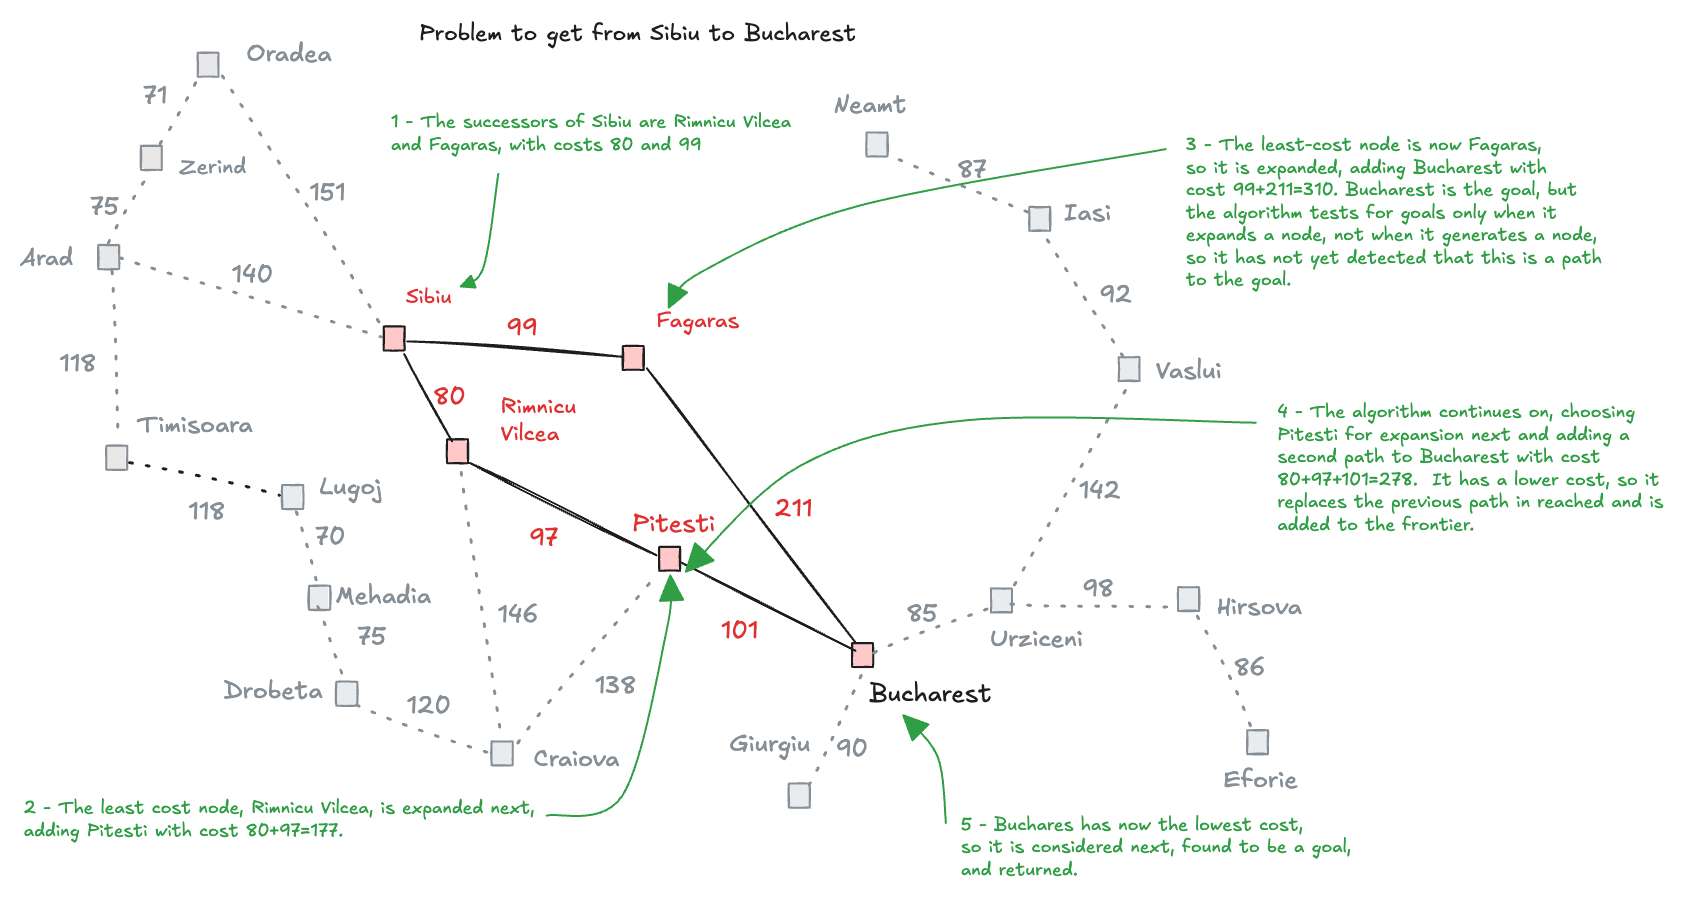

Note that if we had checked for a goal upon generating a node rather than when expanding the lowest-cost node, then we would have returned a higher-cost path. The algorithm can be implemented as a best-first with the path cost as the evaluation function:

In [114]:
def uniform_cost_search(problem):
    """Search the node of least total cost first."""
    return best_first_graph_search(lambda node: node.path_cost, problem)

We can run the algotithm on the Arad-Bucharest problem in order to see if it finds the optimal path:

In [117]:
solution, explored_nodes  = uniform_cost_search(romania_problem)

print("\nActions to the goal state: ", solution)
print("Explored states: ", explored_nodes) 


Path to the goal state:  ['Sibiu', 'Rimnicu Vilcea', 'Pitesti', 'Bucharest']
Explored states:  {'Timisoara', 'Mehadia', 'Drobeta', 'Arad', 'Rimnicu Vilcea', 'Fagaras', 'Craiova', 'Oradea', 'Lugoj', 'Pitesti', 'Sibiu', 'Zerind'}


Uniform-cost search expands nodes based on **cumulative path cost** rather than depth, ensuring **optimality** even when action costs vary. However, it may expand many **low-cost nodes** before reaching the goal. Let C be the optimal solution cost and $\epsilon > 0$ the smallest action cost. In the worst case, the search takes **smallest possible steps**, requiring at most:  

$\displaystyle d_{\max} = \frac{C}{\epsilon}$

Additionally, it explores the next level* of nodes before stopping, leading to a complexity of:

$\displaystyle O\left(b^{1 + \frac{C}{\epsilon} }\right)$

This can far exceed $O(b^d)$ because uniform-cost may explore large trees of **cheap actions** before considering **high-cost but useful** ones. When all actions have equal cost, it simplifies to $O(b^{d+1})$, behaving like breadth-first search. Despite its cost, the algorithm is **complete** (as long as all action costs are positive) and **optimal**, since it expands paths in increasing cost order, never getting trapped in an infinite sequence of low-cost actions.

### Depth-first search

Depth-first search always expands the deepest node in the frontier first and explores as far as possible along one branch before backtracking. The search then "backs up" to the next deepest node that still has unexpanded successors. It uses a last-in, first-out strategy, typically implemented with a stack. When expanding a node, it pushes all its successors onto the stack and continues with the most recently added node. If a dead-end is reached (i.e., a node with no unvisited successors), it backtracks to the last explored node with remaining paths. This process continues until a solution is found or all possible paths are exhausted:

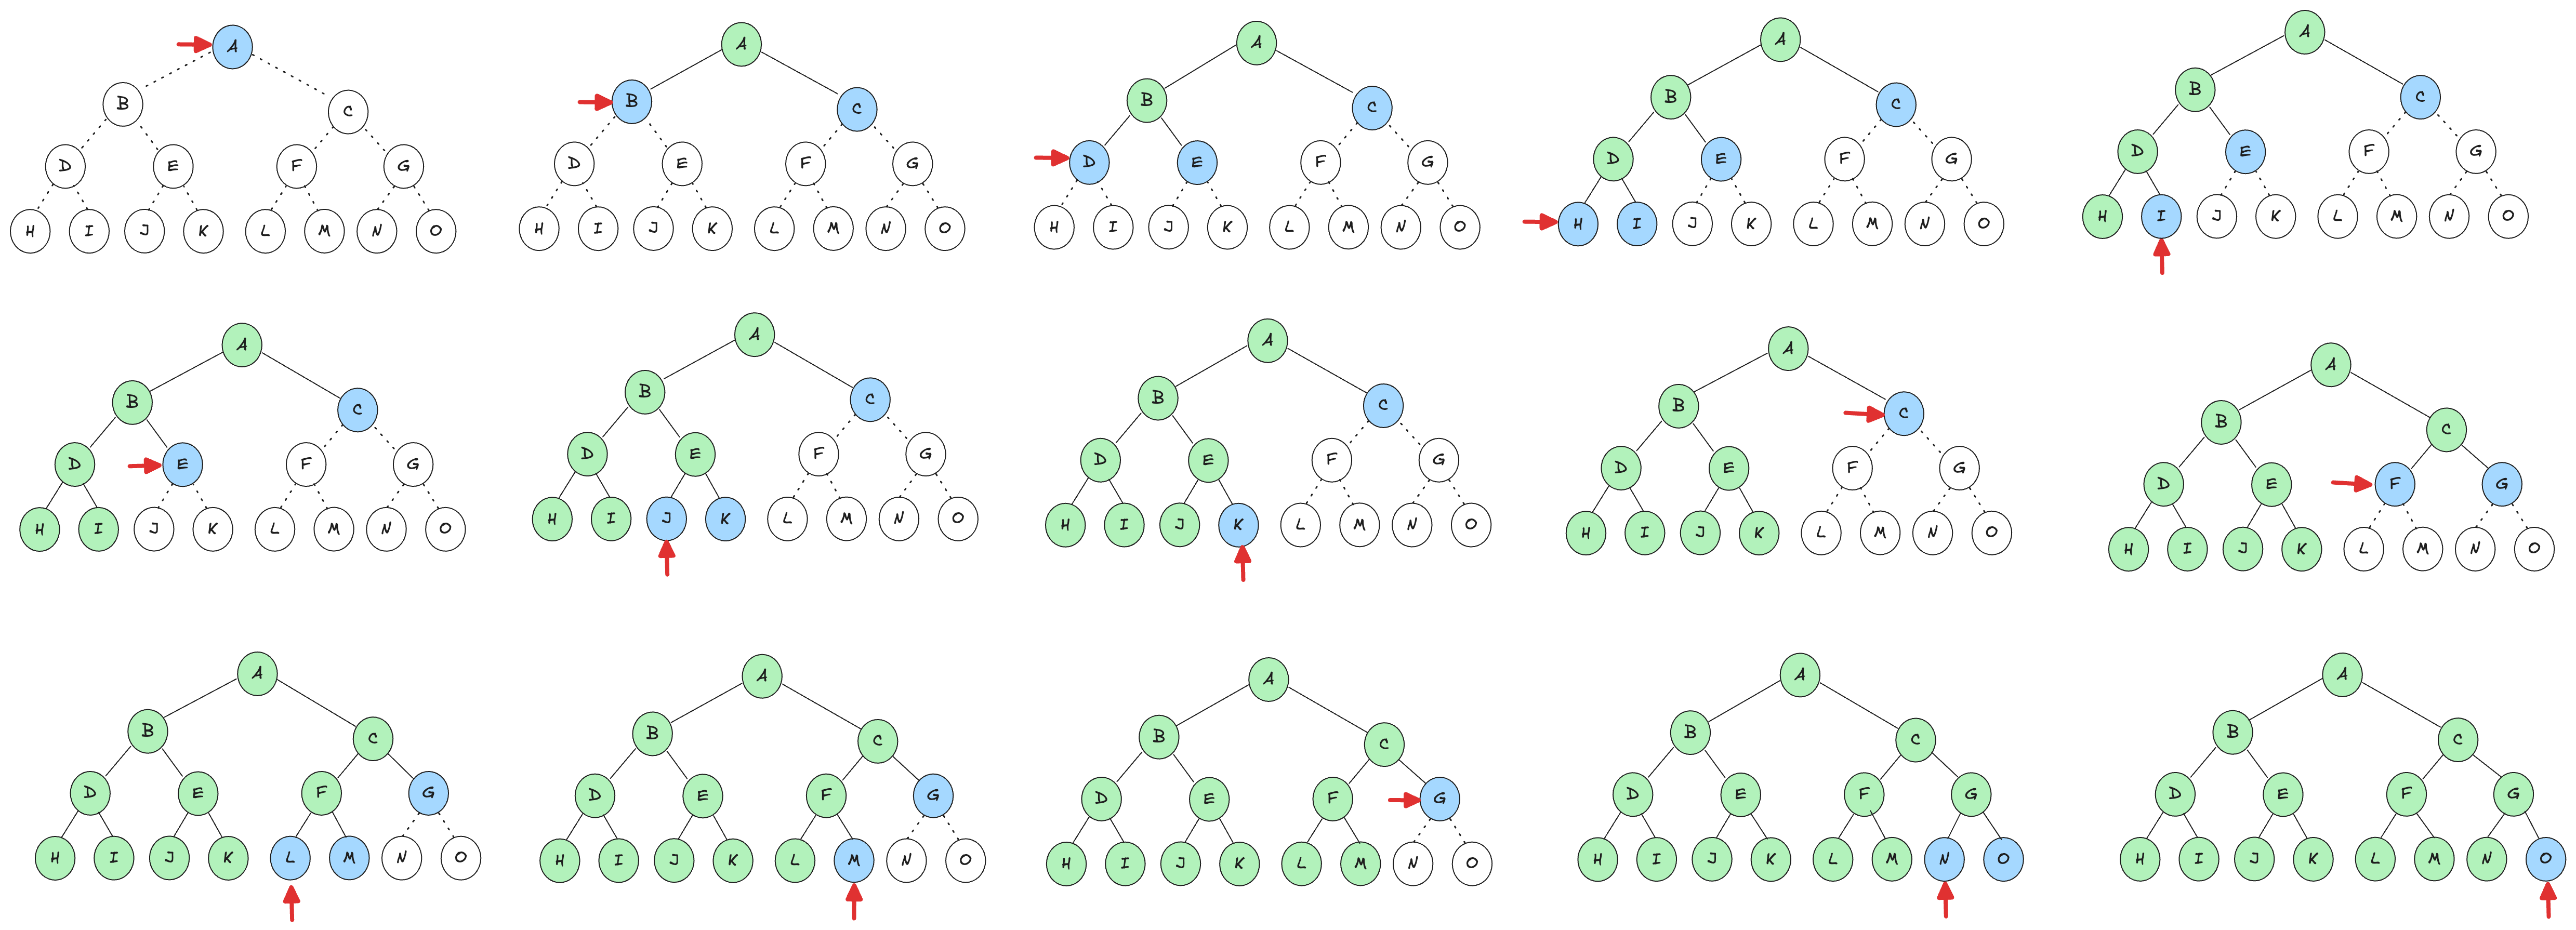

It could be implemented as best-first where the evaluation function is the negative of the depth. However, it is usually implemented as a tree-like search that does not keep a table of reached states:

In [124]:
def depth_first_tree_search(problem):
    """Search the deepest nodes in the search tree first."""
    
    # Create the initial node
    node = Node(problem.initial)

    # Create the reached states
    # In this case, this is not necessary
    # However it can be useful to check the 
    # number of explored states
    explored = set()

    # Create the frontier as a stack
    frontier = [node]

    # While the frontier is not empty
    while frontier:
        # Get the node from the frontier
        node = frontier.pop()

        # Add the state to the explored states
        explored.add(node.state)

        # If the node is a goal, return the path
        if problem.goal_test(node.state):
            return node.solution(), explored

        # Add the children to the frontier
        frontier.extend(node.expand(problem))
    
    # If the frontier is empty and we did not reach the goal, return None
    return None, explored

We run the algorithm on the Arad-Bucharest problem:

In [125]:
solution, explored_nodes = depth_first_tree_search(romania_problem)
print("\nActions to the goal state: ", solution)
print("Explored states: ", explored_nodes)


Path to the goal state:  ['Sibiu', 'Fagaras', 'Bucharest']
Explored states:  {'Fagaras', 'Arad', 'Sibiu', 'Bucharest'}


We can see that depth-first goes directly to a solution in that case, since it explores the first branch completely before moving to the next, and in that particular case it find the goal. However this can be not **not optimal** since it returns the first solution it finds, regardless of cost. It is **complete** only in finite tree-shaped spaces, but may expand the same state multiple times in acyclic graphs. In cyclic or infinite spaces, it can also **get stuck in loops or follow an infinite path**, making it **incomplete** without cycle detection. 

Despite these drawbacks, depth-first search is useful for its **low memory usage**. Unlike breadth-first search, which stores an expanding frontier, it only tracks the current path, requiring a memory just as

$\displaystyle O(bm)$ 

Think of the frontier in breadth-first search as **the surface of an ever-expanding sphere**, while the frontier in depth-first search is **just a radius** of the sphere. This efficiency makes breadth-first search practical for large problems where others algorithms would be infeasible due to excessive memory demands.

### Depth-limited search

Depth-limited search prevents depth-first search from exploring infinite paths by imposing a **depth limit L**, treating all nodes at that depth as if they had no successors. This constrains the time complexity to:

$\displaystyle O(b^L)$ 

and the space complexity to:

$\displaystyle O(bL)$. 

The implementation is straightforward, with the depth limit as an additional parameter. It returns one of three different types of values: either a solution node, a failure, or cutoff, to mean there might be a solution at a deeper depth
than L:

In [126]:
def depth_limited_search(problem, limit):
    """Search the deepest nodes up to a given depth limit."""
    
    # Create the initial node
    node = Node(problem.initial)

    # Create the reached states
    # In this case, this is not necessary
    # However it can be useful to check the 
    # number of explored states
    explored = set()
    
    # Create the frontier as a stack (node, depth)
    frontier = [(node, 0)] 
    
    while frontier:

        node, depth = frontier.pop()

        # Add the state to the explored states
        explored.add(node.state)
                
        # If the node is a goal, return the path
        if problem.goal_test(node.state):
            return node.solution(), explored
        
        # If the depth is over the limit, return cutoff 
        if depth >= limit:
            return "cutoff"

        # Expand the node
        for child in node.expand(problem):
               frontier.append((child, depth + 1))
    
    # No solution found within depth limit
    return None, explored  

Unfortunately, a poor choice of L makes depth-limited search **incomplete**, as the solution may be unreachable. In some cases, problem knowledge helps set a reasonable limit. For instance, Romania's map has 20 cities, so L=19 is valid. However, careful analysis reveals a maximum of 9 actions between any two cities (the **graph diameter**) providing a more efficient limit. Unfortunately, in most problems, a good depth limit is unknown until the solution is found.

### Iterative deepening search

A way to solves the problem of picking a good value for L is the **iterative deepening search** where we try search with all limit values: first 0, then 1, then 2, and so on, until either a solution is found, or the depth limited
search returns the failure value rather than the cutoff value:

In [127]:
def iterative_deepening_search(problem, max_depth):
    for depth in range(max_depth):
        print("Depth: ", depth)
        result = depth_limited_search(problem, depth)
        if result != 'cutoff':
            return result

Iterative deepening combines many of the benefits of depth-first and breadth-first search. Like depth-first search, its memory requirements are modest O(bd) when there is a solution, or O(bm) on finite state spaces with no solution. Like breadth-first search, iterative deepening is optimal for problems where all actions have the same cost, and is complete on finite acyclic state spaces, or on any finite state space when we check nodes for cycles all the
way up the path:

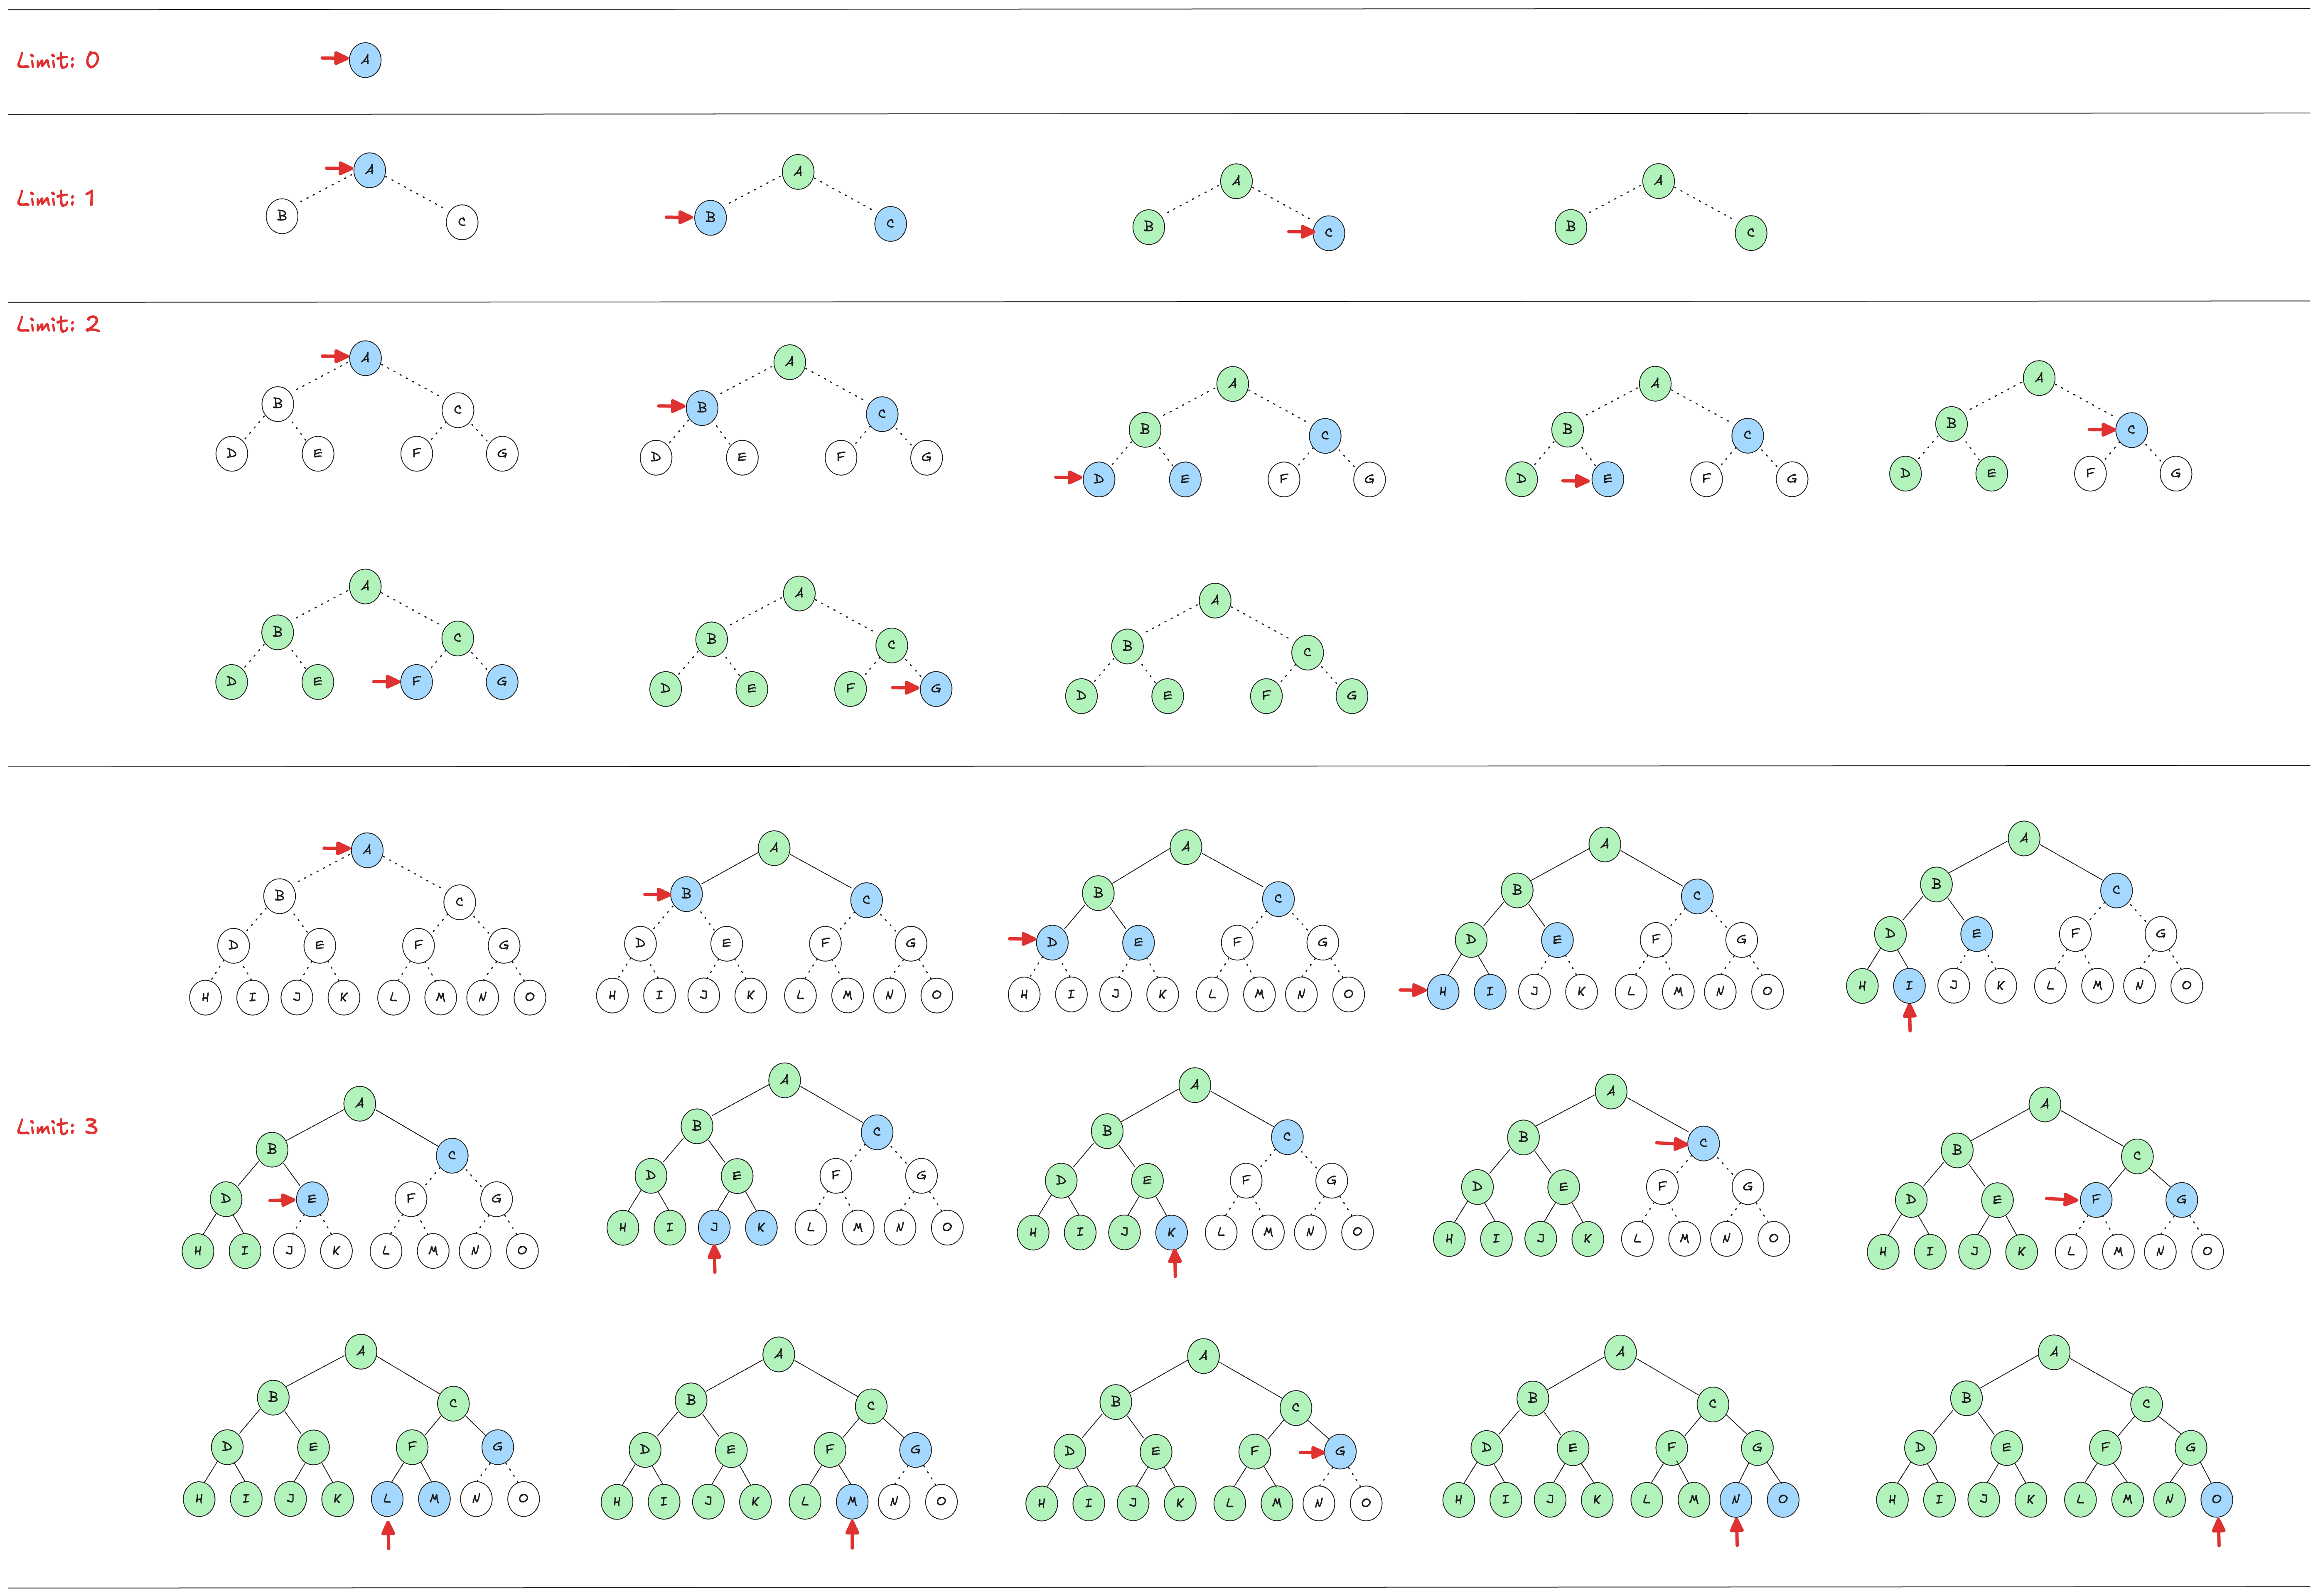


Iterative deepening search may **seem inefficient** due to repeated state generation at higher levels. However, since most nodes are at the deepest level, this overhead is minimal. At depth d, bottom-level nodes are generated once, those one level above twice, and so on, up to the root’s children, which are generated d times. The total worst-case node generation is:

$\displaystyle (d)b^1 + (d-1)b^2 + (d-2)b^3 + ... + b^d = O(b^d)$

matching the time complexity of breadth-first search. A hybrid approach can first run breadth-first until memory is nearly full, then apply iterative deepening from the frontier. Iterative deepening is ideal for large state spaces where memory is limited and the solution depth is unknown. We can run it on the Romania map problem:

In [129]:
solution, explored_nodes = iterative_deepening_search(romania_problem, 4)
print("\nActions to the goal state: ", solution)
print("Explored states: ", explored_nodes)

Depth:  0
Depth:  1
Depth:  2
Depth:  3

Path to the goal state:  ['Sibiu', 'Fagaras', 'Bucharest']
Explored states:  {'Fagaras', 'Arad', 'Sibiu', 'Bucharest'}


As other uninformed methods, it find the solution with the minimum number of actions, but not the optimal solution in terms of cost.

### Bidirectional search

The algorithms covered so far start at an initial state and can reach any one of multiple possible goal states. An alternative approach called bidirectional search **simultaneously searches forward from the initial state and backwards from the goal state**, hoping that the two searches will meet. The motivation is that the sum of the time for the forward search and the time for the backward search is less than the time for a single search:

$\displaystyle b^{\frac{d}{2}} + b^{\frac{d}{2}} = 2b^{\frac{d}{2}} < b^d$

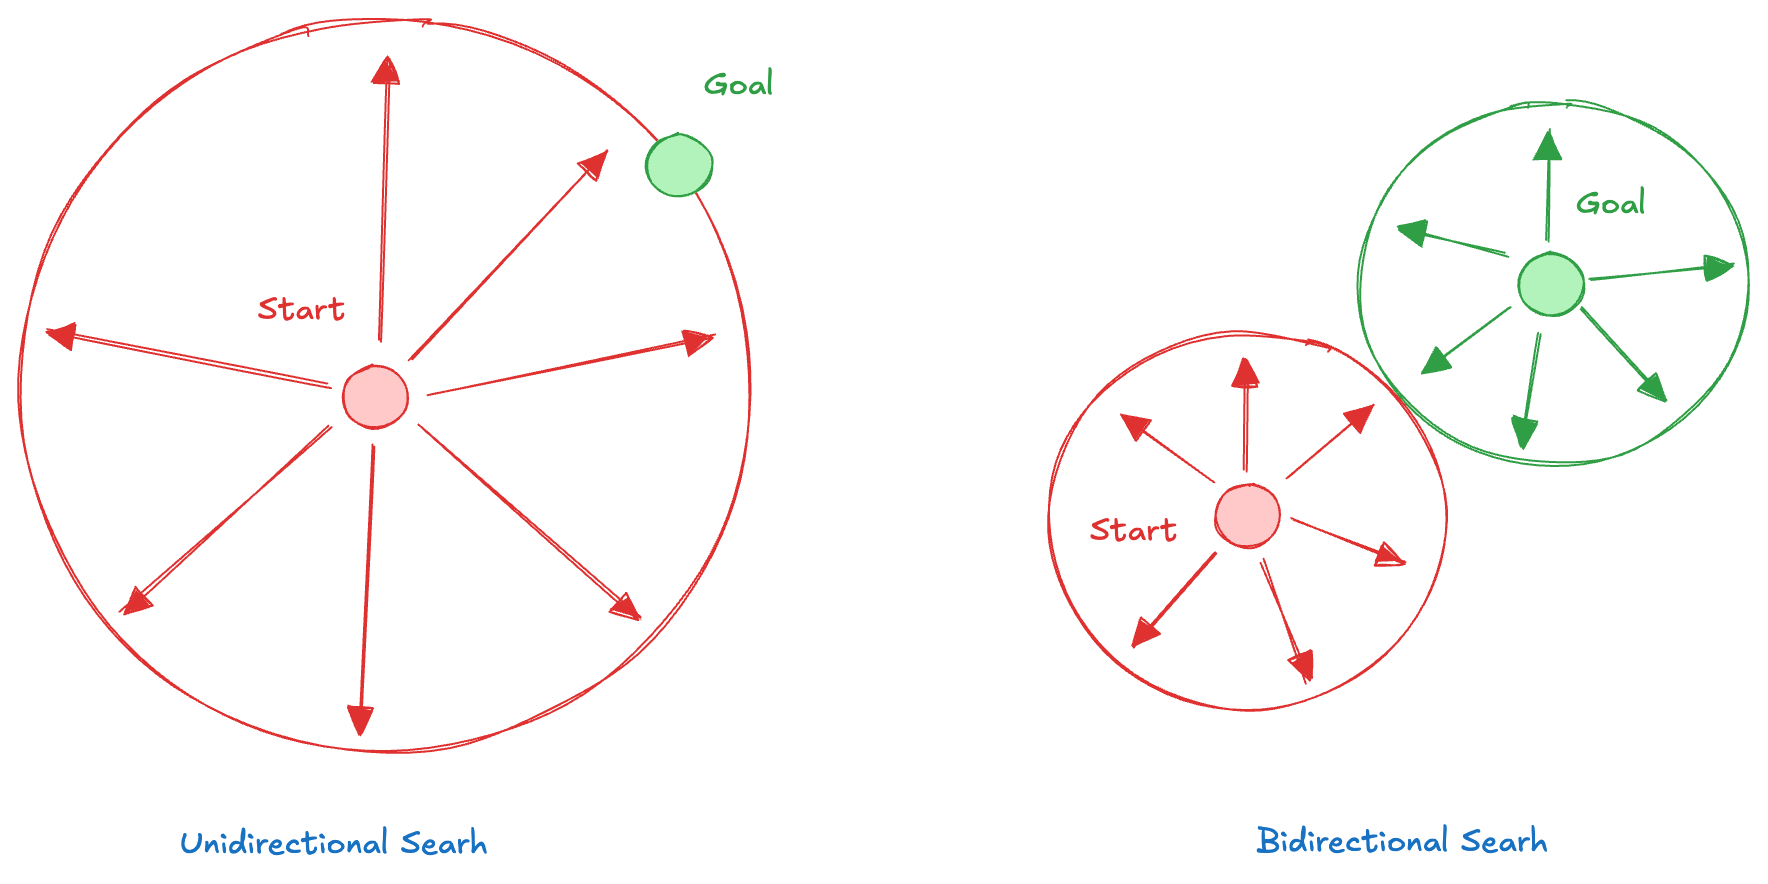

For this to work, we need to keep track of two frontiers and two tables of reached states, and we need to be able to reason backwards: if state s' is a successor of s in the forward direction, then we need to know that s is a successor of s' in the backward direction. We have a solution when the two frontiers collide. When a path in one frontier reaches a state that was also reached in the other half of the search, the two paths are joined to form a solution. The first solution we get is not guaranteed to be the best:

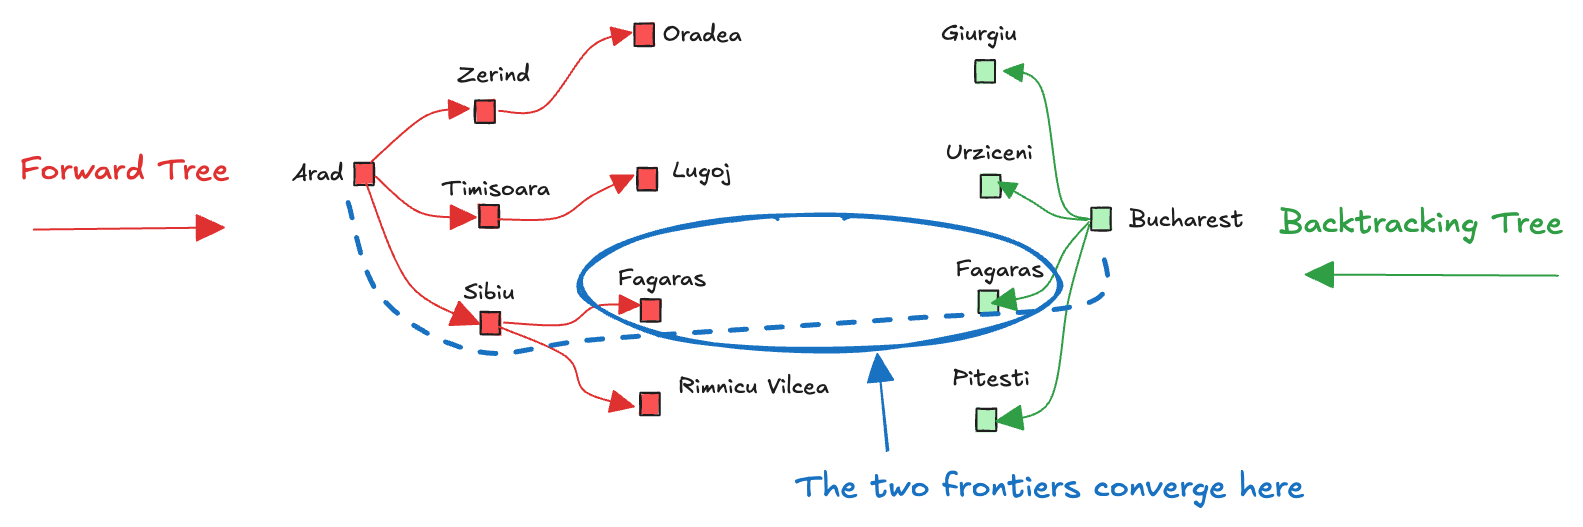


In [132]:
def bidirectional_search(problem):
    """Perform bidirectional search from the initial state to the goal state."""

    # Function to reconstruct the path from the initial node to the goal node
    def reconstruct_path(forward_node, backward_node):
        # Path from start to meeting point
        forward_path = forward_node.solution()
        # Reverse path from goal to meeting point
        backward_path = backward_node.solution()[::-1]
        # Merge the two paths
        return forward_path[:-1] + backward_path, explored_f.union(explored_b)    
    
    # Create the initial and goal nodes
    node_f = Node(problem.initial)
    node_b = Node(problem.goal)

    # Initialize two frontiers
    frontier_f = deque([node_f]) 
    frontier_b = deque([node_b]) 

    # Initialize explored sets
    explored_f = set()
    explored_b = set()

    # Early goal test if initial and goal are the same
    if problem.goal_test(node_f.state):
        return node_f.solution(), explored_f.union(explored_b)

    # Track nodes by state for path reconstruction
    node_map_f = {node_f.state: node_f}
    node_map_b = {node_b.state: node_b}

    while frontier_f and frontier_b:

        # Expand forward search
        if frontier_f:
            node = frontier_f.popleft()
            explored_f.add(node.state)
            for child in node.expand(problem):
                if child.state not in explored_f and child.state not in node_map_f:
                    # Check if child is in the backward frontier (meeting point)
                    if child.state in node_map_b:
                        return reconstruct_path(child, node_map_b[child.state])
                    # Otherwise, continue expansion
                    frontier_f.append(child)
                    node_map_f[child.state] = child

        # Expand backward search
        if frontier_b:
            node = frontier_b.popleft()
            explored_b.add(node.state)
            for child in node.expand(problem):
                if child.state not in explored_b and child.state not in node_map_b:
                    # Check if child is in the forward frontier (meeting point)
                    if child.state in node_map_f:
                        return reconstruct_path(node_map_f[child.state], child)
                    # Otherwise, continue expansion
                    frontier_b.append(child)
                    node_map_b[child.state] = child

    # No solution found
    return None, explored_f.union(explored_b)

We apply it to the Romania map problem:

In [133]:
solution, explored_nodes = bidirectional_search(romania_problem)
print("\nActions to the goal state: ", solution)
print("Explored states: ", explored_nodes) 


Path to the goal state:  ['Sibiu', 'Fagaras']
Explored states:  {'Bucharest', 'Arad', 'Fagaras', 'Zerind'}


When dealing with bidirectional search algorithms, it's essential to understand that the algorithm is typically designed for problems where a clear start and goal state exist. However, in some scenarios, the goal may not be a specific state to reach but rather a condition that must be satisfied. If multiple states are defined as a gool, the algorithm might find several solutions. Deciding which solution is optimal or preferable based on additional criteria may complicate the search. This can lead to further branching in the search space and increased computational overhead. When the goal is a condition, the application of this approach is more complex and may require additional considerations.

## Informed Search Strategies

We can improve search efficiency using domain-specific hints about goal locations. The hints come in the form of an **heuristic**, which is a rule of thumb used to estimates the best path to the goal without guaranteeing optimality but providing a good guess (how much a node is "promising"). For example, in pathfinding, the straight-line distance between two points is a common heuristic, it doesn’t account for obstacles but provides a fast estimate of how close a destination is.

### Greedy best-first search

It is a form of best-first search that expands first the node with the lowest h(n) value (the node that appears to be closest to the goal) on the grounds that this is likely to lead to a solution quickly. So the evaluation function:

$\displaystyle f(n) = h(n)$

Let us see how this works for route-finding problems. We can use the straightline distance heuristic. This table reports the straight-line distances to Bucharest of all the other cities:

| City            | Heuristic Cost |
|----------------|---------------|
| Arad          | 366           |
| Bucharest     | 0             |
| Craiova       | 160           |
| Drobeta       | 242           |
| Eforie        | 161           |
| Fagaras       | 176           |
| Giurgiu       | 77            |
| Hirsova       | 151           |
| Iasi          | 226           |
| Lugoj         | 244           |
| Mehadia       | 241           |
| Neamt         | 234           |
| Oradea        | 380           |
| Pitesti       | 100           |
| Rimnicu Vilcea| 193           |
| Sibiu         | 253           |
| Timisoara     | 329           |
| Urziceni      | 80            |
| Vaslui        | 199           |
| Zerind        | 374           |

Notice that the values of h() cannot be computed from the problem description itself, but it is needed an amount of **world knowledge** to know that h() is correlated with actual road distances and is, therefore, a useful heuristic. As an example, during the search from Arad to Bucharest, Sibiu is expanded first as the heuristic estimates it closer than Zerind or Timisoara. Next, Fagaras is chosen as the nearest, leading to Bucharest, the goal:

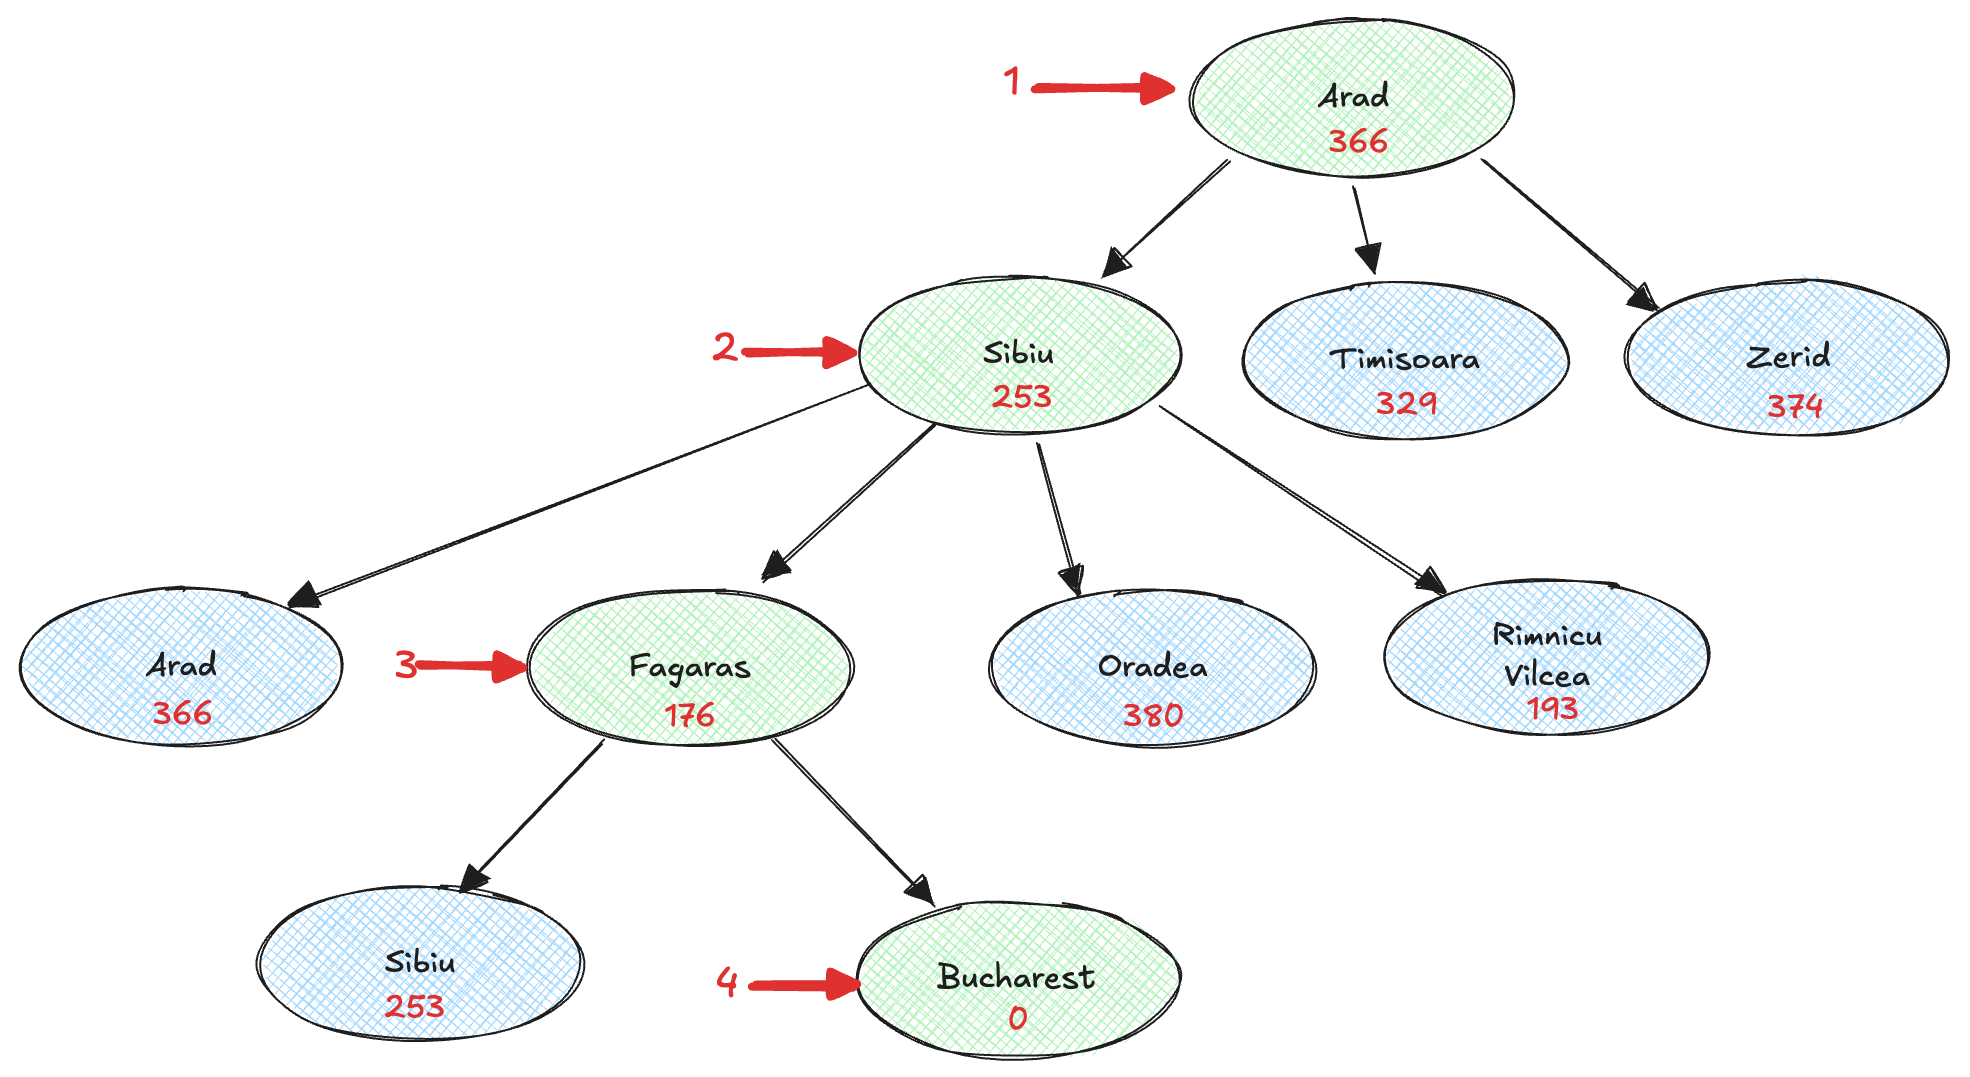

In this problem, the greedy approach finds a solution without expanding unnecessary nodes but not at the optimal cost, a shorter path exists via Rimnicu Vilcea and Pitesti. The algorithm is **greedy** because it prioritizes immediate proximity to the goal, sometimes leading to suboptimal results. Greedy best-first search is complete in finite state spaces but not in infinite ones when it can get stuck in an infinite loop, with worst-case time and space complexity of O(b^m).

Greedy best-first search is accomplished by specifying f(n) = h(n) in the best-first search implementation:

In [134]:
greedy_best_first_graph_search = best_first_graph_search

As an example, For the 8-puzzle problem, we can define two heuristic functions:

- **h1(n)**: this function counts the number of misplaced tiles. The underlying intuition is that the greater the number of tiles that are out of place, the further the current state is from the goal state.

- **h2(n)**: this function calculates the sum of the Manhattan distances for each tile, which represents the total horizontal and vertical distances each tile must travel to reach its target position. This approach effectively estimates how many moves each tile would need to make, assuming no other tiles obstruct its path to the goal.
 
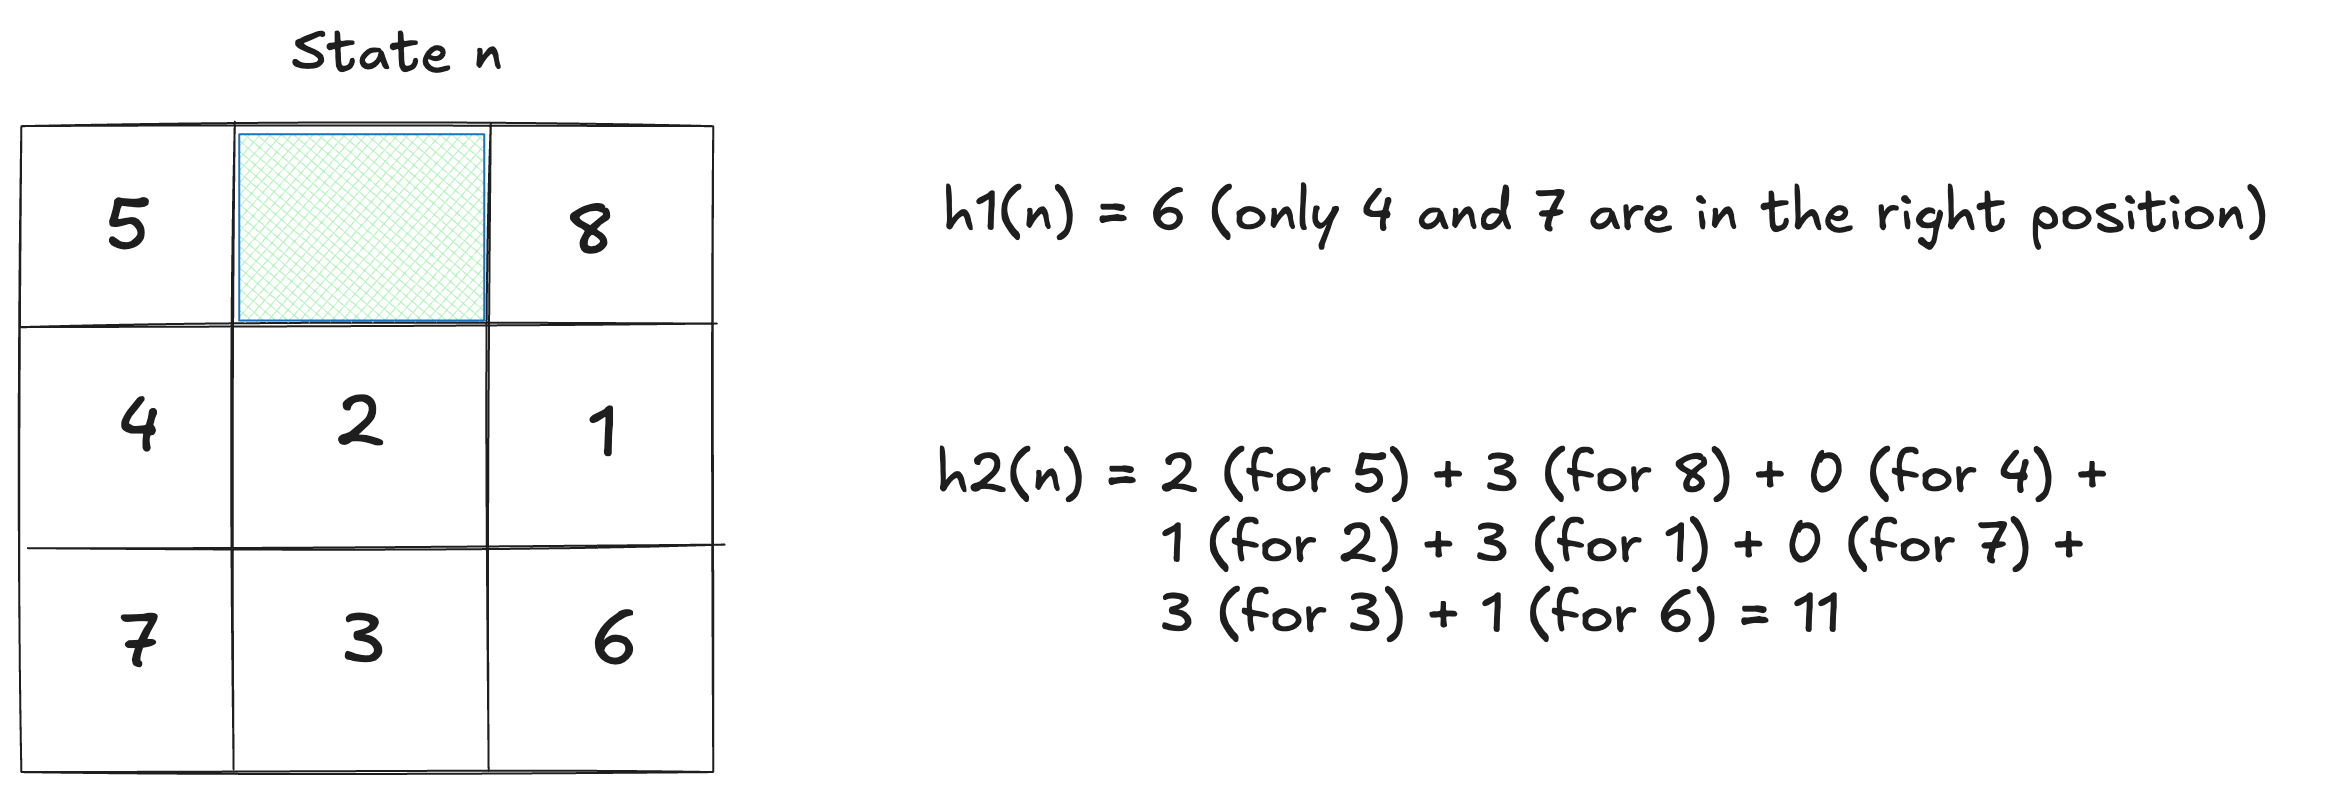

In [135]:
def h1(node):
    """number of misplaced tiles"""
    goal = (1, 2, 3, 4, 5, 6, 7, 8, 0)
    return sum(s != g for (s, g) in zip(node.state, goal))

In [136]:
def h2(node):
    """Sum of Manhattan distances for misplaced tiles."""

    goal_positions = {
        1: (0, 0),  # Goal position of tile 1
        2: (0, 1),  # Goal position of tile 2
        3: (0, 2),  # Goal position of tile 3
        4: (1, 0),  # Goal position of tile 4
        5: (1, 1),  # Goal position of tile 5
        6: (1, 2),  # Goal position of tile 6
        7: (2, 0),  # Goal position of tile 7
        8: (2, 1),  # Goal position of tile 8
        0: (2, 2),  # Goal position of the empty space (0)
    }
    
    total_distance = 0
    for i in range(3):  # 3 rows
        for j in range(3):  # 3 columns
            tile = node.state[i * 3 + j]  # Get the current tile
            if tile != 0:  # Ignore the empty space
                goal_i, goal_j = goal_positions[tile]  # Get goal position
                # Calculate the Manhattan distance for the current tile
                total_distance += abs(i - goal_i) + abs(j - goal_j)
    
    return total_distance

We can compare the informed search with the two heuristic functions with the uninformed search:

In [139]:
puzzle = EightPuzzle((5, 0, 8, 
                      4, 2, 1, 
                      7, 3, 6))

solution, explored_nodes = breadth_first_graph_search(puzzle)
print("\nBreadth_first - Actions to the goal state: ", solution)
print("Breadth_first - Len of the solution: ", len(solution)) 

solution, explored_nodes = greedy_best_first_graph_search(h1, puzzle)
print("\nGreedy h1 - Actions to the goal state: ", solution)
print("Greedy h1 - Number of explored states: ", len(explored_nodes))
print("Greedy h1 - Len of the solution: ", len(solution)) 

solution, explored_nodes = greedy_best_first_graph_search(h2, puzzle)
print("\nGreedy h2 - Actions to the goal state: ", solution)
print("Greedy h2 - Number of explored states: ", len(explored_nodes)) 
print("Greedy h2 - Len of the solution: ", len(solution)) 


Number of explored states: 48710
Breadth_first - Path to the goal state:  ['DOWN', 'RIGHT', 'UP', 'LEFT', 'DOWN', 'DOWN', 'RIGHT', 'UP', 'LEFT', 'DOWN', 'LEFT', 'UP', 'UP', 'RIGHT', 'RIGHT', 'DOWN', 'LEFT', 'LEFT', 'DOWN', 'RIGHT', 'RIGHT']
Breadth_first - Len of the solution:  21

Greedy h1 - Path to the goal state:  ['DOWN', 'RIGHT', 'UP', 'LEFT', 'DOWN', 'DOWN', 'RIGHT', 'UP', 'LEFT', 'UP', 'RIGHT', 'DOWN', 'LEFT', 'DOWN', 'RIGHT', 'UP', 'LEFT', 'LEFT', 'UP', 'RIGHT', 'RIGHT', 'DOWN', 'LEFT', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'RIGHT', 'UP', 'LEFT', 'LEFT', 'DOWN', 'RIGHT', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'UP', 'RIGHT', 'DOWN', 'LEFT', 'LEFT', 'UP', 'RIGHT', 'RIGHT', 'DOWN', 'DOWN', 'LEFT', 'UP', 'UP', 'RIGHT', 'DOWN', 'LEFT', 'DOWN', 'RIGHT', 'UP', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'DOWN', 'LEFT', 'UP', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'DOWN', 'LEFT', 'UP', 'UP', 'RIGHT', 'DOWN', 'LEFT', 'UP', 'RIGHT', 'DOWN', 'LEFT', 'DOWN', 'RIGHT', 'RIGHT', 'UP', 'LEFT', 'UP', 'RIGHT', 'DOWN', 'LEFT', 'UP

Informed search strategies are generally **much more efficient** than uninformed search methods. However, it's important to note that informed searches may not always yield the optimal solution in terms of cost. Among the heuristics, the misplaced tiles heuristic is less efficient compared to the Manhattan distance heuristic, although it still outperforms uninformed search approaches. The informed search utilizing the Manhattan distance heuristic is the most effective, as it successfully finds solutions with the minimum number of actions and optimal cost. While both heuristics serve as estimates, **some estimates can be more accurate than others**.

### A* search

The most common informed search algorithm is A* search (pronounced "A-star search"), it is a best-first algorithm that uses an evaluation fuction combining the cost to reach a node with the heuristic to the goal:

$\displaystyle f(n) = g(n) + h(n)$

where g(n) is the path cost to reach the node n from the initial node and h(n) is the estimated cost from n to the goal. By using both the cost so far and the estimate of the cost of reaching the goal,A* can lead the agent away from suboptimal paths. We can consider the progress of an A* with the goal of reaching Bucharest: 

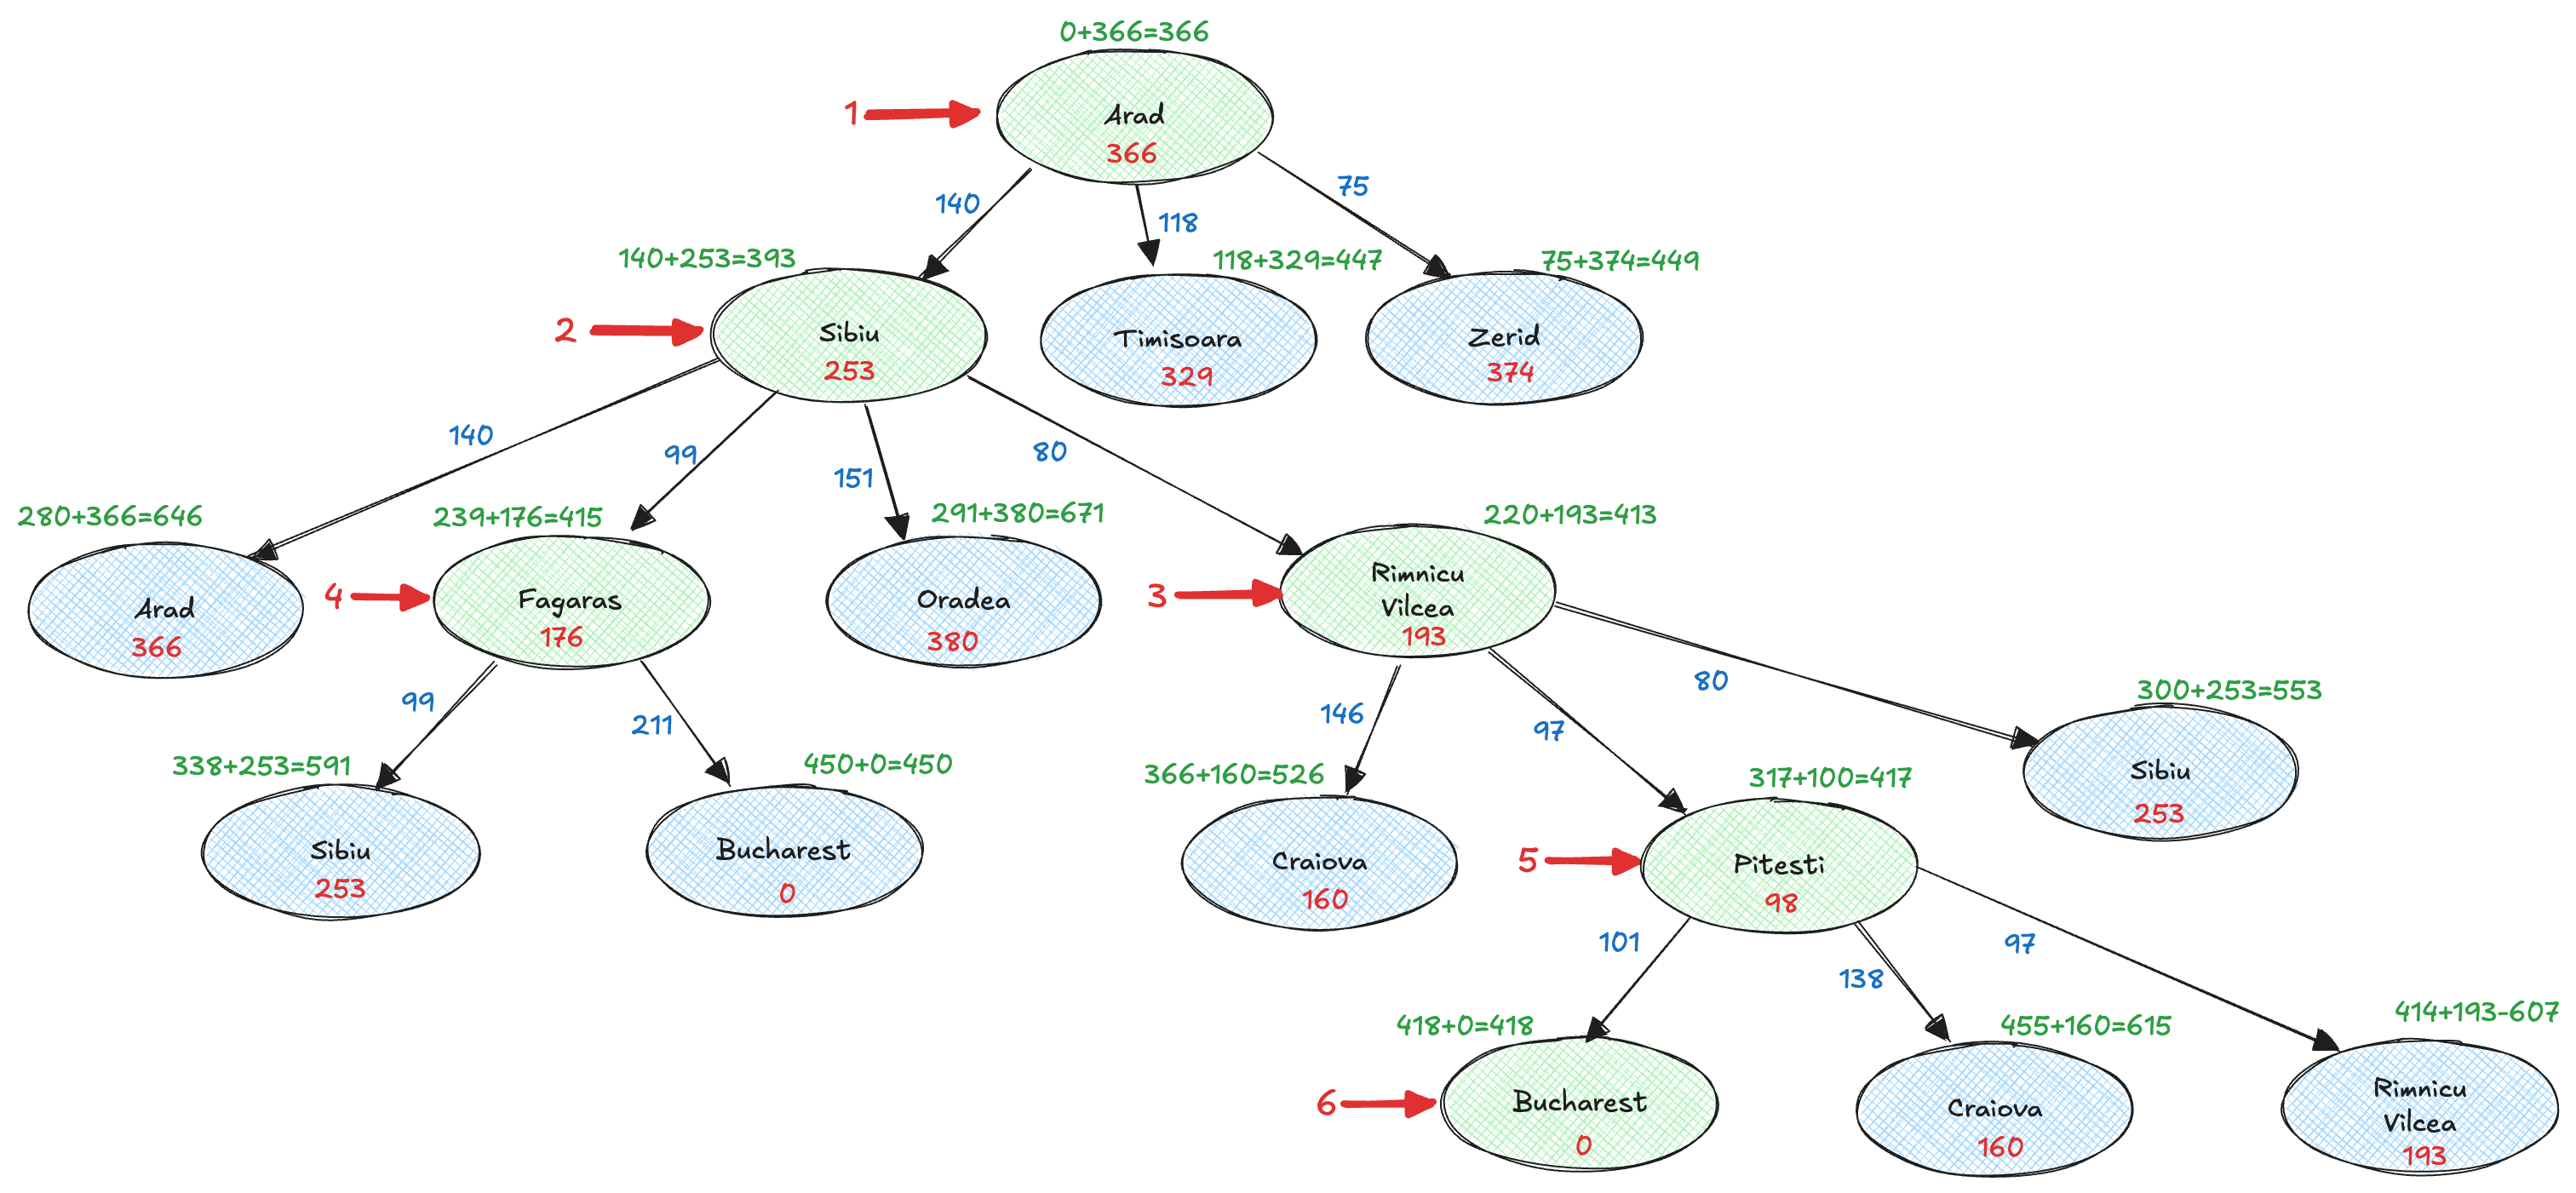

Notice that Bucharest first appears on the frontier at step 4, but it is not selected for expansion (and thus not detected as a solution) because f=450 it is not the lowest-cost on the frontier, that would be Pitesti with f=417. Another way to say this is that there might be a solution through Pitesti whose cost is as low as 417, so the algorithm will not settle for a solution that costs 450. At step 5, a different path to Bucharest is now the lowest-cost node with f=418, so it is selected and detected as the optimal solution.

A* is complete. Whether it is cost-optimal depends on the heuristic. Of course, if the heuristic provides completelty wrong information, the algorithm may not find the solution or it may find a suboptimal solution.A key property of the heuristic is **admissibility**, when it **never overestimates the real cost to reach a goal**, in other words it is **optimistic**. 

$\displaystyle 0 \leq h(n) \leq h*(n)$

where h*(n) is the true cost to reach the goal from n. If the heuristic is admissible, then A* is **optimal**. The algorithm is also **optimal** if the heuristic is **consistent** (or **monotonic**), meaning that the heuristic is **admissible** and **satisfies the triangle inequality**:

A* with an admissible heuristic is **cost-optimal**. This can be proven by contradiction. 

Suppose that the best path has cost C*, and A* finds a path with cost C > C*. Then there must be some node n which is on the optimal path but not on the path found by A*. Since A* hasn't expanded n, it must be that

$\displaystyle f(n) > C*$

otherwise, A* would have expanded n. But f(n) is the sum of the cost to reach n from the start node, g(n), and the estimated cost to reach the goal from n, h(n):

$\displaystyle f(n) = g(n) + h(n)$

since n is on the optimal path, the cost to reach it from the start node is the optimal cost:

$\displaystyle f(n) = g*(n) + h(n)$

and since h(n) is admissible, it is an underestimate of the cost to reach the goal from n:

$\displaystyle f(n) < g*(n) + h*(n)$

the right side of the inequality is the definition of the optimal cost:

$\displaystyle f(n) < C*$

which contradicts the starting inequality. Therefore, A* with an admissible heuristic is cost-optimal.

Some admissible heuristics are trivial, such as h0(n)=0, which always returns 0. While admissible, it is uninformative. A* search using h0(n) reduces to uniform-cost search, making it a special case of A*. 

A useful way to visualize a search is by drawing **contours** in the state space, similar to a topographic map. Each contour labeled includes all nodes where the estimated cost is under a certain level. Since A* expands the node with the lowest estimated cost, the search spreads outward from the start node in concentric bands of increasing estimated cost:

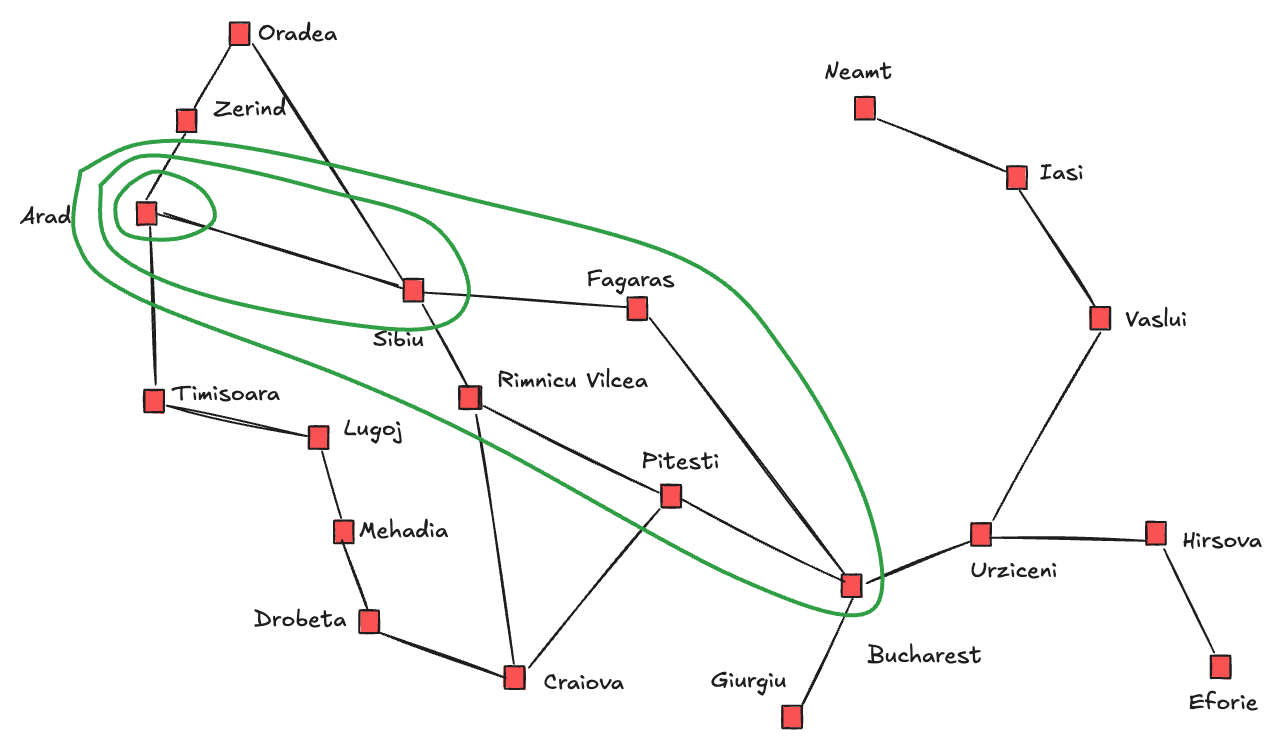

With uniform-cost search, contours represent the actual cost so far, without considering future estimates. These contours are "circular", expanding uniformly from the start state with no preference for the goal. In contrast, A* with a good heuristic stretches the contours toward the goal, narrowing around an optimal path. Since path costs are always increasing (due to positive action costs), the contours remain concentric and non-overlapping. If drawn finely enough, a contour line can always be placed between any two nodes along a path.

A* search can be implemented ad a best-first graph search with f(n) = g(n)+h(n):

In [140]:
def astar_search(h, problem):
    return best_first_graph_search(lambda n: n.path_cost + h(n), problem)

We can apply the A* algorithm to the 8-puzzle problem, but how can we determine if a heuristic is admissible without knowing the actual cost? For instance, consider h1 and h2. The misplaced tiles heuristic counts the number of tiles that are out of place. Since each misplaced tile can be moved to its correct position in at least one move, the actual number of moves required to reach the goal will always be greater than or equal to the number of misplaced tiles. Thus, h1 never overestimates the true cost and is admissible. The Manhattan distance heuristic calculates the sum of the Manhattan distances for each tile from its goal position. This metric represents the minimum number of moves required for each tile to reach its target, assuming no obstructions. Consequently, the actual cost cannot be less than this sum, making h2 admissible as well. Both heuristics are admissible for the 8-puzzle problem, rendering them suitable for use in A* search algorithms:

In [143]:
puzzle = EightPuzzle((5, 0, 8, 
                      4, 2, 1, 
                      7, 3, 6))

solution, explored_nodes = astar_search(h1, puzzle)
print("\nA* h1 - Actions to the goal state: ", solution)
print("A* h1 - Number of explored states: ", len(explored_nodes)) 
print("A* h1 - Len of the solution: ", len(solution)) 

solution, explored_nodes = astar_search(h2, puzzle)
print("\nA* h2 - Actions to the goal state: ", solution)
print("A* h2 - Number of explored states: ", len(explored_nodes)) 
print("A* h2 - Len of the solution: ", len(solution)) 


A* h1 - Path to the goal state:  ['DOWN', 'RIGHT', 'UP', 'LEFT', 'DOWN', 'DOWN', 'RIGHT', 'UP', 'LEFT', 'DOWN', 'LEFT', 'UP', 'UP', 'RIGHT', 'RIGHT', 'DOWN', 'LEFT', 'LEFT', 'DOWN', 'RIGHT', 'RIGHT']
A* h1 - Number of explored states:  4096
A* h1 - Len of the solution:  21

A* h2 - Path to the goal state:  ['DOWN', 'RIGHT', 'UP', 'LEFT', 'DOWN', 'DOWN', 'RIGHT', 'UP', 'LEFT', 'DOWN', 'LEFT', 'UP', 'UP', 'RIGHT', 'RIGHT', 'DOWN', 'LEFT', 'LEFT', 'DOWN', 'RIGHT', 'RIGHT']
A* h2 - Number of explored states:  738
A* h2 - Len of the solution:  21


As we can see, A* explores more nodes than greedy search, making it less efficient in terms of exploration. However, it guarantees an optimal solution in terms of cost and is significantly more efficient than uninformed search.

A slightly **stronger property** is called **consistency**. A heuristic is consistent if, for
every node n and every successor n' of n generated by an action a, we have:

$\displaystyle h(n) \leq c(n,a,n') + h(n')$

where c(n,a,n') is the cost of getting from n to n' using action a. 

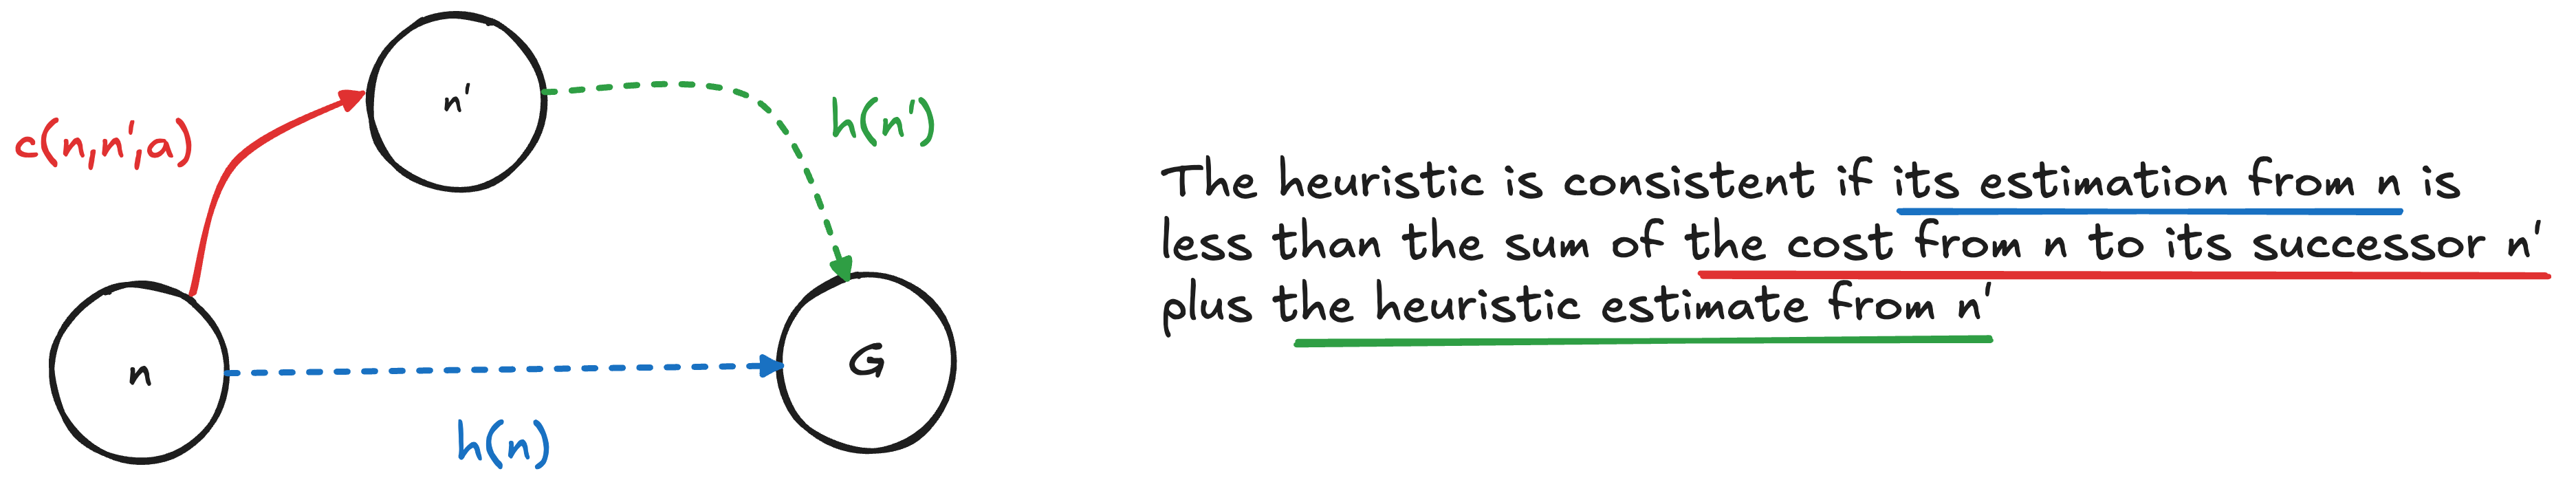

This is an example of the **triangle inequality**, which states that a triangle’s side cannot be longer than the sum of the other two sides. A consistent heuristic, like the straight-line distance used in the Bucharest example, ensures that A* remains cost-optimal. Every consistent heuristic is admissible, but not all admissible heuristics are consistent. Moreover, With a consistent heuristic, a state is **reached via an optimal path the first time**, eliminating the need to re-add it to the frontier or update the explored set.

### Weighted A*

A* is optimal but expands many nodes. To reduce time and space, we can accept "satisficing" solutions (suboptimal but good enough). Using an inadmissible heuristic (which may overestimate) we risk missing the optimal solution, but we can reduce node expansion. For instance, road engineers use a **detour index**, which is a multiplier applied to the straight-line distance to account for the typical curvature of roads. This concept extends beyond roads through **weighted A***, where we amplify the heuristic value, leading to the search evaluation function:

$\displaystyle f(n) = g(n) + w \cdot h(n)$

We have considered searches that evaluate states by combining g and h in various ways and weighted A∗ can be seen as a generalization of the others:

| Search Algorithm            | Formula                | Weight (W)       |
|-----------------------------|------------------------|------------------|
| A* search                   | g(n) + h(n)            |  W = 1      |
| Uniform-cost search         | g(n)                   | W = 0       |
| Greedy best-first search    | h(n)                   | W = \infty   |
| Weighted A* search          | g(n) + W h(n)          | 1 < W < inf) |

The implementation of weighted A* is similar to A*, but with an additional parameter for the weight:

In [146]:
def weighted_astar_search(h, w, problem):
    return best_first_graph_search(lambda n: n.path_cost + w * h(n), problem)

We can apply it to the 8-puzzle problem:

In [147]:
puzzle = EightPuzzle((5, 0, 8, 
                      4, 2, 1, 
                      7, 3, 6))

solution, explored_nodes = weighted_astar_search(h1, 15, puzzle)
print("\nWeighted A* h1 - Actions to the goal state: ", solution)
print("Weighted A* h1 - Number of explored states: ", len(explored_nodes)) 
print("Weighted A* h1 - Len of the solution: ", len(solution)) 

solution, explored_nodes = weighted_astar_search(h2, 15, puzzle)
print("\nWeighted A* h2 - Actions to the goal state: ", solution)
print("Weighted A* h2 - Number of explored states: ", len(explored_nodes)) 
print("Weighted A* h2 - Len of the solution: ", len(solution))


Weighted A* h1 - Path to the goal state:  ['RIGHT', 'DOWN', 'LEFT', 'UP', 'RIGHT', 'DOWN', 'DOWN', 'LEFT', 'UP', 'LEFT', 'UP', 'RIGHT', 'DOWN', 'RIGHT', 'DOWN', 'LEFT', 'UP', 'UP', 'RIGHT', 'DOWN', 'LEFT', 'LEFT', 'DOWN', 'RIGHT', 'UP', 'RIGHT', 'DOWN', 'LEFT', 'LEFT', 'UP', 'RIGHT', 'DOWN', 'RIGHT', 'UP', 'LEFT', 'DOWN', 'RIGHT']
Weighted A* h1 - Number of explored states:  1531
Weighted A* h1 - Len of the solution:  37

Weighted A* h2 - Path to the goal state:  ['DOWN', 'RIGHT', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'DOWN', 'LEFT', 'UP', 'LEFT', 'UP', 'RIGHT', 'DOWN', 'RIGHT', 'DOWN', 'LEFT', 'UP', 'UP', 'RIGHT', 'DOWN', 'LEFT', 'DOWN', 'RIGHT', 'UP', 'LEFT', 'LEFT', 'DOWN', 'RIGHT', 'RIGHT', 'UP', 'LEFT', 'DOWN', 'LEFT', 'UP', 'RIGHT', 'RIGHT', 'DOWN']
Weighted A* h2 - Number of explored states:  505
Weighted A* h2 - Len of the solution:  37


As anticipated, the solution may not be optimal, but it has allowed us to explore fewer states. The choice of the weight parameter is crucial, as it affects the balance between optimality and efficiency. A higher weight value leads to a more efficient search but may result in a suboptimal solution. Conversely, a lower weight value increases the likelihood of finding the optimal solution but may require more exploration. The optimal weight value depends on the problem and the heuristic used.

### Iterative-deepening A* (IDA*)

Iterative-deepening A* (IDA*) search is to A* what iterative-deepening search is to depth-first search: it provides the advantages of A* without the need to store all reached states in memory, albeit at the cost of revisiting some states multiple times. IDA* is particularly important and widely used for problems that cannot fit entirely in memory. In standard iterative deepening, the cutoff is determined by depth, which increases by one with each iteration. In contrast, IDA* apply a limit to the values of f(n). At each interation, the algorithm performs a depth-first search with a cutoff value, which is the smallest f(n) value that exceeds the current limit. The limit is updated to the minimum cutoff value found in the previous iteration:

1. Start with cutoff = h(start)
2. Prune any node if f(node) > cutoff
3. Next cutoff = minimum cost of any node pruned

IDA* search is complete and optimal when using an admissible heuristic, requiring less memory than A* by avoiding frontier sorting but at the cost of revisiting states not on the current path due to its limited memory usage; while memory-efficient, this makes it less time-efficient.

## Visualizing the Search Process

To gain a deeper understanding of how search algorithms operate, we can visually represent their exploration of the state space using a graph. This can be achieved through a two-dimensional grid world filled with random obstacles, where agents navigate through a series of states, each represented by grid cells. By illustrating the movements of these agents and the cells they explore to find the path to the goal, we can observe the search process in action. We can clearly see how search algorithms traverse the grid, the decisions they make at each step, and how they handle obstacles. This visualization not only enhances our comprehension of the algorithms' mechanics but also allows for a comparative analysis of their efficiency and effectiveness in finding solutions within the given environment.

In [209]:
import numpy as np
import matplotlib.pyplot as plt
import random

class ObstacleGridWorld(Problem):
    """Grid world environment modeled as a search problem with random obstacles"""

    def __init__(self, width, height, num_obstacles, max_obstacle_length, initial, goal):
        super().__init__(initial, goal)
        self.width = width
        self.height = height
        self.obstacles = self.generate_random_obstacles(num_obstacles, max_obstacle_length)
        self.actions_list = [("UP", (0, -1)),
                             ("DOWN", (0, 1)),
                             ("LEFT", (-1, 0)),
                             ("RIGHT", (1, 0)),
                             ("UP-LEFT", (-1, -1)),
                             ("UP-RIGHT", (1, -1)),
                             ("DOWN-LEFT", (-1, 1)),
                             ("DOWN-RIGHT", (1, 1))
                            ]

    def generate_random_obstacles(self, num_obstacles, max_length):
        # The set of obstacle cells
        obstacles = set()
        
        # Generate obstacles
        for _ in range(num_obstacles):

            # Randomly pick a starting point
            x, y = random.randint(0, self.width - 1), random.randint(0, self.height - 1)
            
            # Avoid placing obstacles on start/goal
            if (x, y) == self.initial or (x, y) == self.goal:
                continue  

            # Randomly choose horizontal or vertical orientation
            is_horizontal = random.choice([True, False])
            
            # Randomly choose obstacle length
            length = random.randint(1, max_length)

            # Generate obstacle cells
            for i in range(length):
                nx, ny = (x + i, y) if is_horizontal else (x, y + i)
                if 0 <= nx < self.width and 0 <= ny < self.height and (nx, ny) not in {self.initial, self.goal}:
                    obstacles.add((nx, ny))                
        return obstacles

    def actions(self, state):
        x, y = state

        # List of valid actions
        valid_actions = []

        # Check all possible actions
        for action, (dx, dy) in self.actions_list:

            # Check if the new state is valid
            new_state = (x + dx, y + dy)

            # Add to valid actions if the new state is valid
            if self.is_valid(new_state):
                valid_actions.append(action)

        return valid_actions

    def result(self, state, action):
        x, y = state

        # Get the action direction
        dx, dy = dict(self.actions_list)[action]

        # Compute the new state
        new_state = (x + dx, y + dy)

        # Return the new state if valid, else return the current state
        return new_state if self.is_valid(new_state) else state

    def goal_test(self, state):
        # Check if the state is the goal state
        return state == self.goal

    def path_cost(self, c, state1, action, state2):
        # Assume each step has a unit cost
        return c + 1

    def is_valid(self, state):
        # Check if the state is within bounds and not an obstacle
        x, y = state
        return 0 <= x < self.width and 0 <= y < self.height and state not in self.obstacles



Now we can implement a function to visualize the grid world, the path found by the search algorithm, and the nodes expanded during the search:

In [214]:
def plot(problem, solution=None, explored=None):
    """Plot the grid world with start, goal, obstacles, path, and explored states."""

    # Define colors
    START_COLOR = 1        # Black for the start
    GOAL_COLOR = 1         # Black for the goal
    OBSTACLE_COLOR = 0.5   # G for obstacles
    PATH_COLOR = 0.7       # Light blue for path
    EXPLORED_COLOR = 0.2  # Light gray for explored cells 
    
    # Create a grid
    grid = np.zeros((problem.height, problem.width))
    
    # Mark obstacles
    for (x, y) in problem.obstacles:
        grid[y, x] = OBSTACLE_COLOR
    
    # Mark the solution path
    if solution:
        path = [problem.initial]
        x, y = problem.initial
        for action in solution:
            if action == 'UP':
                y -= 1
            elif action == 'DOWN':
                y += 1
            elif action == 'LEFT':
                x -= 1
            elif action == 'RIGHT':
                x += 1
            elif action == 'UP-LEFT':
                x -= 1
                y -= 1
            elif action == 'UP-RIGHT':
                x += 1
                y -= 1
            elif action == 'DOWN-LEFT':
                x -= 1
                y += 1
            elif action == 'DOWN-RIGHT':
                x += 1
                y += 1
            path.append((x, y))

        # Mark the path
        for (x, y) in path:
            grid[y, x] = PATH_COLOR

    # Mark the explored cells
    if explored:
        for (x, y) in explored:
            if grid[y, x] == 0:  
                grid[y, x] = EXPLORED_COLOR

    # Mark start 
    grid[problem.initial[1], problem.initial[0]] = START_COLOR

    # Mark goal
    grid[problem.goal[1], problem.goal[0]] = GOAL_COLOR

    # Use Matplotlib to plot the grid
    plt.figure(figsize=(problem.width / 2, problem.height / 2))
    plt.imshow(grid, cmap="Grays", origin="upper")

    # Draw grid lines
    for x in range(problem.width + 1):
        plt.axvline(x - 0.5, color='black', lw=0.5)
    for y in range(problem.height + 1):
        plt.axhline(y - 0.5, color='black', lw=0.5)

    plt.xticks([])
    plt.yticks([])
    plt.show()

We create a problem:

In [227]:
grid_problem = ObstacleGridWorld(width=100, height=100, 
                                num_obstacles=110, max_obstacle_length=10,
                                initial=(30, 30), goal=(70, 70))

And we solve it with some search algorithms to visualize their search strategies. We can start with an uninformed search, like the breadth first search:

Number of explored states: 5504

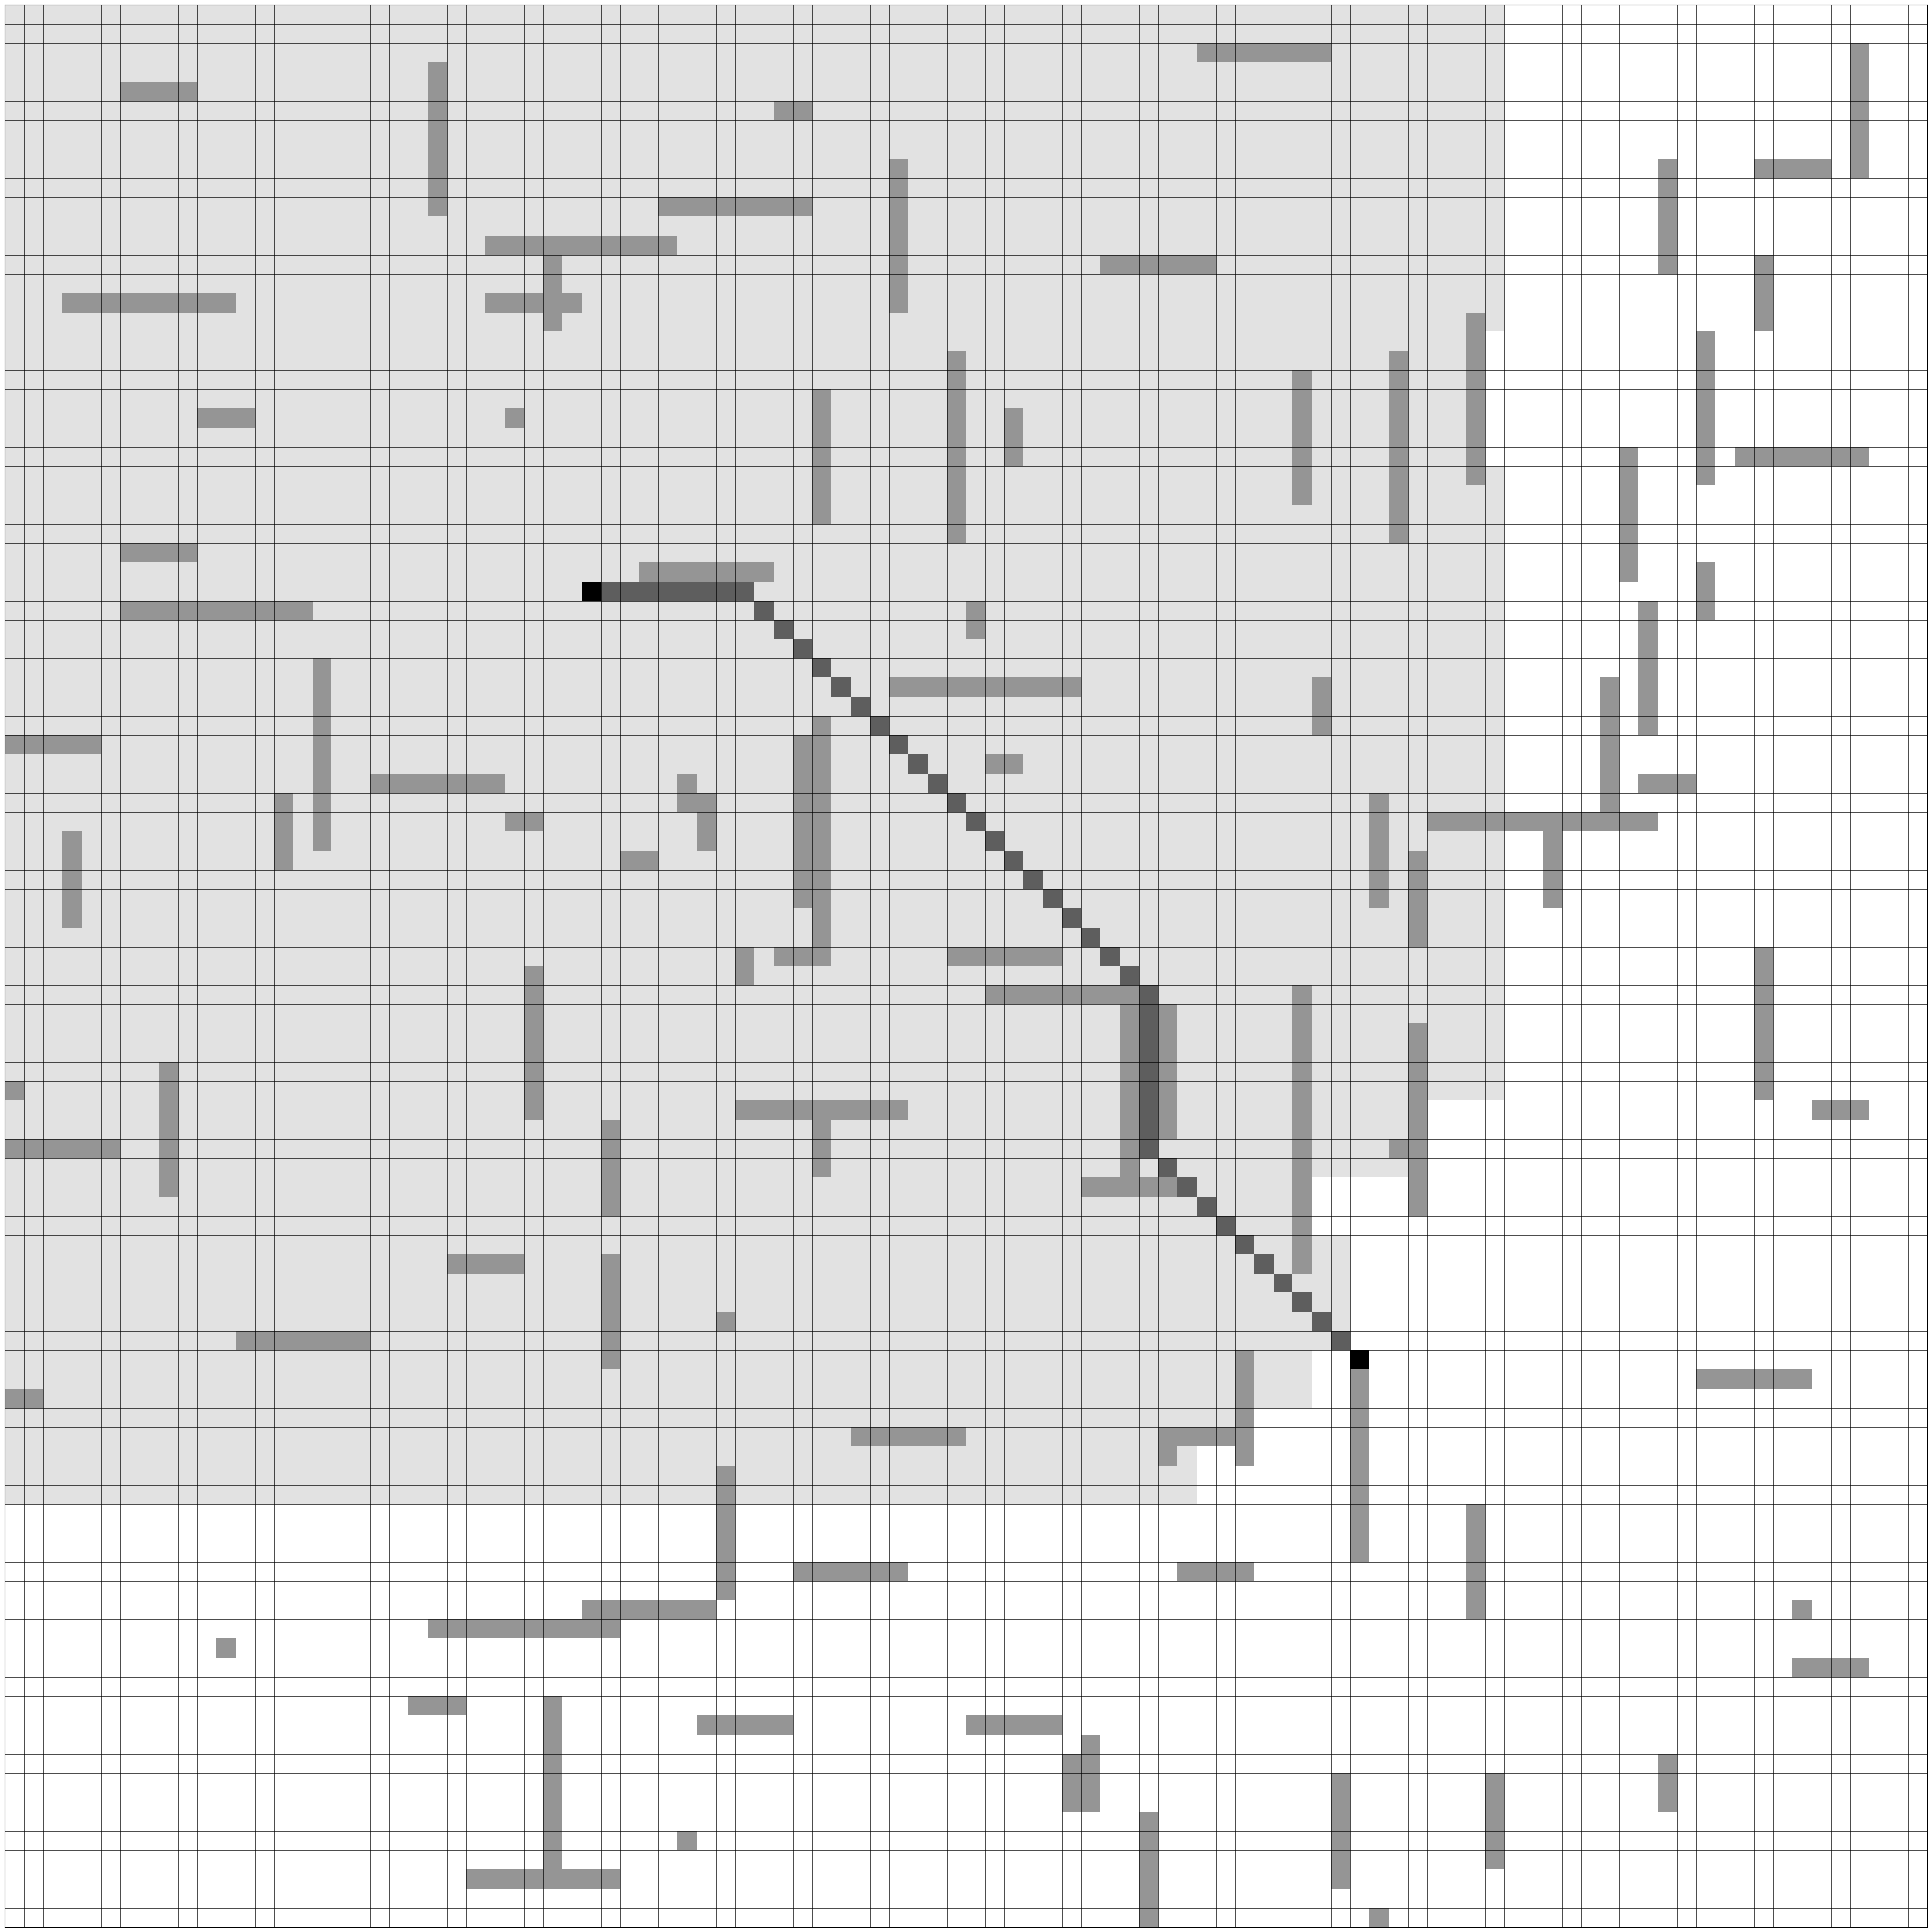

In [228]:
solution, explored_nodes = breadth_first_graph_search(grid_problem)
plot(grid_problem, solution, explored_nodes)

The  breadth first algorithm explores nodes level by level, which means it systematically covers all nodes at the present depth before moving on to nodes at the next depth level. This ensures that the explored area is evenly distributed around the starting point. To apply informed search, we need to define a heuristic function. For the grid world, we can use the Euclidean distance between two points as a heuristic:

$\displaystyle d = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$

The Euclidean distance is admissible for grid world problems because it never overestimates the minimal cost to reach the goal.

In [243]:
import math 

def heuristic(node):
    """Calculate the straight-line (Euclidean) distance from the current state to the goal."""
    x1, y1 = node.state
    x2, y2 = grid_problem.goal
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

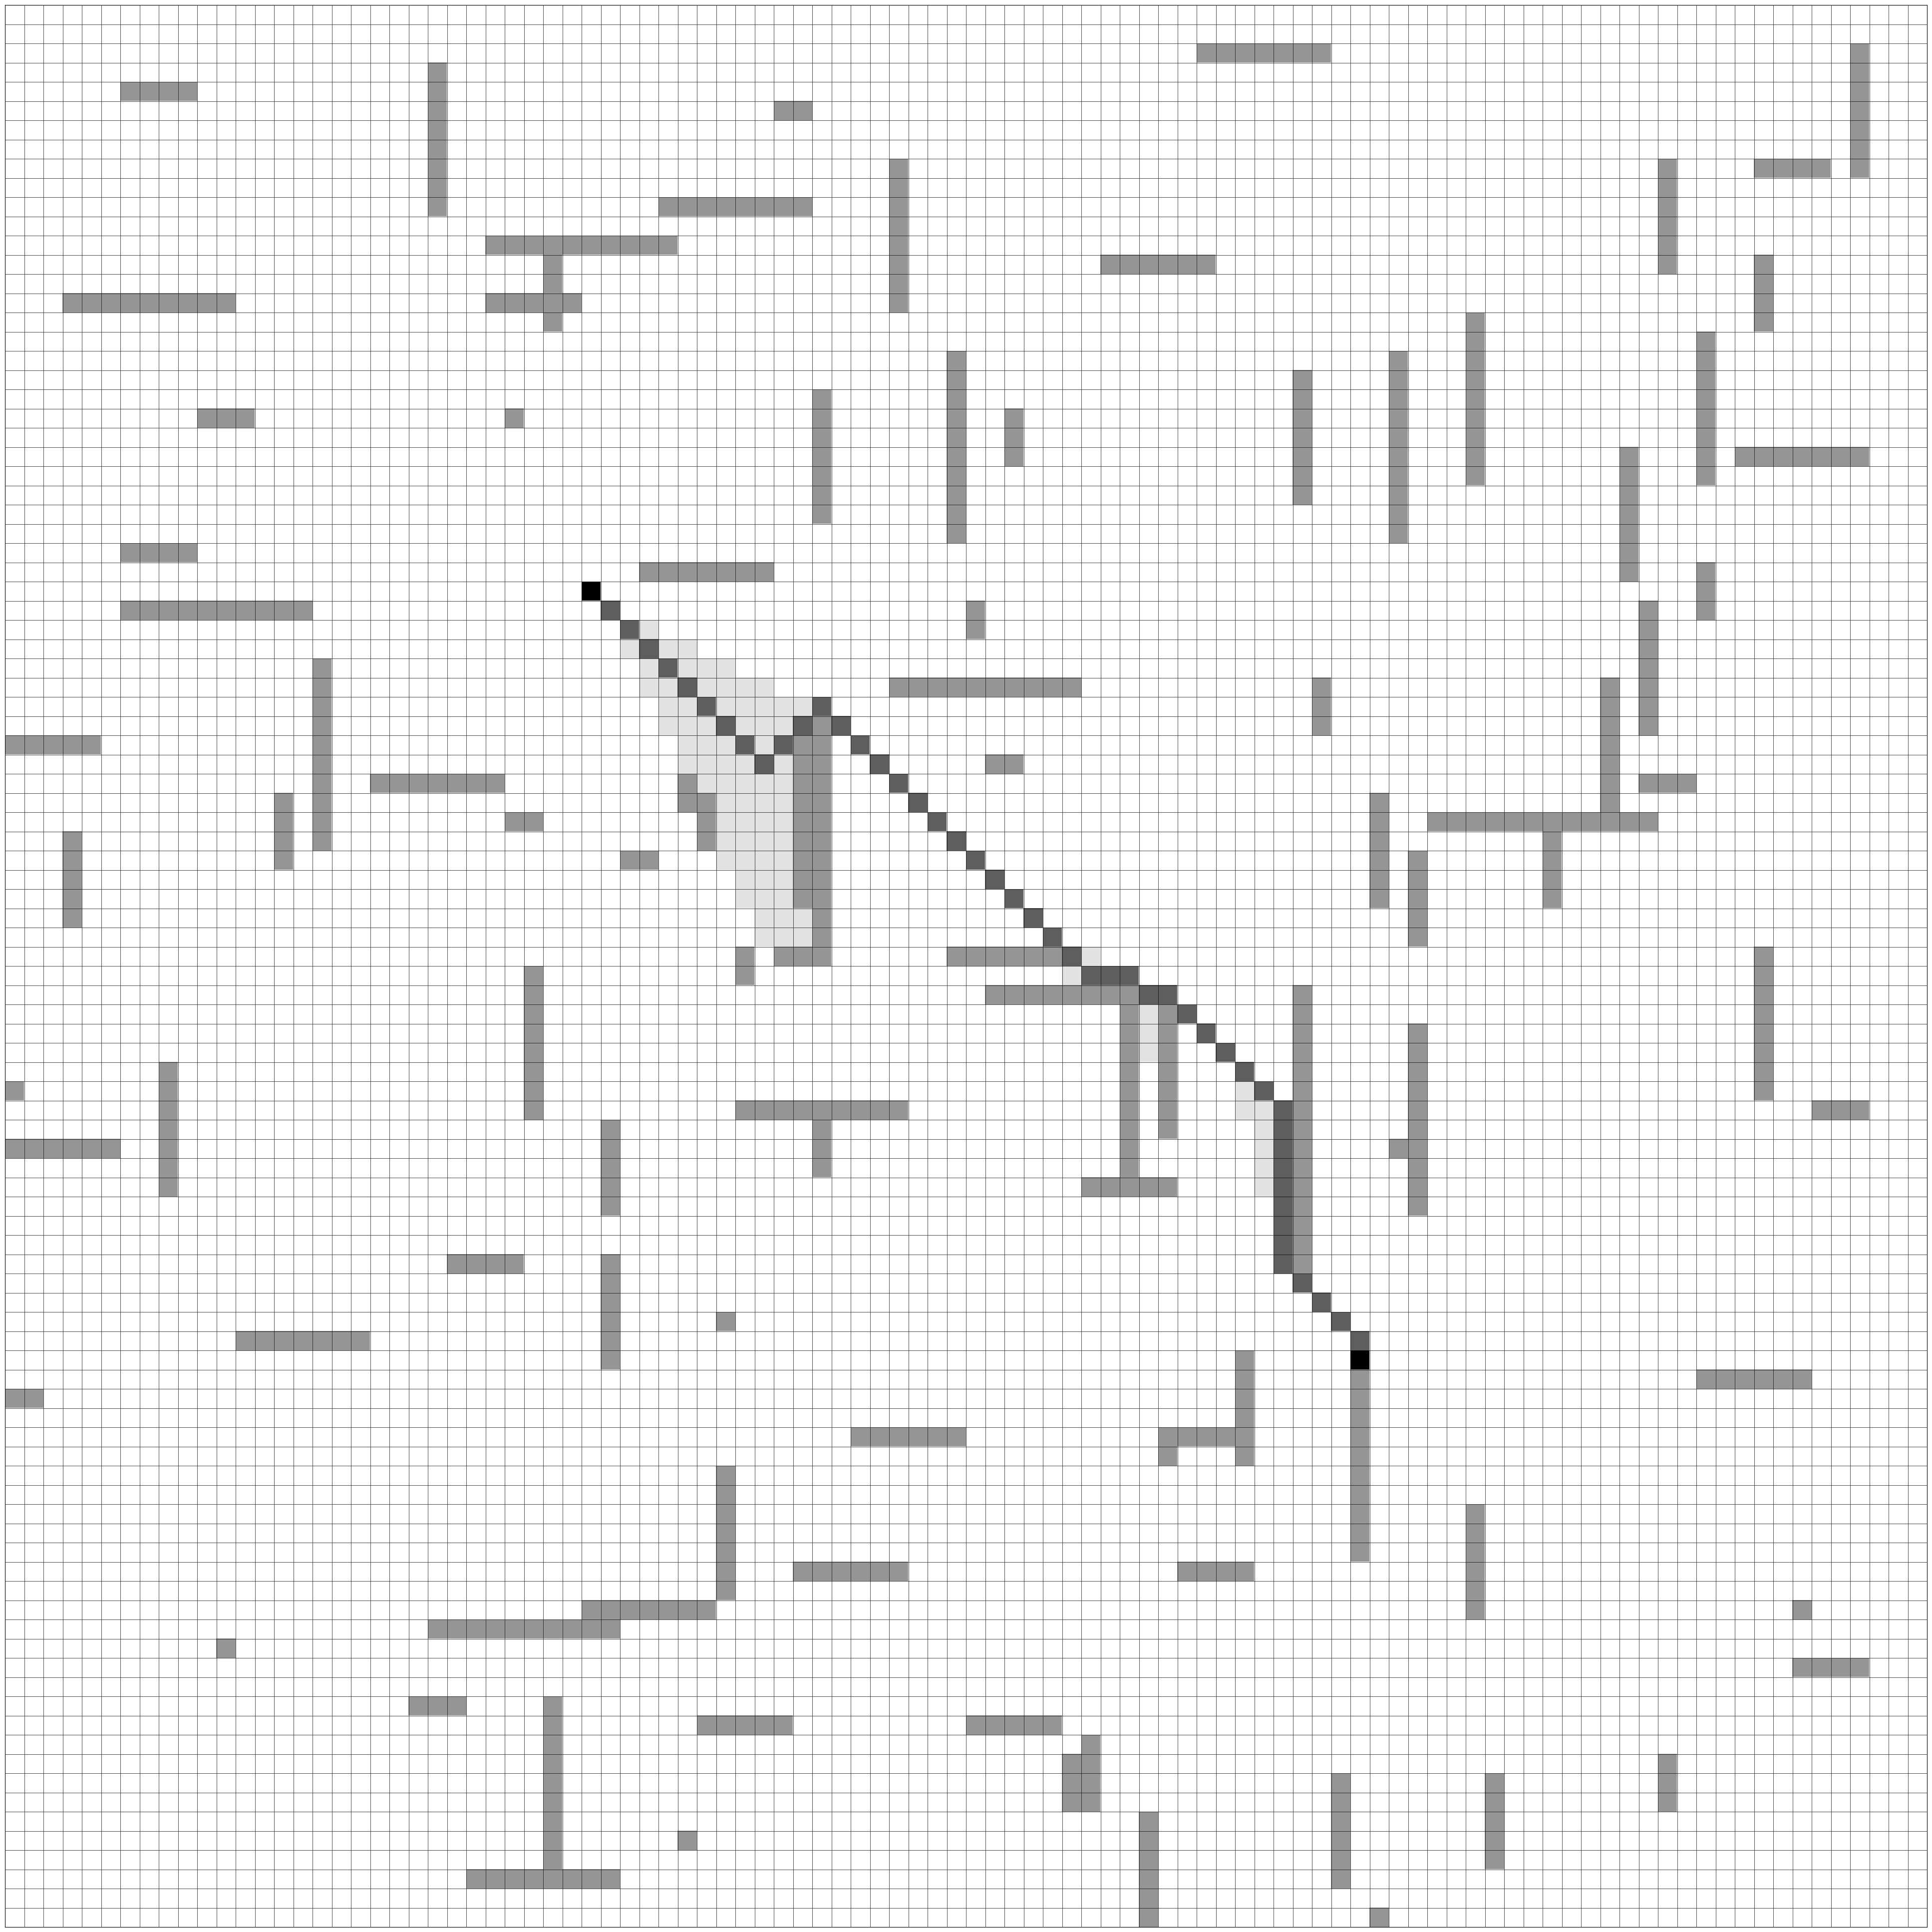

In [244]:
solution, explored_nodes = astar_search(heuristic, grid_problem)
plot(grid_problem, solution, explored_nodes)

The explored area in A* is more focused and directed towards the goal, while breadth first search explores more broadly. Both algorithms can find the shortest path, but A* is typically faster and more efficient in practice, especially in larger or more complex grids. However, if we don't need the optimal path, but just a good enough solution in order to save time and resources, we can use weighted A*:

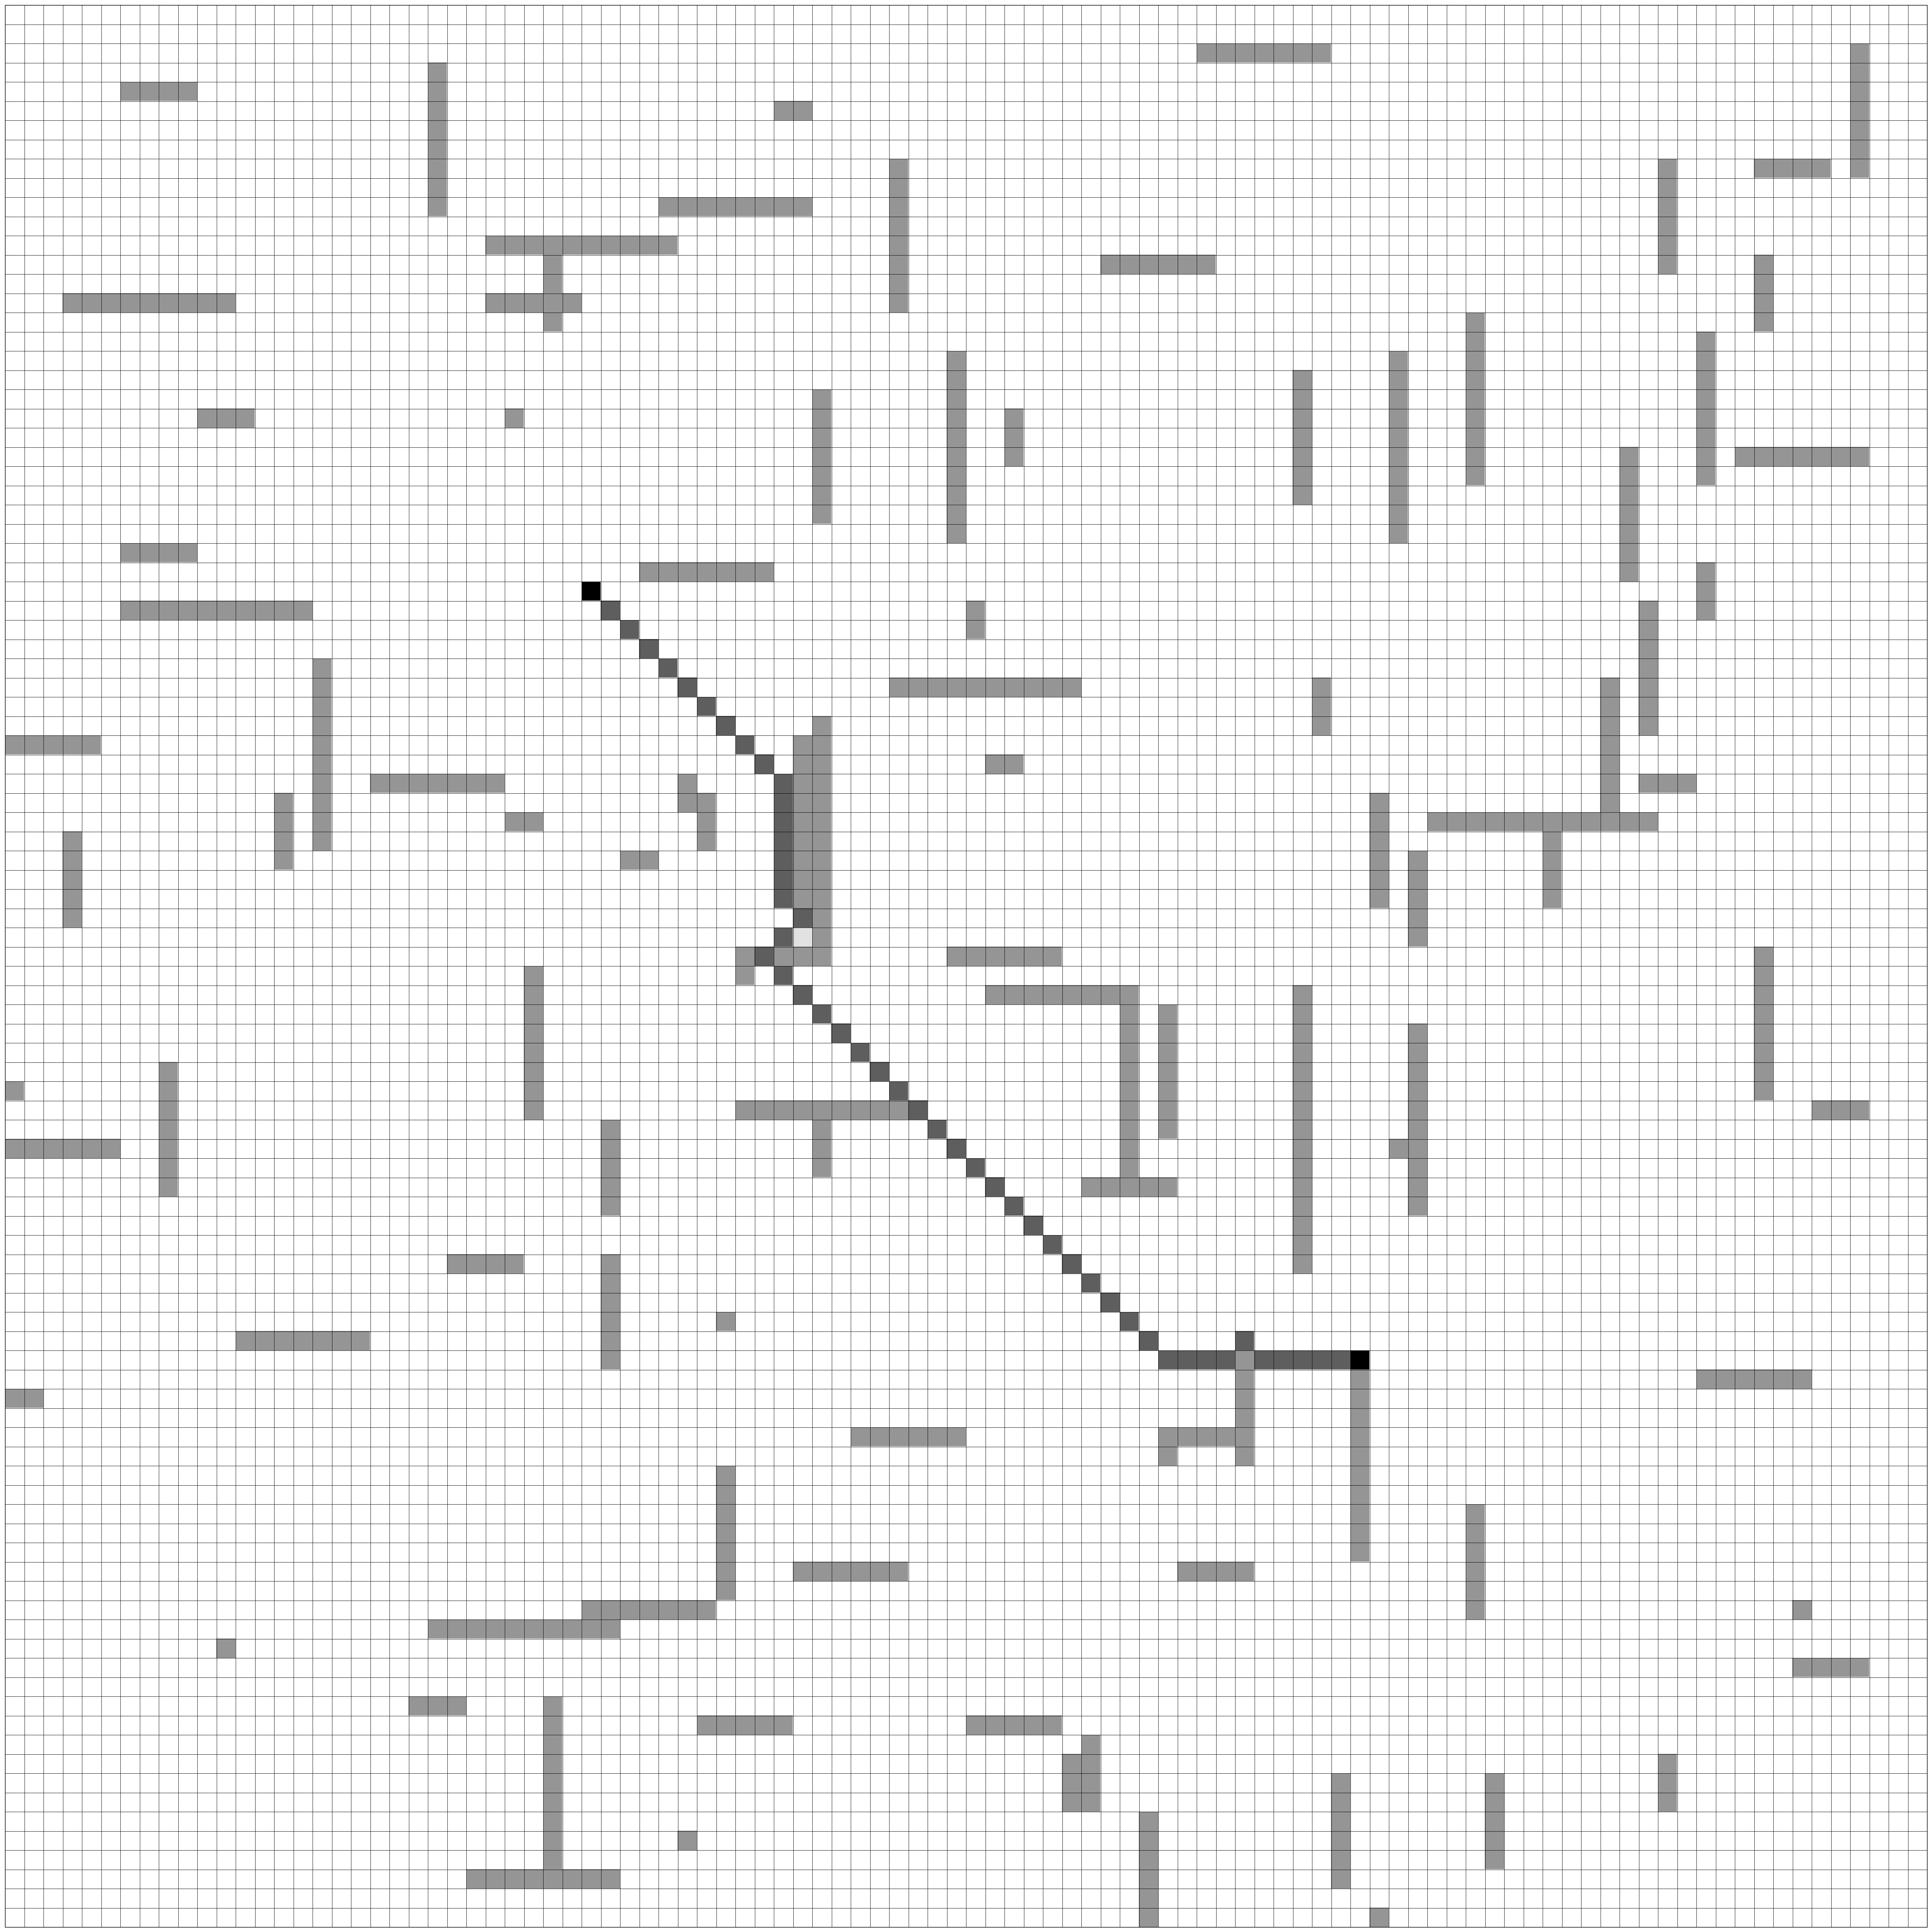

In [245]:
solution, explored_nodes = weighted_astar_search(heuristic, 20, grid_problem)
plot(grid_problem, solution, explored_nodes)

Weighted A* is generally most efficient in terms of speed. The explored area is complitelly focused and directed towards the goal and it finds a path quickly, but may not always the shortest.